# Libraries & Packages

In [1]:
!pip install -q tensorflow
!pip install -q optuna tqdm
!pip install -q lime
!pip install optuna-integration[tfkeras]
!pip install optuna-integration[xgboost]

print("Packages imported successfully!")

Packages imported successfully!


In [2]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Stats Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from pandas import Timedelta
from sklearn.preprocessing import MinMaxScaler



# SHAP & LIME
from scipy.stats import percentileofscore
from sklearn.model_selection import train_test_split
import shap
import lime
import lime.lime_tabular


# Hyperparameter Tuning
import optuna
from sklearn.model_selection import TimeSeriesSplit
from optuna.integration import XGBoostPruningCallback
from tqdm.notebook import tqdm
from optuna.integration import TFKerasPruningCallback

# Hugging Face Datasets Library
from datasets import load_dataset

# Notebook Settings for Visualization Consistency
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


# Loading the Data

In [3]:
dataset = load_dataset("Dingdong-Inc/FreshRetailNet-50K")
print(dataset)

# Access the splits and covert them to pandas df
train_df = dataset["train"].to_pandas()
test_df = dataset["eval"].to_pandas()

# To avoid data leakage during feature engineering we combine them first and will split them back later if needed for modeling.
train_df["__src"] = "train"
test_df["__src"]  = "test"
df = pd.concat([train_df, test_df], ignore_index=True)

print(f"\nCombined DataFrame created with shape: {df.shape}")
df.head()

DatasetDict({
    train: Dataset({
        features: ['city_id', 'store_id', 'management_group_id', 'first_category_id', 'second_category_id', 'third_category_id', 'product_id', 'dt', 'sale_amount', 'hours_sale', 'stock_hour6_22_cnt', 'hours_stock_status', 'discount', 'holiday_flag', 'activity_flag', 'precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level'],
        num_rows: 4500000
    })
    eval: Dataset({
        features: ['city_id', 'store_id', 'management_group_id', 'first_category_id', 'second_category_id', 'third_category_id', 'product_id', 'dt', 'sale_amount', 'hours_sale', 'stock_hour6_22_cnt', 'hours_stock_status', 'discount', 'holiday_flag', 'activity_flag', 'precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level'],
        num_rows: 350000
    })
})

Combined DataFrame created with shape: (4850000, 20)


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,stock_hour6_22_cnt,hours_stock_status,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level,__src
0,0,0,0,5,6,65,38,2024-03-28,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, ...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0,0,1.6999,15.48,73.54,1.97,train
1,0,0,0,5,6,65,38,2024-03-29,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, ...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0,0,3.0190,15.08,76.56,1.71,train
2,0,0,0,5,6,65,38,2024-03-30,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0,2.0942,15.91,76.47,1.73,train
3,0,0,0,5,6,65,38,2024-03-31,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, ...",11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",1.0,1,0,1.5618,16.13,77.40,1.76,train
4,0,0,0,5,6,65,38,2024-04-01,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, ...",8,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.0,0,0,3.5386,15.37,78.26,1.25,train


# Initial Feature Engineering for EDA

In [4]:
# Creating SKU sotre combination - concatinating store and product id
df["sku_store_id"] = df["product_id"].astype(str) + "_" + df["store_id"].astype(str)

In [5]:
# Convert the date string column 'dt' to a pandas datetime object for time-series operations.
df["date"] = pd.to_datetime(df["dt"])
# Ordering required for time series data
df = df.sort_values(['sku_store_id', 'date']).reset_index(drop=True)

In [6]:
# Define the target variable for convenience
df['y'] = df['sale_amount']

## Stockout Feature Engineering

In [7]:
# given in the dataset description
open_hours = 17

df["stockout_hours_d"] = df["stock_hour6_22_cnt"].astype(float)

# Calculate the stockout ratio
df["stockout_ratio_d"]  = df["stockout_hours_d"] / open_hours

# Create a binary flag indicating if any stockout occurred on a given day.
df["any_stockout_d"] = (df["stockout_hours_d"] > 0).astype(int)

## Date Based Feature Engineering

In [8]:
# Day of the week (0=Monday, 6=Sunday) using date col
df["dow"] = df["date"].dt.dayofweek

# Binary flag for weekends
df["is_weekend"] = (df["dow"] >= 5).astype(int)

# Week of the year, using ISO standard.
df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)

# Month of the year.
df["month"] = df["date"].dt.month

## Promotion Feature Engineering

In [9]:
conditions = [
    (df['discount'] == 1) & (df['activity_flag'] == 1), # Non-price promotion (bundles, 1+1)
    (df['discount'] < 1) & (df['activity_flag'] == 0),  # Price discount without marketing activity (about to expire products)
    (df['discount'] < 1) & (df['activity_flag'] == 1),  # Standard discount with marketing activity (25% off)
]

# Define the corresponding labels for each strategy.
choices = ['Non-Price Promo', 'Price Penetration', 'Standard Discount']

# Use np.select to create the new categorical 'promo_strategy' feature.
# The default value is 'Full Price' discount = 1 , activity_flag = 0
df['promo_strategy'] = np.select(conditions, choices, default='Full Price')

# Create an intuitive 'discount_depth' feature (e.g., 0.1 for a 10% discount).
# This is often more interpretable for models than a price multiplier.
df['discount_depth'] = 1 - df['discount']

# Creating Splits

In [10]:
# Chronological Cutoff Dates
TRAIN_END = pd.Timestamp("2024-06-10")
VAL_END   = pd.Timestamp("2024-06-25")

train_df = df.loc[df['date'] <= TRAIN_END].copy()
val_df   = df.loc[(df['date'] > TRAIN_END) & (df['date'] <= VAL_END)].copy()
test_df  = df.loc[df['date'] > VAL_END].copy()

# Feature Engineering

## Log Transformation

In [11]:
for df in [train_df, val_df, test_df]:
    df['log_y'] = np.log1p(df['y'])

## Historical Features

In [12]:
def create_historical_features(df_to_feature, history_df):

    required_history_days = 14 # more days attained to ensure enough history
    history_tail = history_df.groupby('sku_store_id').tail(required_history_days)
    combined = pd.concat([history_tail, df_to_feature], ignore_index=True)

    # We keep the 'last' occurrence, which prioritizes the data from df_to_feature.
    combined.drop_duplicates(subset=['date', 'sku_store_id'], keep='last', inplace=True)

    # The rest of the function can now proceed with the clean, de-duplicated data
    combined.sort_values(['sku_store_id', 'date'], inplace=True)
    g_combined = combined.groupby("sku_store_id", group_keys=False)


    log_y_shift = g_combined["log_y"].shift(1)
    combined["log_y_lag_1d"] = log_y_shift
    combined["log_y_lag_7d"] = g_combined["log_y"].shift(7)
    combined["log_y_roll_mean_7d"] = log_y_shift.rolling(7, min_periods=3).mean()
    combined["log_y_roll_std_7d"]  = log_y_shift.rolling(7, min_periods=3).std()

    sr_shift = g_combined["stockout_ratio_d"].shift(1)
    combined["stockout_ratio_lag1d"] = sr_shift
    combined["stockout_ratio_r7d"]   = sr_shift.rolling(7, min_periods=3).mean()

    featured_df = combined[combined['date'].isin(df_to_feature['date'])].copy()

    return featured_df

print("create_historical_features is ready to use.")

create_historical_features is ready to use.


In [13]:
# Training Set
train_df_featured = create_historical_features(train_df, train_df)


# Validation Set
val_df_featured = create_historical_features(val_df, train_df_featured)


# Test Set
full_history_for_test = pd.concat([train_df_featured, val_df_featured], ignore_index=True)
test_df_featured = create_historical_features(test_df, full_history_for_test)

## Target Encoding

In [14]:
def create_time_aware_encodings(df_to_feature, history_df, id_cols, warmup_days=7):

    # Temporarily combine the full history with the dataframe we want to feature.
    # We need the full history for a cumulative sum
    combined = pd.concat([history_df, df_to_feature], ignore_index=True)
    combined.sort_values(['product_id', 'date'], inplace=True) # Sort is essential for cumulative stats

    target_col = 'log_y'

    for col in id_cols:
        if col not in combined.columns:
            continue

        # Collapse to one row per (ID, date) to avoid same-day leakage
        daily = (
            combined[[col, 'date', target_col]]
            .groupby([col, 'date'], as_index=False, sort=False)[target_col]
            .mean()
            .sort_values('date')
        )

        # past-only cumulative logic
        g = daily.groupby(col, sort=False)[target_col]
        daily['cum_sum'] = g.cumsum().shift(1)
        daily['cum_cnt'] = g.cumcount()
        daily['enc'] = daily['cum_sum'] / daily['cum_cnt'].replace(0, np.nan)

        # Merge the encodings back to the combined dataframe
        combined = combined.merge(
            daily[[col, 'date', 'enc', 'cum_cnt']].rename(
                columns={'enc': f'{col}_target_encoded', 'cum_cnt': f'__{col}_past_days'}
            ),
            on=[col, 'date'], how='left'
        )

    # Apply warm-up filter - ensuring enough history and dropping the missing value rows
    mask = np.ones(len(combined), dtype=bool)
    for col in id_cols:
        cnt_col = f'__{col}_past_days'
        if cnt_col in combined.columns:
            # We must handle NaNs in the count column before comparison
            mask &= (combined[cnt_col].fillna(-1) >= warmup_days)

    # Filter the combined dataframe
    combined_filtered = combined[mask].copy()

    # Return only the original rows of the target dataframe, but now with features and filtered.
    featured_df = combined_filtered[combined_filtered['date'].isin(df_to_feature['date'])].copy()

    return featured_df

print("create_time_aware_encodings' is ready now.")

create_time_aware_encodings' is ready now.


## XGBoost Model Feature Engineering

### One-hot-encoding for promo strategy and day of the week

In [15]:

# Fit on the training data and transform all sets to handle categories consistently.
ohe_cols = [c for c in ['dow','promo_strategy'] if c in train_df_featured.columns]
if ohe_cols:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

    # Fit on training data
    ohe.fit(train_df_featured[ohe_cols])

    def apply_ohe(df, encoder, cols):
        new_cols = encoder.transform(df[cols])
        new_df = pd.DataFrame(new_cols, index=df.index, columns=encoder.get_feature_names_out(cols))
        return pd.concat([df.drop(columns=cols), new_df], axis=1)

    train_df_encoded = apply_ohe(train_df_featured, ohe, ohe_cols)
    val_df_encoded = apply_ohe(val_df_featured, ohe, ohe_cols)
    test_df_encoded = apply_ohe(test_df_featured, ohe, ohe_cols)
    print("One-hot encoding complete.")
else:
    train_df_encoded = train_df_featured
    val_df_encoded = val_df_featured
    test_df_encoded = test_df_featured
    print("No columns to one-hot encode.") # to check the data


# Target Encode the Training Set
id_cols = [
    'product_id', 'store_id', 'city_id', 'management_group_id',
    'first_category_id', 'second_category_id', 'third_category_id'
]
# For the training set, its history is empty. We create a placeholder.
empty_df = train_df_encoded.head(0)

train_df_final = create_time_aware_encodings(train_df_encoded, empty_df, id_cols)

One-hot encoding complete.


In [16]:
# Transform the Validation Set
val_df_final = create_time_aware_encodings(val_df_encoded, train_df_encoded, id_cols)

In [17]:
# Transform the Test Set
full_history_for_test = pd.concat([train_df_encoded, val_df_encoded], ignore_index=True)
test_df_final = create_time_aware_encodings(test_df_encoded, full_history_for_test, id_cols)

### Sanity Check - for feature engineering

In [20]:
if not train_df_final.empty:
    print(f"Training set:   {train_df_final.shape[0]:,} rows | Dates: {train_df_final['date'].min().date()} to {train_df_final['date'].max().date()}")
else:
    print("Training set is EMPTY!")

if not val_df_final.empty:
    print(f"Validation set: {val_df_final.shape[0]:,} rows | Dates: {val_df_final['date'].min().date()} to {val_df_final['date'].max().date()}")
else:
    print("Validation set is EMPTY!")

if not test_df_final.empty:
    print(f"Test set:       {test_df_final.shape[0]:,} rows | Dates: {test_df_final['date'].min().date()} to {test_df_final['date'].max().date()}")
else:
    print("Test set is EMPTY!")

Training set:   3,400,000 rows | Dates: 2024-04-04 to 2024-06-10
Validation set: 750,000 rows | Dates: 2024-06-11 to 2024-06-25
Test set:       350,000 rows | Dates: 2024-06-26 to 2024-07-02


### Drop Redundant Features

In [18]:
# creating splits' copies in case it is needed for the analysis
train_df_analysis = train_df_final.copy()
val_df_analysis = val_df_final.copy()
test_df_analysis = test_df_final.copy()

In [19]:
columns_to_drop = [
    'city_id', 'store_id', 'management_group_id', 'first_category_id',
       'second_category_id', 'third_category_id', 'product_id', 'dt',
       'sale_amount', 'hours_sale', 'stock_hour6_22_cnt', 'hours_stock_status',
       'discount', 'activity_flag','__src','stockout_hours_d','any_stockout_d', 'is_weekend', 'week_of_year', 'month','__product_id_past_days', '__store_id_past_days', '__city_id_past_days', '__management_group_id_past_days',
    '__first_category_id_past_days', '__second_category_id_past_days', '__third_category_id_past_days'
]

# Drop columns from all three DataFrames, ignoring errors if a column was already dropped.
train_df_final.drop(columns=columns_to_drop, inplace=True, errors='ignore')
val_df_final.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_df_final.drop(columns=columns_to_drop, inplace=True, errors='ignore')


# Final df
print("\nTraining Set:")
train_df_final.info()
print("\nValidation Set:")
val_df_final.info()
print("\nTest Set:")
test_df_final.info()


Training Set:
<class 'pandas.core.frame.DataFrame'>
Index: 3400000 entries, 91 to 3749999
Data columns (total 28 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   holiday_flag                        int32         
 1   precpt                              float64       
 2   avg_temperature                     float64       
 3   avg_humidity                        float64       
 4   avg_wind_level                      float64       
 5   sku_store_id                        object        
 6   date                                datetime64[ns]
 7   y                                   float64       
 8   stockout_ratio_d                    float64       
 9   dow                                 int32         
 10  discount_depth                      float64       
 11  log_y                               float64       
 12  log_y_lag_1d                        float64       
 13  log_y_lag_7d                   

## LSTM Feature Engineering

In [ ]:

# Fit on the training data and transform all sets to handle categories consistently.
ohe_cols = [c for c in ['promo_strategy'] if c in train_df_featured.columns]
if ohe_cols:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

    # Fit on training data
    ohe.fit(train_df_featured[ohe_cols])

    def apply_ohe(df, encoder, cols):
        new_cols = encoder.transform(df[cols])
        new_df = pd.DataFrame(new_cols, index=df.index, columns=encoder.get_feature_names_out(cols))
        return pd.concat([df.drop(columns=cols), new_df], axis=1)

    train_df_encoded = apply_ohe(train_df_featured, ohe, ohe_cols)
    val_df_encoded = apply_ohe(val_df_featured, ohe, ohe_cols)
    test_df_encoded = apply_ohe(test_df_featured, ohe, ohe_cols)
    print("One-hot encoding complete.")
else:
    train_df_encoded = train_df_featured
    val_df_encoded = val_df_featured
    test_df_encoded = test_df_featured
    print("No columns to one-hot encode.") # to check the data


# Target Encode the Training Set
id_cols = [
    'product_id', 'store_id', 'city_id', 'management_group_id',
    'first_category_id', 'second_category_id', 'third_category_id'
]
# For the training set, its history is empty. We create a placeholder.
empty_df = train_df_encoded.head(0)

train_df_final = create_time_aware_encodings(train_df_encoded, empty_df, id_cols)

One-hot encoding complete.


In [ ]:
# Transform the Validation Set
val_df_final = create_time_aware_encodings(val_df_encoded, train_df_encoded, id_cols)

In [ ]:
# Transform the Test Set
full_history_for_test = pd.concat([train_df_encoded, val_df_encoded], ignore_index=True)
test_df_final = create_time_aware_encodings(test_df_encoded, full_history_for_test, id_cols)

### Cyclical Features

In [20]:
# Cell 2: Cyclical Features and Final Feature Selection


# Create copies to prevent modify df of XGBoost
train_df_lstm = train_df_final.copy()
val_df_lstm = val_df_final.copy()
test_df_lstm = test_df_final.copy()

# Create Cyclical Features for 'dow'
for df in [train_df_lstm, val_df_lstm, test_df_lstm]:
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7.0)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7.0)

# --- Step 3: Define the Final Feature Set ---
TARGET_LTSM = 'log_y'
ALL_FEATURES = train_df_lstm.columns.tolist()
COLUMNS_TO_DROP = [ 'log_y','y', 'dow', 'date', 'sku_store_id', 'precpt', 'avg_humidity', 'avg_temperature', 'avg_wind_level']


# The final list of features for the LSTM
FEATURES_LSTM = [f for f in ALL_FEATURES if f not in COLUMNS_TO_DROP]
print(f"   -> Using {len(FEATURES_LSTM)} features.")

# --- Step 4: Create the base DataFrames for scaling ---
# These contain only the columns we will scale.
train_lstm_base = train_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]
val_lstm_base = val_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]
test_lstm_base = test_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]

print("✅ Base DataFrames for LSTM are ready for scaling.")

   -> Using 21 features.
✅ Base DataFrames for LSTM are ready for scaling.


### Defining the feature space for LSTM

In [21]:
TARGET_LTSM = 'log_y'
ALL_FEATURES = train_df_lstm.columns.tolist()
COLUMNS_TO_DROP = [ 'log_y','y', 'dow', 'date', 'sku_store_id', 'precpt', 'avg_humidity', 'avg_temperature', 'avg_wind_level']


FEATURES_LSTM = [f for f in ALL_FEATURES if f not in COLUMNS_TO_DROP]
print(f"   -> Using {len(FEATURES_LSTM)} features.")

# --- Step 4: Create the base DataFrames for scaling ---
# These contain only the columns we will scale.
train_lstm_base = train_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]
val_lstm_base = val_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]
test_lstm_base = test_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]

print("✅ Base DataFrames for LSTM are ready for scaling.")

   -> Using 21 features.
✅ Base DataFrames for LSTM are ready for scaling.


### Normalization

In [22]:
# These contain only the columns we will scale.
train_lstm_base = train_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]
val_lstm_base = val_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]
test_lstm_base = test_df_lstm[FEATURES_LSTM + [TARGET_LTSM]]

print("✅ Base DataFrames for LSTM are ready for scaling.")

✅ Base DataFrames for LSTM are ready for scaling.


In [23]:

# Normalizing Data - Fit on Train, Transform on All

scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on Train
scaler.fit(train_lstm_base)

# Transform all
train_scaled = scaler.transform(train_lstm_base)
val_scaled = scaler.transform(val_lstm_base)
test_scaled = scaler.transform(test_lstm_base)

### Create the sequences

In [24]:
def create_sequences(data, n_timesteps):
    X, y = [], []
    # The last column is the target ('log_y')
    for i in tqdm(range(len(data) - n_timesteps), desc="Creating Sequences"):
        end_ix = i + n_timesteps
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Using a 7-day lookback to capture weekly patterns
N_TIMESTEPS = 7

# Create sequences for all splits
X_train_lstm, y_train_lstm = create_sequences(train_scaled, N_TIMESTEPS)
X_val_lstm, y_val_lstm = create_sequences(val_scaled, N_TIMESTEPS)
X_test_lstm, y_test_lstm = create_sequences(test_scaled, N_TIMESTEPS)

# Also prepare the original-scale test targets for our final evaluation
# slice them to align with the sequences we created
y_test_true_orig = test_df_lstm['y'].iloc[N_TIMESTEPS:].values
y_test_true_log = test_df_lstm['log_y'].iloc[N_TIMESTEPS:].values

Creating Sequences:   0%|          | 0/3399993 [00:00<?, ?it/s]

Creating Sequences:   0%|          | 0/749993 [00:00<?, ?it/s]

Creating Sequences:   0%|          | 0/349993 [00:00<?, ?it/s]

### Sanity Check

In [25]:
# Check for NaNs
assert not np.isnan(train_scaled).any(), "NaNs found in train_scaled"
assert not np.isnan(val_scaled).any(), "NaNs found in val_scaled"
assert not np.isnan(test_scaled).any(), "NaNs found in test_scaled"
print("OK")


TOLERANCE = 1e-9 # A very small number
assert np.all(train_scaled >= 0 - TOLERANCE) and np.all(train_scaled <= 1 + TOLERANCE), "train_scaled is not within the [0, 1] range (with tolerance)"
print("OK")

if val_scaled.max() > 1.0 or test_scaled.max() > 1.0:
    print(f"INFO: val_scaled (max={val_scaled.max():.2f}) and test_scaled (max={test_scaled.max():.2f}) have values > 1.0, which is expected.")

assert len(X_train_lstm.shape) == 3
print("OK")

assert len(X_test_lstm) == len(y_test_true_orig)
print("OK")

OK
OK
INFO: val_scaled (max=1.06) and test_scaled (max=1.08) have values > 1.0, which is expected.
OK
OK


# Seasonal Naive - Baseline

In [ ]:
def generate_seasonal_naive_forecasts(history_df: pd.DataFrame, forecast_df: pd.DataFrame, seasonal_period: int) -> pd.DataFrame:

    print(f"\nGenerating Seasonal Naive forecasts for {len(forecast_df):,} rows")
    all_chunks = []
    unique_skus = forecast_df['sku_store_id'].unique()

    for sku in tqdm(unique_skus, desc="Forecasting by SKU"):
        history_sku = history_df[history_df['sku_store_id'] == sku]['log_y']
        forecast_sku = forecast_df.loc[forecast_df['sku_store_id'] == sku, ['log_y']]

        if history_sku.empty or forecast_sku.empty:
            continue

        forecast_idx = forecast_sku.index
        source_idx = forecast_idx - Timedelta(days=seasonal_period)

        preds = history_sku.reindex(source_idx)
        preds.index = forecast_idx

        chunk = pd.DataFrame({
            'sku_store_id': sku,
            'log_y_true': forecast_sku['log_y'],
            'log_y_pred': preds
        }, index=forecast_idx)
        all_chunks.append(chunk)

    if not all_chunks:
        raise RuntimeError("No predictions were generated. Check data availability and split dates.")

    results_df = pd.concat(all_chunks).sort_index()
    results_df.dropna(subset=['log_y_pred'], inplace=True)
    print(f"Successfully generated {len(results_df):,} predictions.")
    return results_df

def evaluate_forecast(results_df: pd.DataFrame) -> dict:
    log_rmse = np.sqrt(mean_squared_error(results_df['log_y_true'], results_df['log_y_pred']))
    y_true_orig = np.expm1(results_df['log_y_true'])
    y_pred_orig = np.expm1(results_df['log_y_pred'])
    wape = np.sum(np.abs(y_true_orig - y_pred_orig)) / np.sum(y_true_orig)
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    return {'LOG RMSE': log_rmse, 'WAPE': wape, 'MAE': mae, 'RMSE': rmse}

In [ ]:
# Data Preparation

final_dfs = {
    "Training Set": train_df_final,
    "Validation Set": val_df_final,
    "Test Set": test_df_final
}

for name, df in final_dfs.items():
    if 'date' in df.columns:
        df.set_index('date', inplace=True)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError(f"Index for {name} is not a DatetimeIndex.")
    print(f"'{name}' is ready. Index type: {type(df.index)}")

SEASONAL_PERIOD = 7

In [ ]:
# Cell 2: Evaluate Baseline on Validation Set

# Generate forecasts for the validation period using the training history
val_results_df = generate_seasonal_naive_forecasts(
    history_df=train_df_final,
    forecast_df=val_df_final,
    seasonal_period=SEASONAL_PERIOD
)

# Calculate the performance metrics
val_performance = evaluate_forecast(val_results_df)

# Display the results in a clean table
val_results_table = pd.DataFrame({'Seasonal Naive (on Val)': val_performance}).T


print("SEASONAL NAIVE PERFORMANCE (on Val Set)")
print(val_results_table.to_string(formatters={'WAPE':'{:.2%}'.format}))
print("\n✅ Baseline evaluation on validation set complete.")


Generating Seasonal Naive forecasts for 750,000 rows


Forecasting by SKU:   0%|          | 0/50000 [00:00<?, ?it/s]

Successfully generated 350,000 predictions.

SEASONAL NAIVE PERFORMANCE (on Val Set)
                         LOG RMSE   WAPE      MAE      RMSE
Seasonal Naive (on Val)  0.303288 43.13%  0.45441  0.765074

✅ Baseline evaluation on validation set complete.


In [ ]:
# ===================================================================
# CELL: Evaluate Baseline on Test Set (Using Clean Analysis Backups)
# ===================================================================
import pandas as pd

print("--- Using the clean '_analysis' dataframes to ensure data integrity ---")

# --- Step 1: Use the clean backup dataframes, not the '_final' ones ---
# We make copies to ensure we don't modify the originals.
train_data_clean = train_df_analysis.copy()
val_data_clean = val_df_analysis.copy()
test_data_clean = test_df_analysis.copy()

# --- Step 2: A simple, robust data preparation on the clean data ---
for name, df in [('train_data', train_data_clean), ('val_data', val_data_clean), ('test_data', test_data_clean)]:
    # The '_analysis' frames are guaranteed to have a 'date' column.
    if 'date' not in df.columns:
        raise KeyError(f"Critical Error: The backup dataframe '{name}' is also missing the 'date' column.")

    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    if isinstance(df.index, pd.DatetimeIndex):
        print(f"✅ '{name}' is now correctly indexed by date.")
    else:
        raise TypeError(f"🚨 FAILED to index '{name}'.")

# --- Step 3: Proceed with the evaluation using the clean data ---

# Combine the clean training and validation data
full_history_df = pd.concat([train_data_clean, val_data_clean])
print(f"\nCreated full history from {full_history_df.index.min().date()} to {full_history_df.index.max().date()}") # This will now show correct dates!

# Generate forecasts for the test period using the clean history and test set
test_results_df = generate_seasonal_naive_forecasts(
    history_df=full_history_df,
    forecast_df=test_data_clean,
    seasonal_period=SEASONAL_PERIOD
)

# Calculate the final performance metrics
test_performance = evaluate_forecast(test_results_df)

# Display the final, reportable results
test_results_table = pd.DataFrame({'Seasonal Naive (on Test)': test_performance}).T

print("\n" + "="*50)
print("--- FINAL SEASONAL NAIVE PERFORMANCE (on Test Set) ---")
print("="*50)
print(test_results_table.to_string(formatters={'WAPE':'{:.2%}'.format}))
print("\n✅ Final baseline evaluation on test set complete.")

--- Using the clean '_analysis' dataframes to ensure data integrity ---
✅ 'train_data' is now correctly indexed by date.
✅ 'val_data' is now correctly indexed by date.
✅ 'test_data' is now correctly indexed by date.

Created full history from 2024-04-04 to 2024-06-25

Generating Seasonal Naive forecasts for 350,000 rows


Forecasting by SKU:   0%|          | 0/50000 [00:00<?, ?it/s]

Successfully generated 350,000 predictions.

--- FINAL SEASONAL NAIVE PERFORMANCE (on Test Set) ---
                          LOG RMSE   WAPE       MAE      RMSE
Seasonal Naive (on Test)  0.317565 41.83%  0.499071  0.835819

✅ Final baseline evaluation on test set complete.


In [ ]:
# ===================================================================
# CELL 1: Create the Baseline Analysis DataFrame
# ===================================================================

print("--- Creating a unified DataFrame for Seasonal Naive error analysis ---")

# We have 'test_results_df' from the baseline evaluation.
# We have 'test_data_clean' from the data preparation step, which contains all original features.

# Step 1: Ensure both dataframes are ready for merging.
# We'll work with columns for simplicity, so reset the index.
results_to_merge = test_results_df.reset_index()
features_to_merge = test_data_clean.reset_index()

# Step 2: Merge the predictions with the original features.
# The key is the combination of 'date' and 'sku_store_id'.
baseline_analysis_df = pd.merge(
    results_to_merge,
    features_to_merge,
    on=['date', 'sku_store_id'],
    how='inner' # Use 'inner' to ensure we only analyze rows with both predictions and features.
)

# Step 3: Calculate the errors on the original scale (most interpretable).
baseline_analysis_df['y_true'] = np.expm1(baseline_analysis_df['log_y_true'])
baseline_analysis_df['y_pred'] = np.expm1(baseline_analysis_df['log_y_pred'])
baseline_analysis_df['error'] = baseline_analysis_df['y_true'] - baseline_analysis_df['y_pred']
baseline_analysis_df['abs_error'] = baseline_analysis_df['error'].abs()

print(f"✅ Created 'baseline_analysis_df' with shape: {baseline_analysis_df.shape}")
print("This DataFrame now contains predictions, errors, and all original features.")

# Display the first few rows with the new error columns
display(baseline_analysis_df[['date', 'sku_store_id', 'y_true', 'y_pred', 'error', 'abs_error']].head())

--- Creating a unified DataFrame for Seasonal Naive error analysis ---
✅ Created 'baseline_analysis_df' with shape: (350000, 66)
This DataFrame now contains predictions, errors, and all original features.


,date,sku_store_id,y_true,y_pred,error,abs_error
0,2024-06-26,0_135,1.2,1.1,0.1,0.1
1,2024-06-26,824_602,0.5,0.4,0.1,0.1
2,2024-06-26,207_621,0.8,1.6,-0.8,0.8
3,2024-06-26,207_620,1.7,1.2,0.5,0.5
4,2024-06-26,682_578,0.8,0.3,0.5,0.5



--- Analyzing Baseline Error Distribution for the Top 10 Worst Categories ---
Identified Top 10 worst categories (by median absolute error): [2, 5, 22, 20, 28, 26, 4, 29, 23, 3]


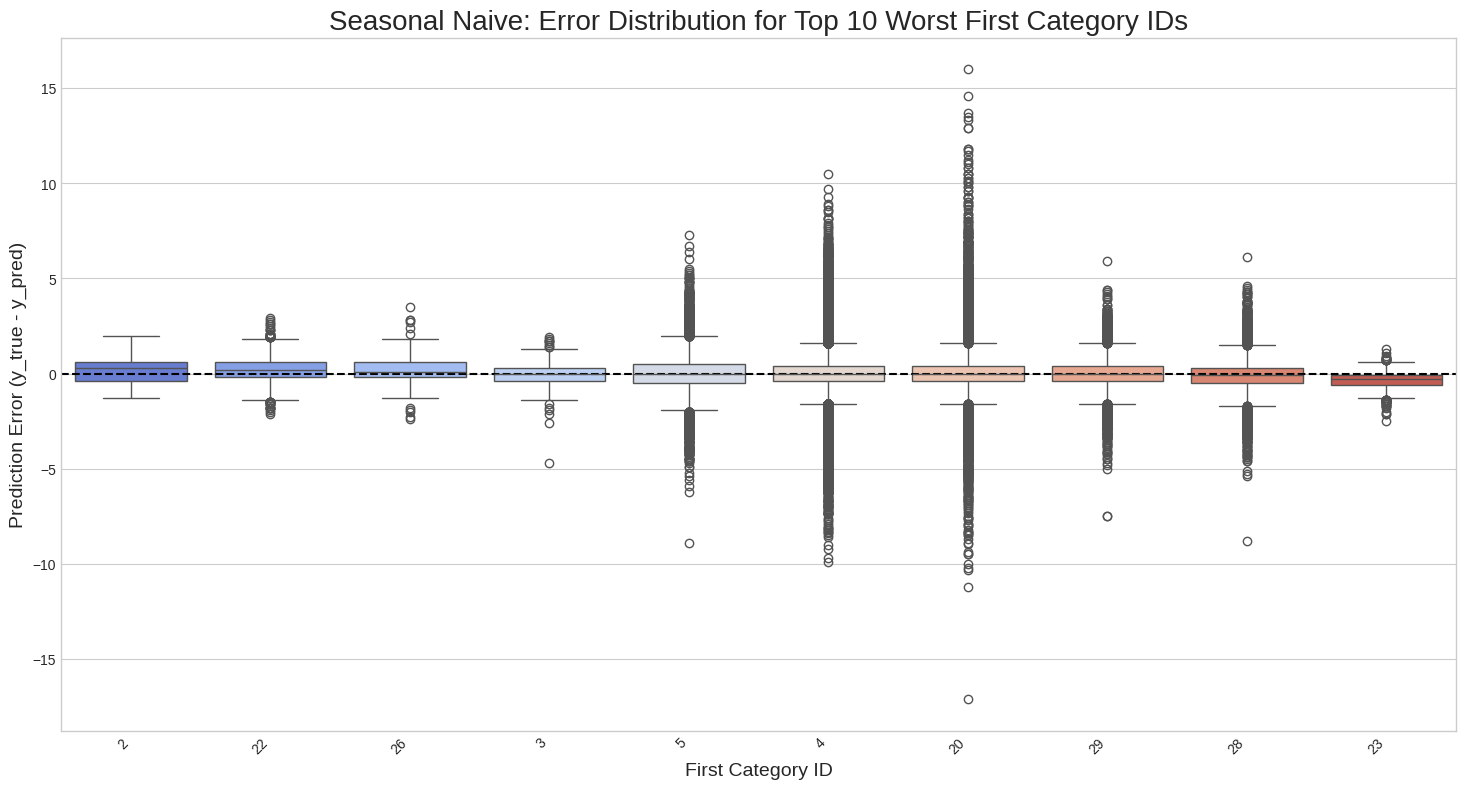

In [ ]:
category_to_analyze = 'first_category_id'

# This finds the categories that are, on average, the most wrong.
top_10_categories = (baseline_analysis_df.groupby(category_to_analyze)['abs_error']
                     .median()
                     .sort_values(ascending=False)
                     .head(10)
                     .index)

df_to_plot = baseline_analysis_df[baseline_analysis_df[category_to_analyze].isin(top_10_categories)]

sorted_order = (df_to_plot.groupby(category_to_analyze)['error']
                .median()
                .sort_values(ascending=False)
                .index)

plt.figure(figsize=(18, 9))
sns.boxplot(
    data=df_to_plot,
    x=category_to_analyze,
    y='error',
    order=sorted_order,
    palette='coolwarm'
)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Seasonal Naive: Error Distribution for Top 10 Worst First Category IDs', fontsize=20)
plt.xlabel('First Category ID', fontsize=14)
plt.ylabel('Prediction Error (y_true - y_pred)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

--- Deep-Dive Analysis for Category 20 (Seasonal Naive) ---


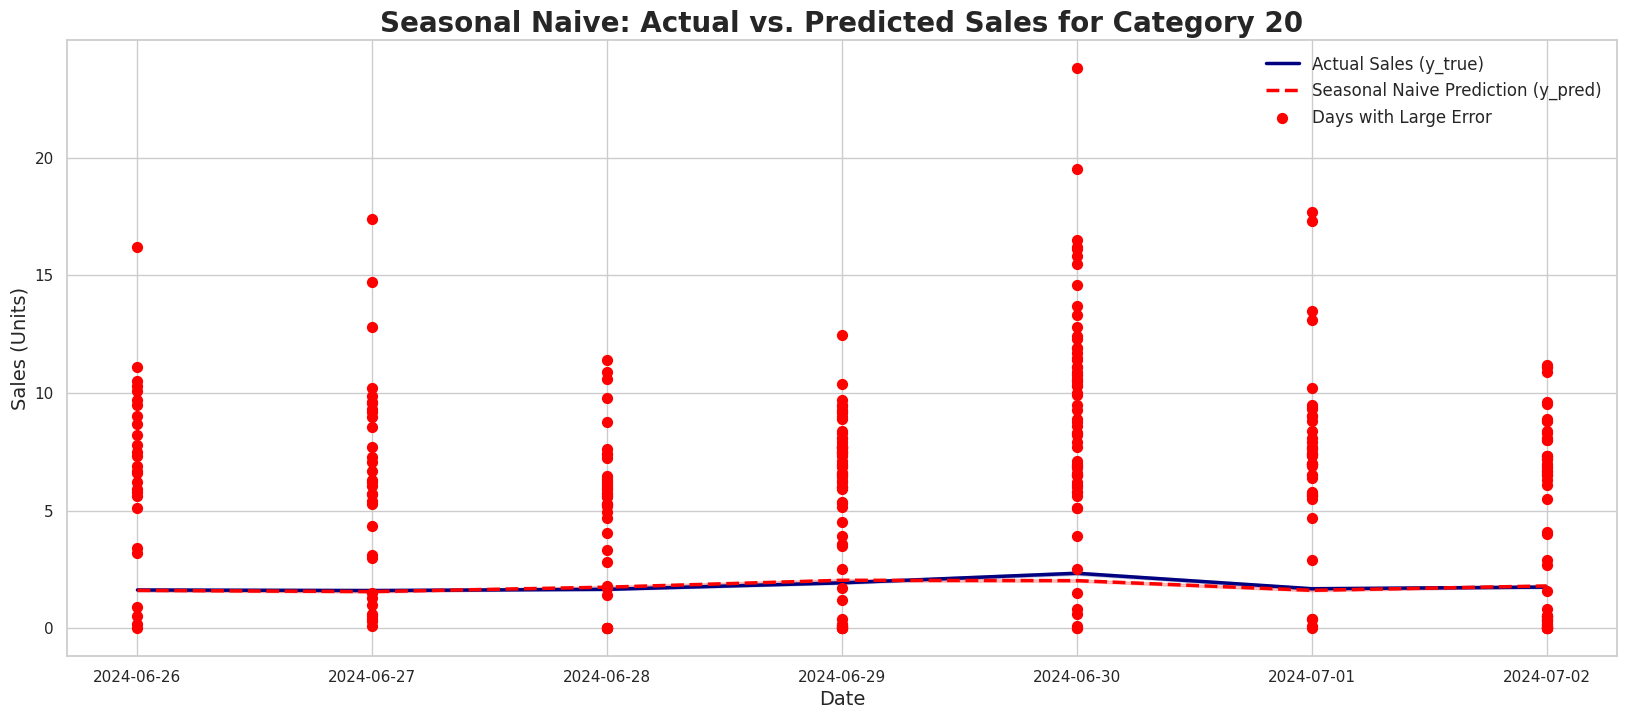

In [ ]:
# ===================================================================
# CELL: Time-Series Deep-Dive for the Baseline's Worst Category (Consistent Style)
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Isolate the data and define the category to investigate ---
# From your box plot, Category 20 had the largest error range.
category_to_investigate = 20
df_to_plot = baseline_analysis_df[baseline_analysis_df['first_category_id'] == category_to_investigate].copy()

print(f"--- Deep-Dive Analysis for Category {category_to_investigate} (Seasonal Naive) ---")

# --- Step 2: Define and identify the days with the largest errors ---
# A large error for the baseline can be a huge under-prediction OR a huge over-prediction.
# We will use the absolute error to find these "spike" days.
# You can adjust this threshold based on your sales volume. A value around 5-10 is often a good start.
error_threshold = 5
spike_days = df_to_plot[df_to_plot['abs_error'] > error_threshold]

# --- Step 3: Create the visualization with a consistent style ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 8))

# Plot the Actual Sales (consistent style: navy blue, solid)
sns.lineplot(data=df_to_plot, x='date', y='y_true', label='Actual Sales (y_true)', color='navy', linewidth=2.5)

# Plot the Seasonal Naive Prediction (consistent style: dashed, but RED to differentiate from XGBoost's orange)
sns.lineplot(data=df_to_plot, x='date', y='y_pred', label='Seasonal Naive Prediction (y_pred)', color='red', linestyle='--', linewidth=2.5)

# Highlight the days with large errors (consistent style: large red dots)
if not spike_days.empty:
    # We plot the red dots on the 'y_true' line to show the actual sales on the days the model failed badly.
    plt.scatter(spike_days['date'], spike_days['y_true'], color='red', s=50, zorder=5, label='Days with Large Error')

# --- Titles and Labels (consistent style) ---
plt.title(f'Seasonal Naive: Actual vs. Predicted Sales for Category {category_to_investigate}', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales (Units)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [ ]:
# ===================================================================
# CELL: Compare Volatility of Good vs. Bad Categories
# ===================================================================

# --- Define a good and a bad category from your box plot ---
bad_category_id = 20
good_category_id = 2 # Category 2 has a very tight error distribution

# --- Calculate the Coefficient of Variation (a measure of volatility) ---
# We use the original, clean test data for this
volatility_bad = test_data_clean[test_data_clean['first_category_id'] == bad_category_id]['y'].std() / test_data_clean[test_data_clean['first_category_id'] == bad_category_id]['y'].mean()
volatility_good = test_data_clean[test_data_clean['first_category_id'] == good_category_id]['y'].std() / test_data_clean[test_data_clean['first_category_id'] == good_category_id]['y'].mean()

print("--- Volatility Comparison (Coefficient of Variation) ---")
print(f"  Volatility for BAD Category ({bad_category_id}): {volatility_bad:.2f}")
print(f"  Volatility for GOOD Category ({good_category_id}): {volatility_good:.2f}")

if volatility_bad > volatility_good:
    print("\nConclusion: The high-error category is significantly more volatile than the low-error category.")

--- Volatility Comparison (Coefficient of Variation) ---
  Volatility for BAD Category (20): 1.07
  Volatility for GOOD Category (2): 0.77

Conclusion: The high-error category is significantly more volatile than the low-error category.



--- Analyzing Baseline's Daily Mean Absolute Error Over Time ---


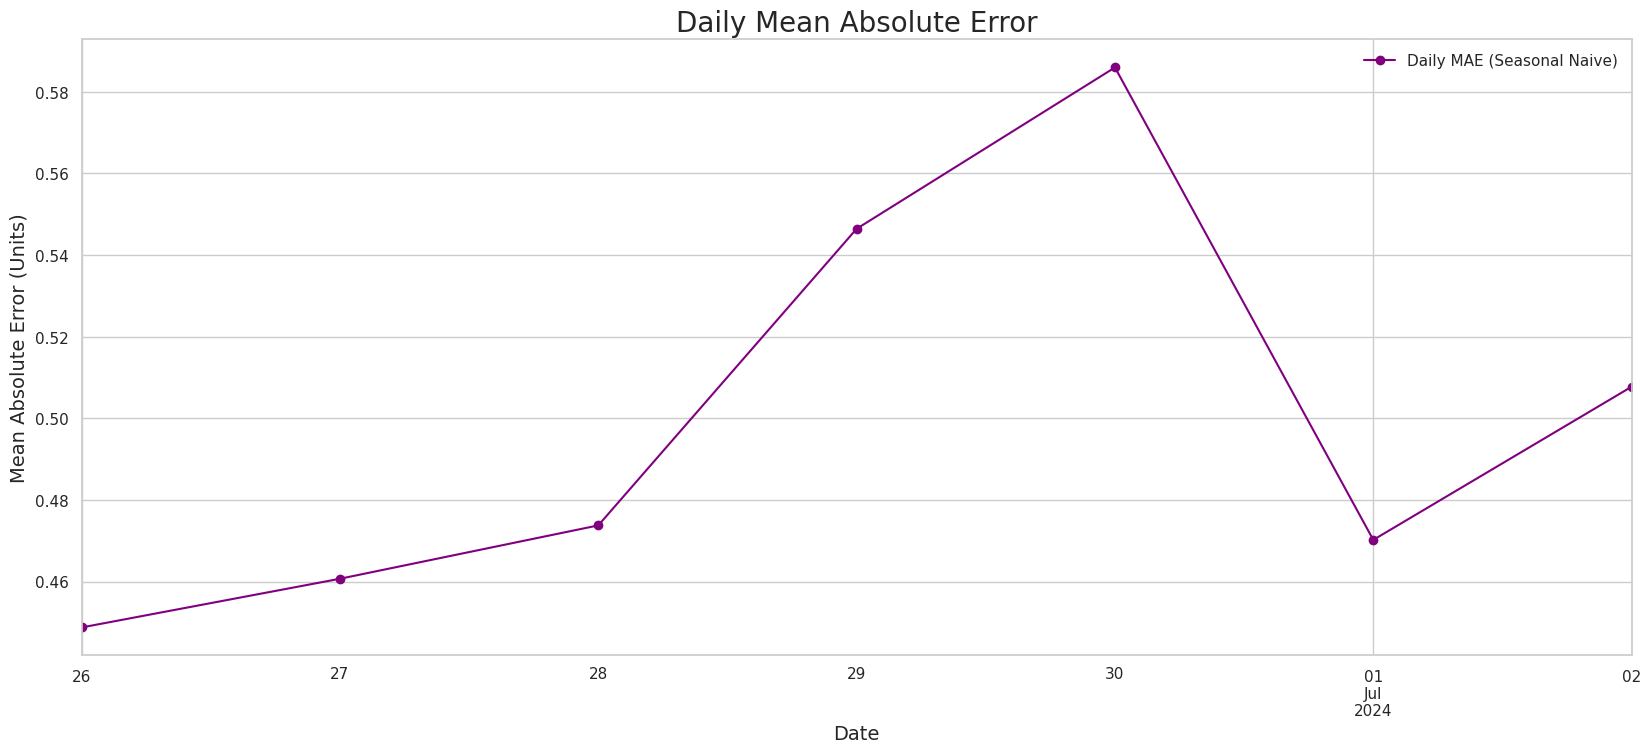

In [ ]:
# ===================================================================
# CELL 4: Analyze Error Over the Test Time Horizon
# ===================================================================

print("\n--- Analyzing Baseline's Daily Mean Absolute Error Over Time ---")

# Group by date and calculate the Mean Absolute Error for each day
daily_mae_baseline = baseline_analysis_df.groupby('date')['abs_error'].mean()

plt.figure(figsize=(20, 8))
daily_mae_baseline.plot(kind='line', marker='o', color='purple', label='Daily MAE (Seasonal Naive)')

plt.title('Daily Mean Absolute Error', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Mean Absolute Error (Units)', fontsize=14)
plt.legend()
plt.show()

In [ ]:
# ===================================================================
# CELL 5: Deep-Dive Investigation into a High-Error Date
# ===================================================================
import pandas as pd

date_to_investigate = pd.to_datetime('2024-06-30') # Change this date if needed
day_of_spike = baseline_analysis_df[baseline_analysis_df['date'] == date_to_investigate]
worst_preds_on_spike_day = day_of_spike.sort_values(by='abs_error', ascending=False).head(10)

print(f"--- Top 10 Largest Errors on {date_to_investigate.date()} (with Full Feature Context) ---")

display_cols = [
    'sku_store_id', 'y_true', 'y_pred', 'error', 'abs_error', 'first_category_id', 'dow',
    'promo_strategy_Non-Price Promo', 'promo_strategy_Price Penetration',
    'promo_strategy_Standard Discount', 'discount_depth', 'stockout_ratio_d',
    'stockout_ratio_lag1d', 'log_y_lag_1d'
]
display_cols = [col for col in display_cols if col in worst_preds_on_spike_day.columns]
print(worst_preds_on_spike_day[display_cols].to_string())

--- Top 10 Largest Errors on 2024-06-30 (with Full Feature Context) ---
       sku_store_id  y_true  y_pred  error  abs_error  first_category_id  promo_strategy_Non-Price Promo  promo_strategy_Price Penetration  promo_strategy_Standard Discount  discount_depth  stockout_ratio_d  stockout_ratio_lag1d  log_y_lag_1d
222410      267_538     1.2   17.50 -16.30      16.30                 21                             0.0                               1.0                               0.0             1.0          0.823529                   0.0      3.194583
243897      300_555    19.5    3.50  16.00      16.00                 20                             0.0                               0.0                               0.0             0.0          0.000000                   0.0      2.606387
241981      300_431    23.8    9.20  14.60      14.60                 20                             0.0                               0.0                               0.0             0.0          0

In [ ]:
# ===================================================================
# CELL: Deep-Dive Investigation into the June 30th Error Spike
# ===================================================================

import pandas as pd

# --- Step 1: Isolate all the predictions made for the specific date ---
date_to_investigate = pd.to_datetime('2024-06-30')
day_of_spike = baseline_analysis_df[baseline_analysis_df['date'] == date_to_investigate]

print(f"--- Investigation for Date: {date_to_investigate.date()} ---")
print(f"Total predictions on this day: {len(day_of_spike)}")
print(f"Average Absolute Error (MAE) on this day: {day_of_spike['abs_error'].mean():.4f}")


# --- Step 2: Find the top 10 worst predictions on that day ---
# This will tell us if the error is concentrated in a few bad predictions.
worst_preds_on_spike_day = day_of_spike.sort_values(by='abs_error', ascending=False).head(10)

print("\n--- Top 10 Largest Errors on this Date ---")

# Display the most relevant columns
display_cols = ['date', 'sku_store_id', 'y_true', 'y_pred', 'error', 'abs_error', 'first_category_id', 'promo_strategy']
# Filter out columns that might not exist to avoid errors
display_cols = [col for col in display_cols if col in worst_preds_on_spike_day.columns]

print(worst_preds_on_spike_day[display_cols].to_string())


# --- Step 3: Analyze the nature of the errors ---
num_under_predictions = (worst_preds_on_spike_day['error'] > 0).sum()
num_over_predictions = (worst_preds_on_spike_day['error'] < 0).sum()

print("\n--- Summary of the Top 10 Errors ---")
print(f"Number of significant UNDER-predictions (y_true > y_pred): {num_under_predictions}")
print(f"Number of significant OVER-predictions (y_true < y_pred): {num_over_predictions}")

--- Investigation for Date: 2024-06-30 ---
Total predictions on this day: 50000
Average Absolute Error (MAE) on this day: 0.5860

--- Top 10 Largest Errors on this Date ---
             date sku_store_id  y_true  y_pred  error  abs_error  first_category_id
222410 2024-06-30      267_538     1.2   17.50 -16.30      16.30                 21
243897 2024-06-30      300_555    19.5    3.50  16.00      16.00                 20
241981 2024-06-30      300_431    23.8    9.20  14.60      14.60                 20
242052 2024-06-30      300_145    15.8    2.10  13.70      13.70                 20
242628 2024-06-30       300_34    13.3    0.00  13.30      13.30                 20
243571 2024-06-30      300_822    15.5    2.60  12.90      12.90                 20
243764 2024-06-30      300_552    11.9    0.10  11.80      11.80                 20
242813 2024-06-30      300_191    11.9    0.20  11.70      11.70                 20
242351 2024-06-30      300_231    11.1    0.00  11.10      11.10       

In [ ]:
# ===================================================================
# CELL: Comprehensive Deep-Dive Investigation into the June 30th Error Spike
# ===================================================================
import pandas as pd

# --- Step 1: Isolate all the predictions made for the specific date ---
date_to_investigate = pd.to_datetime('2024-06-30')
day_of_spike = baseline_analysis_df[baseline_analysis_df['date'] == date_to_investigate]

print(f"--- Investigation for Date: {date_to_investigate.date()} ---")
print(f"Total predictions on this day: {len(day_of_spike)}")
print(f"Average Absolute Error (MAE) on this day: {day_of_spike['abs_error'].mean():.4f}")


# --- Step 2: Find the top 10 worst predictions on that day ---
worst_preds_on_spike_day = day_of_spike.sort_values(by='abs_error', ascending=False).head(10)

print("\n--- Top 10 Largest Errors on this Date (with Full Feature Context) ---")

# --- THIS IS THE KEY CHANGE ---
# Define a comprehensive list of columns to display for a full diagnosis.
# This includes the core error metrics and your key engineered features.
display_cols = [
    # Core Metrics
    'sku_store_id',
    'y_true',
    'y_pred',
    'error',
    'abs_error',

    # Category / Day Features
    'first_category_id',
    'dow', # Day of Week (0=Mon, 6=Sun)

    # Promotion Features
    'promo_strategy',
    'discount_depth',

    # Stockout Features
    'stockout_ratio_d',      # Stockout ratio for the CURRENT day
    'stockout_ratio_lag1d',  # Stockout ratio for the PREVIOUS day

    # Lagged/Rolling Sales Features
    'log_y_lag_1d',          # Yesterday's sales (log scale)
    'log_y_lag_7d',          # Last week's sales (log scale) - THIS IS y_pred!
    'log_y_roll_mean_7d'     # Rolling 7-day average of sales
]

# Filter out any columns that might not exist in the dataframe to prevent errors
display_cols = [col for col in display_cols if col in worst_preds_on_spike_day.columns]

# Print the detailed table
print(worst_preds_on_spike_day[display_cols].to_string())


# --- Step 3: Analyze the nature of the errors ---
num_under_predictions = (worst_preds_on_spike_day['error'] > 0).sum()
num_over_predictions = (worst_preds_on_spike_day['error'] < 0).sum()

print("\n--- Summary of the Top 10 Errors ---")
print(f"Number of significant UNDER-predictions (y_true > y_pred): {num_under_predictions}")
print(f"Number of significant OVER-predictions (y_true < y_pred): {num_over_predictions}")

--- Investigation for Date: 2024-06-30 ---
Total predictions on this day: 50000
Average Absolute Error (MAE) on this day: 0.5860

--- Top 10 Largest Errors on this Date (with Full Feature Context) ---
       sku_store_id  y_true  y_pred  error  abs_error  first_category_id  discount_depth  stockout_ratio_d  stockout_ratio_lag1d  log_y_lag_1d  log_y_lag_7d  log_y_roll_mean_7d
222410      267_538     1.2   17.50 -16.30      16.30                 21             1.0          0.823529                   0.0      3.194583      2.917771            2.875876
243897      300_555    19.5    3.50  16.00      16.00                 20             0.0          0.000000                   0.0      2.606387      1.504077            1.995068
241981      300_431    23.8    9.20  14.60      14.60                 20             0.0          0.000000                   0.0      2.509599      2.322388            2.526990
242052      300_145    15.8    2.10  13.70      13.70                 20             0.0   

In [ ]:
# ===================================================================
# CELL: Comprehensive Deep-Dive with PROMOTION Details
# ===================================================================
import pandas as pd

# --- Step 1: Isolate all the predictions made for the specific date ---
date_to_investigate = pd.to_datetime('2024-06-30')
day_of_spike = baseline_analysis_df[baseline_analysis_df['date'] == date_to_investigate]

print(f"--- Investigation for Date: {date_to_investigate.date()} ---")
print(f"Total predictions on this day: {len(day_of_spike)}")
print(f"Average Absolute Error (MAE) on this day: {day_of_spike['abs_error'].mean():.4f}")


# --- Step 2: Find the top 10 worst predictions on that day ---
worst_preds_on_spike_day = day_of_spike.sort_values(by='abs_error', ascending=False).head(10)

print("\n--- Top 10 Largest Errors on this Date (with Full Feature Context) ---")

# --- THIS IS THE KEY CHANGE ---
# We now include the one-hot encoded promotion columns.
display_cols = [
    # Core Metrics
    'sku_store_id', 'y_true', 'y_pred', 'error', 'abs_error',

    # Category / Day Features
    'first_category_id', 'dow',

    # Promotion Features (One-Hot Encoded)
    'promo_strategy_Non-Price Promo',
    'promo_strategy_Price Penetration',
    'promo_strategy_Standard Discount',
    'discount_depth',

    # Stockout & Lagged Features
    'stockout_ratio_d', 'stockout_ratio_lag1d', 'log_y_lag_1d'
]

# Filter out any columns that might not exist to prevent errors
# (This is important in case one of the promo types never appears in the top 10)
display_cols = [col for col in display_cols if col in worst_preds_on_spike_day.columns]

# Print the detailed table
print(worst_preds_on_spike_day[display_cols].to_string())

--- Investigation for Date: 2024-06-30 ---
Total predictions on this day: 50000
Average Absolute Error (MAE) on this day: 0.5860

--- Top 10 Largest Errors on this Date (with Full Feature Context) ---
       sku_store_id  y_true  y_pred  error  abs_error  first_category_id  promo_strategy_Non-Price Promo  promo_strategy_Price Penetration  promo_strategy_Standard Discount  discount_depth  stockout_ratio_d  stockout_ratio_lag1d  log_y_lag_1d
222410      267_538     1.2   17.50 -16.30      16.30                 21                             0.0                               1.0                               0.0             1.0          0.823529                   0.0      3.194583
243897      300_555    19.5    3.50  16.00      16.00                 20                             0.0                               0.0                               0.0             0.0          0.000000                   0.0      2.606387
241981      300_431    23.8    9.20  14.60      14.60                 

--- Generating the Predictive Behavior distribution for the Seasonal Naive Baseline ---


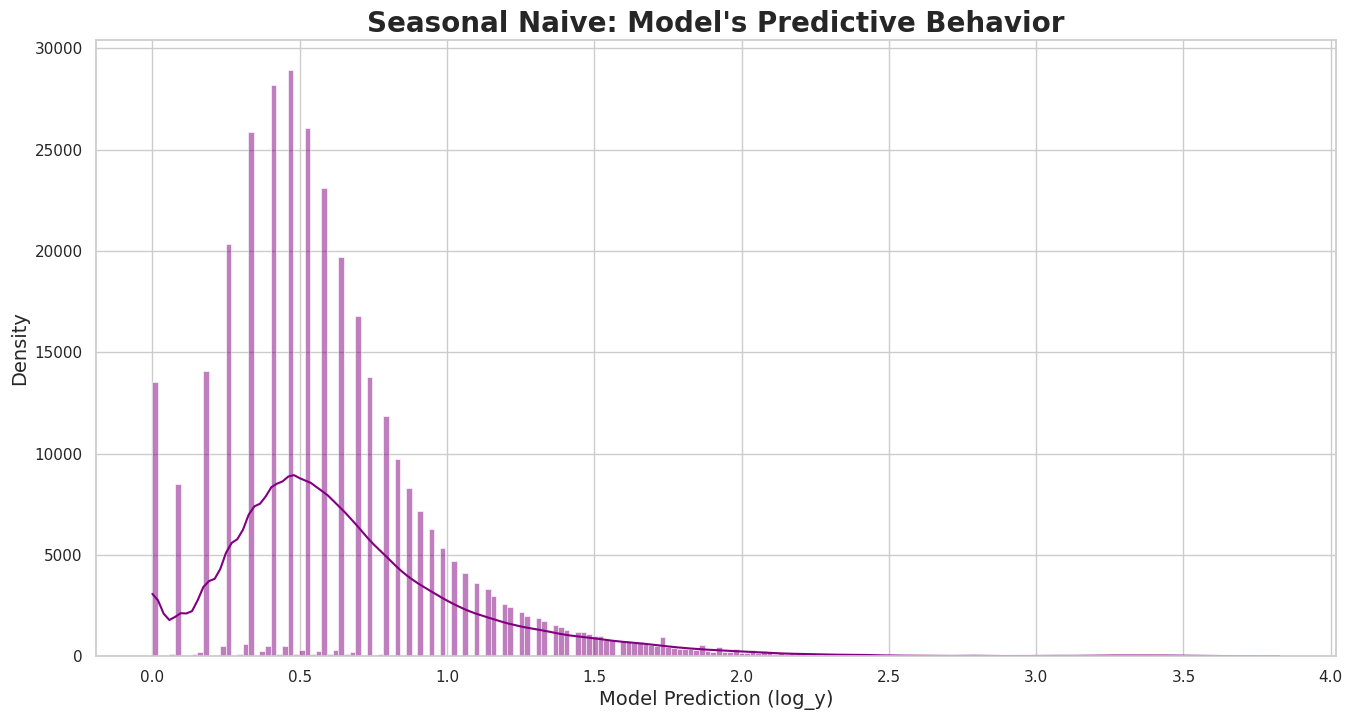

In [ ]:
# ===================================================================
# CELL: Visualize the Seasonal Naive Model's Predictive Behavior
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Generating the Predictive Behavior distribution for the Seasonal Naive Baseline ---")

# --- Set the plotting style ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))

# --- Create the histogram and density plot ---
# We use the log-transformed predictions ('log_y_pred') from our analysis dataframe.
# A high number of bins helps to see the shape clearly.
sns.histplot(baseline_analysis_df['log_y_pred'], kde=True, color='purple', bins=200)

# --- Titles and Labels (consistent with your other plots) ---
plt.title("Seasonal Naive: Model's Predictive Behavior", fontsize=20, fontweight='bold')
plt.xlabel("Model Prediction (log_y)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()

--- Generating Predicted vs. Actual plot for the Baseline Model ---


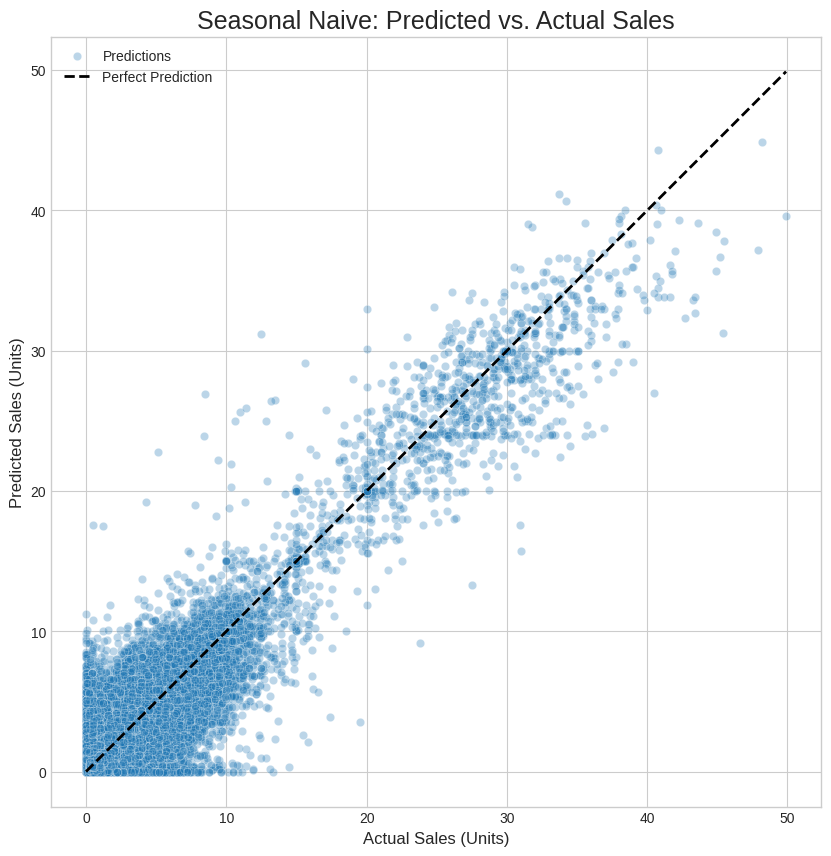

In [ ]:
# ===================================================================
# CELL: Predicted vs. Actual Analysis for the Baseline Model
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Generating Predicted vs. Actual plot for the Baseline Model ---")

# We use the original scale data for the most intuitive interpretation
df_to_plot = baseline_analysis_df.copy()

plt.figure(figsize=(10, 10)) # Use a square figure for a better aspect ratio

# Create the scatter plot
sns.scatterplot(
    x='y_true',
    y='y_pred',
    data=df_to_plot,
    alpha=0.3, # Use transparency to see the density of points
    label='Predictions'
)

# --- Create the "Perfect Prediction" line ---
# Find the minimum and maximum values for the axes to create a perfect diagonal line
min_val = min(df_to_plot['y_true'].min(), df_to_plot['y_pred'].min())
max_val = max(df_to_plot['y_true'].max(), df_to_plot['y_pred'].max())

# Plot the y=x line
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=2, label='Perfect Prediction')

# --- Titles and Labels ---
plt.title('Seasonal Naive: Predicted vs. Actual Sales', fontsize=18)
plt.xlabel('Actual Sales (Units)', fontsize=12)
plt.ylabel('Predicted Sales (Units)', fontsize=12)
plt.legend()

# IMPORTANT: Make the plot square so the diagonal line looks correct
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [39]:
# Ensure the model and test data are loaded and ready

# 1. Generate the predictions (this is the line that was missing before)
final_predictions_log = champion_model_xgb.predict(X_test)
print("Prediction step executed successfully.")

# 2. Now run the diagnostics
print("\n--- Verifying Target Variable Ranges ---")
print(f"Training target (log_y) range: {y_full_train.min():.4f} to {y_full_train.max():.4f}")
print(f"Test target (log_y) range:     {y_test.min():.4f} to {y_test.max():.4f}")
print(f"Prediction (log_y) range:      {final_predictions_log.min():.4f} to {final_predictions_log.max():.4f}")

Prediction step executed successfully.

--- Verifying Target Variable Ranges ---
Training target (log_y) range: 0.0000 to 3.8265
Test target (log_y) range:     0.0000 to 3.9299
Prediction (log_y) range:      -0.1076 to 3.2142


In [41]:
print("--- Statistical Summary of XGBoost Actuals ---")
# Ensure the y_true column is calculated if it's not already
if 'y_true' not in xgb_analysis_df.columns:
    xgb_analysis_df['y_true'] = np.expm1(xgb_analysis_df['log_y_true'])
print(xgb_analysis_df['y_true'].describe())

print("\n" + "="*50 + "\n")

print("--- Statistical Summary of Seasonal Naive (Baseline) Actuals ---")
# The variable for your baseline model's analysis data is 'baseline_analysis_df'
# based on your plotting code
print(baseline_analysis_df['y_true'].describe())

--- Statistical Summary of XGBoost Actuals ---
count    25088.000000
mean         0.880291
std          0.746075
min          0.000000
25%          0.400000
50%          0.700000
75%          1.100000
max          9.200000
Name: y_true, dtype: float64


--- Statistical Summary of Seasonal Naive (Baseline) Actuals ---
count    350000.000000
mean          1.193053
std           1.911597
min           0.000000
25%           0.400000
50%           0.800000
75%           1.300000
max          49.900000
Name: y_true, dtype: float64


In [42]:
# After you create train_df_final, val_df_final, test_df_final...
print(f"Train shape: {train_df_final.shape}")
print(f"Validation shape: {val_df_final.shape}")
print(f"Test shape: {test_df_final.shape}")

Train shape: (3400000, 33)
Validation shape: (750000, 33)
Test shape: (350000, 33)


In [43]:
# 5. Create and Save the Detailed Analysis DataFrame (for visualizations)
print("Creating detailed analysis DataFrame...")

# Create a dataframe with predictions and true values (350,000 rows)
xgb_predictions_df = pd.DataFrame({
    'log_y_true': y_test,
    'log_y_pred': final_predictions_log
}, index=X_test.index)

# CORRECTED: Merge with the FULL test set dataframe
xgb_analysis_df = pd.merge(
    xgb_predictions_df,
    test_df_final, # Use the correct, full-sized dataframe
    left_index=True,
    right_index=True,
    how='inner'
)

# Calculate error columns
xgb_analysis_df['y_true'] = np.expm1(xgb_analysis_df['log_y_true'])
xgb_analysis_df['y_pred'] = np.expm1(xgb_analysis_df['log_y_pred'])
xgb_analysis_df['error'] = xgb_analysis_df['y_true'] - xgb_analysis_df['y_pred']
xgb_analysis_df['abs_error'] = xgb_analysis_df['error'].abs()

# Now, this shape should be 350,000
print(f"Shape of the final analysis DataFrame: {xgb_analysis_df.shape}")

DETAILED_ANALYSIS_PATH = os.path.join(MODEL_DIR, "champion_xgb_ANALYSIS_data.csv")
xgb_analysis_df.to_csv(DETAILED_ANALYSIS_PATH, index=False)
print(f"✅ Detailed analysis data for visualizations saved to: {DETAILED_ANALYSIS_PATH}")

Creating detailed analysis DataFrame...
Shape of the final analysis DataFrame: (350000, 39)
✅ Detailed analysis data for visualizations saved to: /content/drive/MyDrive/XGBoost_Champion_Model/champion_xgb_ANALYSIS_data.csv


In [45]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

# ===================================================================
# SECTION 1: PREDICTION & METRIC CALCULATION (This part was already correct)
# ===================================================================
print("--- Making predictions on the full test set ---")

# Ensure your model and data (X_test, y_test) are loaded and available
# X_test and y_test should both have 350,000 rows
final_predictions_log = champion_model_xgb.predict(X_test)
print(f"Prediction complete. Generated {len(final_predictions_log)} predictions.")

# Prepare true values for metric calculation
y_true_log = y_test
y_true_orig = np.expm1(y_true_log)
y_pred_orig = np.expm1(final_predictions_log)

# Calculate metrics on the full 350,000-row test set
print("\n--- Calculating final performance metrics ---")
final_rmse_log = np.sqrt(mean_squared_error(y_true_log, final_predictions_log))
final_wape = np.sum(np.abs(y_true_orig - y_pred_orig)) / (np.sum(y_true_orig) + 1e-9)
final_mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
final_rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))

champion_xgb_results = {
    'LOG RMSE': final_rmse_log, 'WAPE': final_wape, 'MAE': final_mae_orig, 'RMSE': final_rmse_orig
}
results_df = pd.DataFrame({'XGBoost Champion (on Test)': champion_xgb_results}).T
print(results_df.to_string(formatters={'WAPE':'{:.2%}'.format}))


# ===================================================================
# SECTION 2: CREATE AND SAVE THE DETAILED ANALYSIS DATAFRAME (This section is now corrected)
# ===================================================================
print("\n--- Creating detailed analysis DataFrame for visualizations ---")

# Create a dataframe with predictions and true values (will have 350,000 rows)
xgb_predictions_df = pd.DataFrame({
    'log_y_true': y_test,
    'log_y_pred': final_predictions_log
}, index=X_test.index)

# BUG FIX: Merge with the FULL test dataframe `test_df_final`, NOT the old `test_df_analysis`.
# This ensures we keep all 350,000 rows.
xgb_analysis_df = pd.merge(
    xgb_predictions_df,
    test_df_final,  # <--- THIS IS THE FIX
    left_index=True,
    right_index=True,
    how='inner'
)

# Add the calculated columns for easier analysis and plotting
# Note: Some columns like 'log_y' might already exist from test_df_final, which is fine.
# We recalculate 'y_true' and 'y_pred' from the merged data to be certain.
xgb_analysis_df['y_true'] = np.expm1(xgb_analysis_df['log_y_true'])
xgb_analysis_df['y_pred'] = np.expm1(xgb_analysis_df['log_y_pred'])
xgb_analysis_df['error'] = xgb_analysis_df['y_true'] - xgb_analysis_df['y_pred']
xgb_analysis_df['abs_error'] = xgb_analysis_df['error'].abs()

# Verification step: Check the shape to confirm the fix worked.
print(f"Shape of the final analysis DataFrame: {xgb_analysis_df.shape}")
print(f"Max 'y_true' in final analysis DataFrame: {xgb_analysis_df['y_true'].max()}")

# Define your save directory and save the corrected file
MODEL_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model"
DETAILED_ANALYSIS_PATH = os.path.join(MODEL_DIR, "champion_xgb_ANALYSIS_data_CORRECTED.csv")
xgb_analysis_df.to_csv(DETAILED_ANALYSIS_PATH, index=False)
print(f"✅ Corrected detailed analysis data saved to: {DETAILED_ANALYSIS_PATH}")

--- Making predictions on the full test set ---
Prediction complete. Generated 350000 predictions.

--- Calculating final performance metrics ---
                            LOG RMSE   WAPE       MAE      RMSE
XGBoost Champion (on Test)  0.187893 29.28%  0.349346  0.802428

--- Creating detailed analysis DataFrame for visualizations ---
Shape of the final analysis DataFrame: (350000, 39)
Max 'y_true' in final analysis DataFrame: 49.9
✅ Corrected detailed analysis data saved to: /content/drive/MyDrive/XGBoost_Champion_Model/champion_xgb_ANALYSIS_data_CORRECTED.csv


## Save the model

In [ ]:
# ===================================================================
# ADD-ON: Save the DETAILED ANALYSIS DataFrame to Google Drive
# ===================================================================
from google.colab import drive
import os

# This assumes 'baseline_analysis_df' has just been created in the cell above.

print("\n--- Saving the DETAILED baseline analysis data to Google Drive ---")

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define the path where you want to save the data
RESULTS_DIR = "/content/drive/MyDrive/Colab_Results"
ANALYSIS_DATA_PATH = os.path.join(RESULTS_DIR, "seasonal_naive_ANALYSIS_data.csv")

# 3. Create the directory if it doesn't exist
os.makedirs(RESULTS_DIR, exist_ok=True)

# 4. Save the 'baseline_analysis_df' to a CSV file.
#    index=False is good here as the default index is not meaningful.
baseline_analysis_df.to_csv(ANALYSIS_DATA_PATH, index=False)

print(f"\n✅ Detailed analysis data has been permanently saved to: {ANALYSIS_DATA_PATH}")


--- Saving the DETAILED baseline analysis data to Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Detailed analysis data has been permanently saved to: /content/drive/MyDrive/Colab_Results/seasonal_naive_ANALYSIS_data.csv


In [42]:
# ===================================================================
# CELL: Load the DETAILED Analysis Data from Google Drive
# ===================================================================
import pandas as pd
import os
from google.colab import drive

print("--- Loading the DETAILED baseline analysis data from Google Drive ---")

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define the path to your saved data file
ANALYSIS_DATA_PATH = "/content/drive/MyDrive/Colab_Results/seasonal_naive_ANALYSIS_data.csv"

# 3. Check if the file exists and then load it
if not os.path.exists(ANALYSIS_DATA_PATH):
    raise FileNotFoundError(f"Analysis data file not found at {ANALYSIS_DATA_PATH}.")

# Load the CSV. Tell pandas to parse the 'date' column correctly.
baseline_analysis_df = pd.read_csv(ANALYSIS_DATA_PATH, parse_dates=['date'])

print("✅ Detailed analysis data loaded into 'baseline_analysis_df'. You can now run your visualization cells.")

# --- You can now run ANY of your plotting cells, for example: ---
# (Just copy-paste one of your visualization cells here)
print("\n--- Example: Generating Box Plot for Top 10 Worst Categories ---")
# ... (your box plot code) ...

--- Loading the DETAILED baseline analysis data from Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Detailed analysis data loaded into 'baseline_analysis_df'. You can now run your visualization cells.

--- Example: Generating Box Plot for Top 10 Worst Categories ---


In [ ]:
from google.colab import drive
import os

print("\n--- Saving Final Test Set baseline results to Google Drive ---")

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define the path where you want to save the results
RESULTS_DIR = "/content/drive/MyDrive/Colab_Results"
RESULTS_PATH = os.path.join(RESULTS_DIR, "seasonal_naive_test_results.csv")

# 3. Create the directory if it doesn't exist
os.makedirs(RESULTS_DIR, exist_ok=True)

# 4. Save the 'test_results_table' DataFrame to a CSV file.
#    The index=True is CRITICAL to save the model name.
test_results_table.to_csv(RESULTS_PATH, index=True)

print(f"\n✅ Test baseline results permanently saved to: {RESULTS_PATH}")
# ===================================================================


--- Saving Final Test Set baseline results to Google Drive ---
Mounted at /content/drive

✅ Test baseline results permanently saved to: /content/drive/MyDrive/Colab_Results/seasonal_naive_test_results.csv


In [ ]:
# ===================================================================
# CELL: Load Saved Seasonal Naive TEST Results from Google Drive
# This runs in seconds in any new session.
# ===================================================================
import pandas as pd
import os
from google.colab import drive

print("--- Loading FINAL baseline results from Google Drive ---")

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define the path to your saved results file
#    This MUST be the exact same path you used to save it.
RESULTS_PATH = "/content/drive/MyDrive/Colab_Results/seasonal_naive_test_results.csv"

# 3. Check if the file exists and load it
if not os.path.exists(RESULTS_PATH):
    raise FileNotFoundError(f"Results file not found at {RESULTS_PATH}. Please ensure you have run the saving script first.")

# Load the CSV. The index_col=0 tells pandas that the first column is our index ('Seasonal Naive (on Test)').
test_results_table = pd.read_csv(RESULTS_PATH, index_col=0)

print("✅ Final baseline results loaded successfully from Drive.")


# --- 4. Display the Loaded Table ---
# This will look exactly like your original output.
print("\n" + "="*50)
print("--- FINAL SEASONAL NAIVE PERFORMANCE (on Test Set) ---")
print("="*50)
print(test_results_table.to_string(formatters={'WAPE':'{:.2%}'.format}))

# XGBoost

In [23]:
train_df_final = train_df_final.sort_values(['sku_store_id', 'date']).reset_index(drop=True)
val_df_final = val_df_final.sort_values(['sku_store_id', 'date']).reset_index(drop=True)
test_df_final = test_df_final.sort_values(['sku_store_id', 'date']).reset_index(drop=True)

In [24]:
TARGET = 'log_y'
ALL_POSSIBLE_FEATURES = train_df_final.columns.tolist()


COLUMNS_TO_DROP = [ 'log_y','y', 'date', 'sku_store_id', 'precpt', 'avg_humidity', 'avg_temperature', 'avg_wind_level']


FEATURES = [f for f in ALL_POSSIBLE_FEATURES if f not in COLUMNS_TO_DROP]
print(f"Using {len(FEATURES)} final features for the model.")

print("\n--- Step 1b: Creating Final Data Splits for Modeling ---")
X_train = train_df_final[FEATURES]
y_train = train_df_final[TARGET]

X_val = val_df_final[FEATURES]
y_val = val_df_final[TARGET]

X_test = test_df_final[FEATURES]
y_test = test_df_final[TARGET]

X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

print("\nData Shapes for Modeling:")
print(f"   - Training features shape:   {X_train.shape}")
print(f"   - Validation features shape: {X_val.shape}")
print(f"   - Test features shape:       {X_test.shape}")
print(f"   - Full training shape:       {X_full_train.shape}")


Using 25 final features for the model.

--- Step 1b: Creating Final Data Splits for Modeling ---

Data Shapes for Modeling:
   - Training features shape:   (3400000, 25)
   - Validation features shape: (750000, 25)
   - Test features shape:       (350000, 25)
   - Full training shape:       (4150000, 25)


In [ ]:
# Instantiate the model with default parameters
untuned_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Fit (Train) the model only on the training set
untuned_model.fit(X_train, y_train)

# predict on the validation set
val_predictions_log = untuned_model.predict(X_val)

# evaluate the performance
print("\nPerformance of Untuned XGBoost on Validation Set")

# Convert target and predictions back to original scale
y_true_orig = np.expm1(y_val)
y_pred_orig = np.expm1(val_predictions_log)

# Calculate metrics
log_rmse = np.sqrt(mean_squared_error(y_val, val_predictions_log))
wape = np.sum(np.abs(y_true_orig - y_pred_orig)) / np.sum(y_true_orig)
mae = mean_absolute_error(y_true_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))

print(f"  LOG RMSE: {log_rmse:.4f}")
print(f"  WAPE:     {wape:.2%}")
print(f"  MAE:      {mae:.4f}")
print(f"  RMSE:     {rmse:.4f}")


Performance of Untuned XGBoost on Validation Set
  LOG RMSE: 0.1876
  WAPE:     29.19%
  MAE:      0.3270
  RMSE:     0.6748


In [ ]:
# Hyperparameter Tuning

X_tune = pd.concat([X_train, X_val])
y_tune = pd.concat([y_train, y_val])

def objective_cv(trial):
    params = {
        'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'random_state': 42, 'n_jobs': -1,
        'booster': 'gbtree',
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 5.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True), # L2 regularization
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),  # L1 regularization
    }

    N_SPLITS = 4
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    scores = []

    for train_index, val_index in tscv.split(X_tune):
        X_train_fold, X_val_fold = X_tune.iloc[train_index], X_tune.iloc[val_index]
        y_train_fold, y_val_fold = y_tune.iloc[train_index], y_tune.iloc[val_index]


        # Convert data to DMatrix
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)

        pruning_callback = XGBoostPruningCallback(trial, "validation-rmse")

        # Use xgb.train which accepts callbacks
        model = xgb.train(
            params=params,
            dtrain=dtrain_fold,
            num_boost_round=2000,
            evals=[(dval_fold, 'validation')],
            callbacks=[pruning_callback],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        # Get the best score from the trained model object
        scores.append(model.best_score)


    return np.mean(scores)

N_TRIALS = 30

study_cv = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

with tqdm(total=N_TRIALS, desc="Optimizing Hyperparameters") as pbar:
    def tqdm_callback(study, trial):
        pbar.update(1)

    study_cv.optimize(objective_cv, n_trials=N_TRIALS, callbacks=[tqdm_callback])

print(f"Best validation RMSE (avg across folds): {study_cv.best_value:.4f}")
print("Best hyperparameters found:")
print(study_cv.best_params)

[I 2025-11-25 17:27:53,042] A new study created in memory with name: no-name-d64e3bf4-2756-47eb-806d-5e0820084434


Optimizing Hyperparameters:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-25 17:35:45,881] Trial 0 finished with value: 0.19325826982880928 and parameters: {'learning_rate': 0.023171758042400847, 'max_depth': 12, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'gamma': 2.2761531148837062e-07, 'min_child_weight': 4, 'lambda': 2.9152036385288193e-08, 'alpha': 0.08499808989182997}. Best is trial 0 with value: 0.19325826982880928.
[I 2025-11-25 17:37:53,471] Trial 1 finished with value: 0.19407502805940055 and parameters: {'learning_rate': 0.05859268690985102, 'max_depth': 10, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'gamma': 0.17433860342268107, 'min_child_weight': 5, 'lambda': 2.8483918709107956e-07, 'alpha': 2.9324868872723725e-07}. Best is trial 0 with value: 0.19325826982880928.
[I 2025-11-25 17:46:45,574] Trial 2 finished with value: 0.19396846737214396 and parameters: {'learning_rate': 0.01737635693697876, 'max_depth': 8, 'subsample': 0.7159725093210578, 'colsample_bytree': 0.645614570099

Best validation RMSE (avg across folds): 0.1933
Best hyperparameters found:
{'learning_rate': 0.023171758042400847, 'max_depth': 12, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'gamma': 2.2761531148837062e-07, 'min_child_weight': 4, 'lambda': 2.9152036385288193e-08, 'alpha': 0.08499808989182997}


In [ ]:
# Fit the Model

best_params_xgb = study_cv.best_params
best_params_xgb['random_state'] = 42
best_params_xgb['n_jobs'] = -1
best_params_xgb['objective'] = 'reg:squarederror'

# Instantiate the model with a high number of estimators for early stopping.
champion_model_xgb = xgb.XGBRegressor(
    n_estimators=2000,
    early_stopping_rounds=50,
    **best_params_xgb
)

champion_model_xgb.fit(
    X_full_train, y_full_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

[0]	validation_0-rmse:0.41849
[100]	validation_0-rmse:0.18401
[200]	validation_0-rmse:0.17037
[300]	validation_0-rmse:0.16474
[400]	validation_0-rmse:0.16060
[500]	validation_0-rmse:0.15762
[600]	validation_0-rmse:0.15502
[700]	validation_0-rmse:0.15299
[800]	validation_0-rmse:0.15112
[900]	validation_0-rmse:0.14942
[1000]	validation_0-rmse:0.14788
[1100]	validation_0-rmse:0.14641
[1200]	validation_0-rmse:0.14509
[1300]	validation_0-rmse:0.14380
[1400]	validation_0-rmse:0.14251
[1500]	validation_0-rmse:0.14134
[1600]	validation_0-rmse:0.14026
[1700]	validation_0-rmse:0.13923
[1800]	validation_0-rmse:0.13823
[1900]	validation_0-rmse:0.13724
[1999]	validation_0-rmse:0.13632


XGBRegressor(alpha=0.08499808989182997, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7993292420985183, device=None,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=2.2761531148837062e-07, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=2.9152036385288193e-08, learning_rate=0.023171758042400847,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, ...)

In [ ]:
final_predictions_log = champion_model_xgb.predict(X_test)
print("Prediction complete.")

y_true_log = y_test
y_true_orig = np.expm1(y_true_log)
y_pred_orig = np.expm1(final_predictions_log)

# Calculate metrics
final_rmse_log = np.sqrt(mean_squared_error(y_true_log, final_predictions_log))
final_wape = np.sum(np.abs(y_true_orig - y_pred_orig)) / (np.sum(y_true_orig) + 1e-9)
final_mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
final_rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)) # Added for completeness


champion_xgb_results = {
    'LOG RMSE': final_rmse_log, 'WAPE': final_wape, 'MAE': final_mae_orig, 'RMSE': final_rmse_orig
}

results_df = pd.DataFrame({
    'XGBoost Champion (on Test)': champion_xgb_results
}).T

print(results_df.to_string(formatters={'WAPE':'{:.2%}'.format}))

Prediction complete.
                            LOG RMSE   WAPE       MAE      RMSE
XGBoost Champion (on Test)  0.187893 29.28%  0.349346  0.802428


### save the model

In [53]:
# ===================================================================
# REPLACEMENT SECTION: Save EVERYTHING to Google Drive (Corrected)
# ===================================================================
import pandas as pd
import numpy as np
import joblib
import os
import json
from google.colab import drive

print("\n" + "="*50)
print("--- SAVING ALL ARTIFACTS TO GOOGLE DRIVE (WITH CORRECTIONS) ---")

# 1. Mount Google Drive (if not already mounted)
drive.mount('/content/drive')
MODEL_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model"
os.makedirs(MODEL_DIR, exist_ok=True)

# 2. Save the Trained Model Object (No change here)
MODEL_PATH = os.path.join(MODEL_DIR, "champion_xgb_model.joblib")
joblib.dump(champion_model_xgb, MODEL_PATH)
print(f"✅ Trained XGBoost model saved to: {MODEL_PATH}")

# 3. Save the Feature List (No change here)
FEATURES_PATH = os.path.join(MODEL_DIR, "model_features.json")
with open(FEATURES_PATH, 'w') as f:
    json.dump(FEATURES, f)
print(f"✅ Model feature list saved to: {FEATURES_PATH}")

# 4. Save the Final Summary Results Table (No change here)
SUMMARY_RESULTS_PATH = os.path.join(MODEL_DIR, "champion_xgb_results_SUMMARY.csv")
results_df.to_csv(SUMMARY_RESULTS_PATH, index=True)
print(f"✅ Final summary table saved to: {SUMMARY_RESULTS_PATH}")

# 5. Create and Save the CORRECTED Detailed Analysis DataFrame
print("\n--- Creating and saving the CORRECTED detailed analysis DataFrame ---")

# Create a dataframe with predictions and true values (from your full 350k test set)
xgb_predictions_df = pd.DataFrame({
    'log_y_true': y_test,
    'log_y_pred': final_predictions_log
}, index=X_test.index)

# =============================== THE BUG FIX IS HERE ===============================
# We are merging with the full `test_df_final` dataframe.
# This ensures the final analysis file contains all 350,000 test results.
xgb_analysis_df = pd.merge(
    xgb_predictions_df,
    test_df_final,  # <--- CORRECT: Using the full test set dataframe
    left_index=True,
    right_index=True,
    how='inner'
)
# =================================================================================

# Add the calculated columns for analysis
xgb_analysis_df['y_true'] = np.expm1(xgb_analysis_df['log_y_true'])
xgb_analysis_df['y_pred'] = np.expm1(xgb_analysis_df['log_y_pred'])
xgb_analysis_df['error'] = xgb_analysis_df['y_true'] - xgb_analysis_df['y_pred']
xgb_analysis_df['abs_error'] = xgb_analysis_df['error'].abs()

# Add a verification step to be 100% sure the fix worked before saving
print(f"Verifying shape of the analysis data to be saved: {xgb_analysis_df.shape}")
if xgb_analysis_df.shape[0] > 300000:
    print("✅ Verification successful! The dataframe has the full number of rows.")
else:
    print("🚨 WARNING: The dataframe is still small. The fix did not work as expected.")


# Give the corrected file a new name to avoid confusion
DETAILED_ANALYSIS_PATH = os.path.join(MODEL_DIR, "champion_xgb_ANALYSIS_data_CORRECTED.csv")
xgb_analysis_df.to_csv(DETAILED_ANALYSIS_PATH, index=False)
print(f"✅ Corrected detailed analysis data saved to: {DETAILED_ANALYSIS_PATH}")

print("\n\n🎉🎉🎉 ALL DONE. All corrected XGBoost artifacts are permanently saved. 🎉🎉🎉")


--- SAVING ALL ARTIFACTS TO GOOGLE DRIVE (WITH CORRECTIONS) ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Trained XGBoost model saved to: /content/drive/MyDrive/XGBoost_Champion_Model/champion_xgb_model.joblib
✅ Model feature list saved to: /content/drive/MyDrive/XGBoost_Champion_Model/model_features.json
✅ Final summary table saved to: /content/drive/MyDrive/XGBoost_Champion_Model/champion_xgb_results_SUMMARY.csv

--- Creating and saving the CORRECTED detailed analysis DataFrame ---
Verifying shape of the analysis data to be saved: (350000, 39)
✅ Verification successful! The dataframe has the full number of rows.
✅ Corrected detailed analysis data saved to: /content/drive/MyDrive/XGBoost_Champion_Model/champion_xgb_ANALYSIS_data_CORRECTED.csv


🎉🎉🎉 ALL DONE. All corrected XGBoost artifacts are permanently saved. 🎉🎉🎉


## Error Analysis

In [ ]:
# Prepare Data for Visualization

log_predictions = champion_model_xgb.predict(X_test)

y_true_orig = np.expm1(y_test)
y_pred_orig = np.expm1(log_predictions)

analysis_df = test_df_analysis.copy()

analysis_df['y_true'] = y_true_orig
analysis_df['y_pred'] = y_pred_orig

analysis_df['error'] = analysis_df['y_true'] - analysis_df['y_pred'] # This is the residual
analysis_df['abs_error'] = np.abs(analysis_df['error']) # Absolute error for aggregation


### Predictive Behavior

Calculating predictions for the full test set...


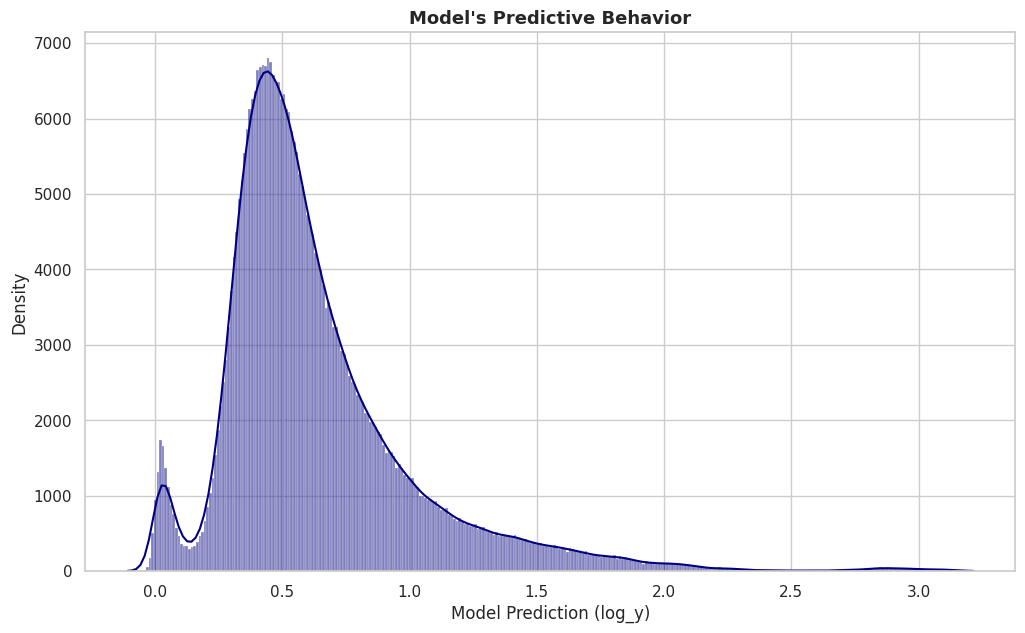

In [ ]:

if 'full_test_predictions' not in locals():
    print("Calculating predictions for the full test set...")
    full_test_predictions = champion_model_xgb.predict(X_test)

mean_prediction = np.mean(full_test_predictions)
median_prediction = np.median(full_test_predictions)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.histplot(full_test_predictions, kde=True, color='navy', label='Distribution of All Predictions')

plt.title('Model\'s Predictive Behavior', fontsize=13, fontweight='bold')
plt.xlabel('Model Prediction (log_y)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()


--- Generating the XGBoost Daily Mean Absolute Error Plot ---


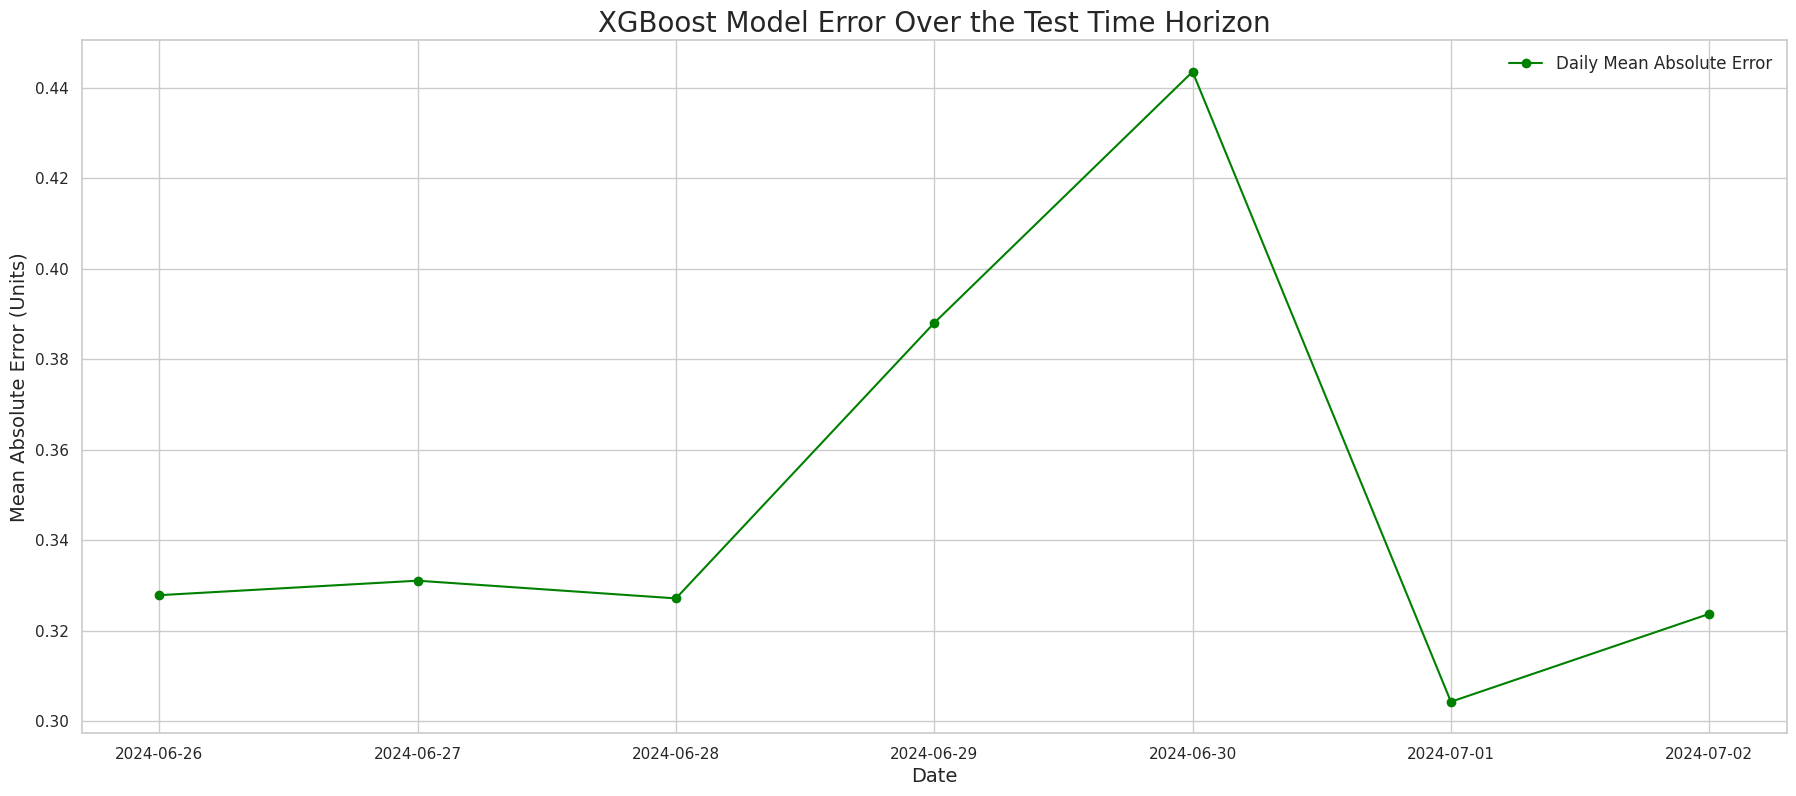

In [48]:
# ===================================================================
# CELL 2: Generate the XGBoost Error-Over-Time Plot (Consistent Style)
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Generating the XGBoost Daily Mean Absolute Error Plot ---")

# --- Step 1: Aggregate the data by date ---
# This groups all predictions for a given day and calculates the average absolute error.
daily_mae_xgb = xgb_analysis_df.groupby('date')['abs_error'].mean()

# --- Step 2: Create the visualization ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(22, 9)) # Use a wide figure

# Plot the data with styling that matches your example
plt.plot(
    daily_mae_xgb.index,
    daily_mae_xgb.values,
    marker='o',
    linestyle='-',
    color='green',
    label='Daily Mean Absolute Error'
)

# --- Step 3: Add titles and labels for a professional finish ---
plt.title('XGBoost Model Error Over the Test Time Horizon', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Mean Absolute Error (Units)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

--- Generating the Corrected XGBoost Scatter Plot ---


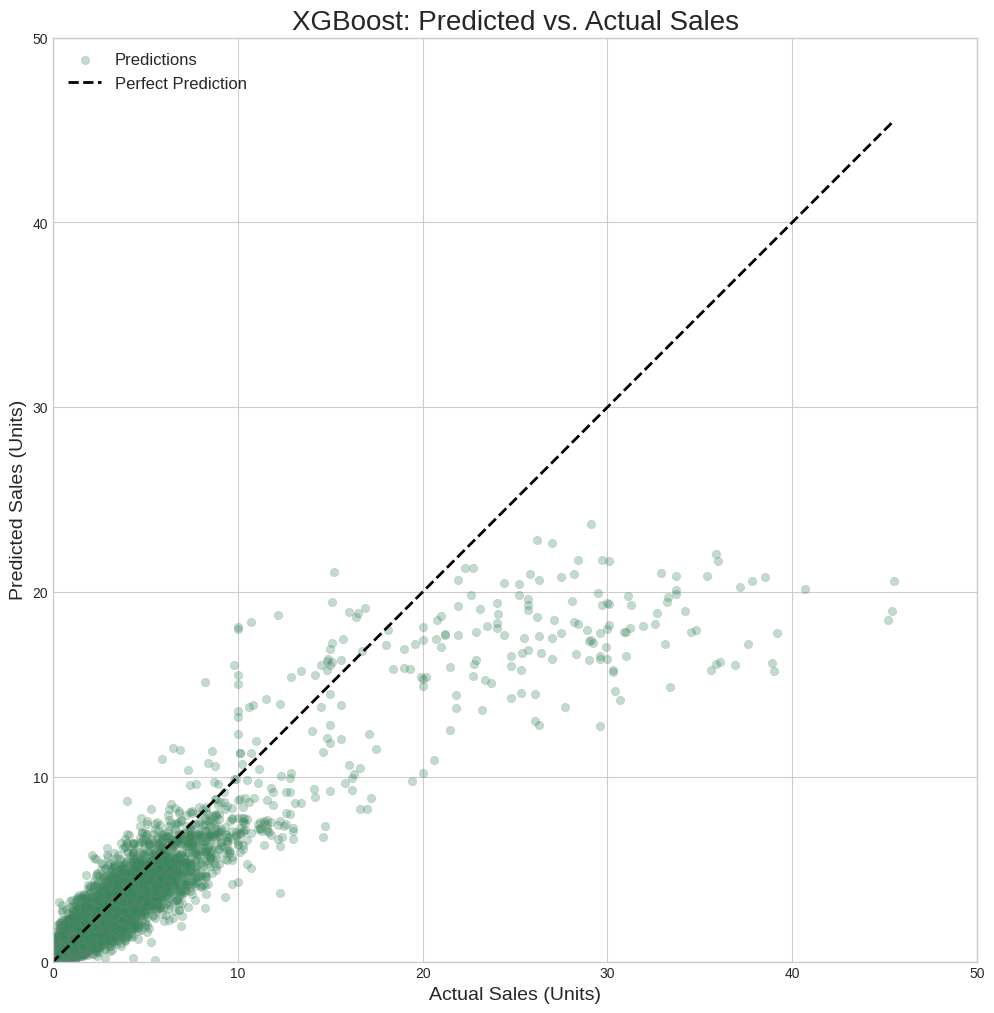

In [47]:
print("--- Generating the Corrected XGBoost Scatter Plot ---")

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 12))

# Sample the data for a cleaner plot, just like before.
# Now len(xgb_analysis_df) is 350,000
df_to_plot = xgb_analysis_df.sample(
    n=min(50000, len(xgb_analysis_df)),
    random_state=42
).copy()

sns.scatterplot(
    x='y_true',
    y='y_pred',
    data=df_to_plot,
    alpha=0.3,
    color='seagreen',
    edgecolor='gray',
    linewidth=0.5,
    label='Predictions'
)

# Find the overall min/max for the perfect prediction line to match the data
min_val = min(df_to_plot['y_true'].min(), df_to_plot['y_pred'].min())
max_val = max(df_to_plot['y_true'].max(), df_to_plot['y_pred'].max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='black',
    linestyle='--',
    linewidth=2,
    label='Perfect Prediction'
)

plt.title('XGBoost: Predicted vs. Actual Sales', fontsize=20)
plt.xlabel('Actual Sales (Units)', fontsize=14)
plt.ylabel('Predicted Sales (Units)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')

# Optional but recommended: Set axis limits to match your other plots for a direct comparison
plt.xlim(0, 50)
plt.ylim(0, 50)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# LSTM

In [29]:
# Define the baseline model architecture
N_TIMESTEPS = X_train_lstm.shape[1]
N_FEATURES = X_train_lstm.shape[2]

baseline_model = Sequential([
    LSTM(50, activation='relu', input_shape=(N_TIMESTEPS, N_FEATURES)),
    Dropout(0.2),
    Dense(1)
])
baseline_model.compile(optimizer='adam', loss='mean_squared_error')
baseline_model.summary()

# Fit the baseline model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

baseline_history = baseline_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=20,
    batch_size=128,
    validation_data=(X_val_lstm, y_val_lstm),
    callbacks=[early_stopping],
    verbose=1
)

val_preds_scaled = baseline_model.predict(X_val_lstm)

# Create dummy array to inverse transform
dummy_array_val = np.zeros((len(val_preds_scaled), scaler.n_features_in_))
target_col_index = list(scaler.feature_names_in_).index('log_y')
dummy_array_val[:, target_col_index] = val_preds_scaled.ravel()
inversed_preds_array_val = scaler.inverse_transform(dummy_array_val)
val_preds_log = inversed_preds_array_val[:, target_col_index]

# Get true values for the validation set -aligned with sequences
y_val_true_log = val_df_lstm['log_y'].iloc[N_TIMESTEPS:].values
y_val_true_orig = np.expm1(y_val_true_log)
val_preds_orig = np.expm1(val_preds_log)

# Calculate metrics
baseline_log_rmse = np.sqrt(mean_squared_error(y_val_true_log, val_preds_log))
baseline_wape = np.sum(np.abs(y_val_true_orig - val_preds_orig)) / np.sum(y_val_true_orig)
baseline_mae = mean_absolute_error(y_val_true_orig, val_preds_orig)
baseline_rmse = np.sqrt(mean_squared_error(y_val_true_orig, val_preds_orig))

print(f"\nBaseline LSTM Performance on Validation Data:")
print(f"  LOG RMSE: {baseline_log_rmse:.4f}")
print(f"  WAPE:     {baseline_wape:.2%}")
print(f"  MAE:      {baseline_mae:.4f}")
print(f"  RMSE:     {baseline_rmse:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,451 (56.45 KB)

 Trainable params: 14,451 (56.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 2/20
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 3/20
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 4/20
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 5/20
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 6/20
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 7/20
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 8/20
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 9/20
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 10/20
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 11/20
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0051 - val_loss: 0.00

In [ ]:

def objective_lstm(trial):
    n_units = trial.suggest_categorical('n_units', [32, 50, 64, 100, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)


    model = Sequential([
        LSTM(units=n_units, activation='relu', input_shape=(N_TIMESTEPS, N_FEATURES)),
        Dropout(rate=dropout_rate),
        Dense(1)
    ])


    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')


    # Early stopping for the individual trial
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    # Pruning callback to stop unpromising trials early
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')


    history = model.fit(
        X_train_lstm, y_train_lstm,
        epochs=50,
        batch_size=128,
        validation_data=(X_val_lstm, y_val_lstm),
        callbacks=[early_stopping, pruning_callback], # Pass both callbacks
        verbose=0
    )


    return min(history.history['val_loss'])


N_TRIALS_LSTM = 30
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5) # Don't prune before the 5th epoch
study_lstm = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42), pruner=pruner)

print(f"\nStarting Optuna search with {N_TRIALS_LSTM} trials and pruning")
with tqdm(total=N_TRIALS_LSTM, desc="Tuning LSTM") as pbar:
    def tqdm_callback(study, trial):
        pbar.update(1)
    study_lstm.optimize(objective_lstm, n_trials=N_TRIALS_LSTM, callbacks=[tqdm_callback])



best_trial = study_lstm.best_trial
print(f"Best trial number: {best_trial.number}")
print(f"Best validation loss (MSE): {best_trial.value:.6f}")
print("Best hyperparameters found:")
for key, value in best_trial.params.items():
    print(f"  - {key}: {value}")


In [30]:
best_lstm_params = {
    'n_units': 64,
    'dropout_rate': 0.37311043255955234,
    'learning_rate': 0.0012279424298136227
}

champion_model_lstm = Sequential([
    LSTM(units=best_lstm_params['n_units'], activation='relu', input_shape=(N_TIMESTEPS, N_FEATURES)),
    Dropout(rate=best_lstm_params['dropout_rate']),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=best_lstm_params['learning_rate'])
champion_model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

print(best_lstm_params)
champion_model_lstm.summary()


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = champion_model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_lstm, y_val_lstm),
    callbacks=[early_stopping],
    verbose=1
)

{'n_units': 64, 'dropout_rate': 0.37311043255955234, 'learning_rate': 0.0012279424298136227}


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,081 (86.25 KB)

 Trainable params: 22,081 (86.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 2/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 3/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 4/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 5/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 6/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 7/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 8/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 9/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 10/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 11/50
26563/26563 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0052 - val_loss: 0.00

In [31]:
# Cell 4: Predict with Champion Model and Final Evaluation


# --- Load the Champion Model and Scaler ---
#champion_model_lstm = load_model(MODEL_LSTM_PATH)
#scaler = joblib.load("lstm_scaler.joblib")
#print("Champion model and scaler loaded.")

# --- Predict on the Test Set ---
print("\nMaking predictions on the unseen test set...")
test_predictions_scaled = champion_model_lstm.predict(X_test_lstm)

# --- Inverse-Transform Predictions ---
# This process correctly reverses the scaling and log transformations
dummy_array = np.zeros((len(test_predictions_scaled), scaler.n_features_in_))
target_col_index = list(scaler.feature_names_in_).index('log_y')
dummy_array[:, target_col_index] = test_predictions_scaled.ravel()
inversed_preds_array = scaler.inverse_transform(dummy_array)
final_predictions_log = inversed_preds_array[:, target_col_index]
final_predictions_orig = np.expm1(final_predictions_log)
final_lstm_rmse_orig = np.sqrt(mean_squared_error(y_test_true_orig, final_predictions_orig))

print("Predictions have been inverse-transformed.")

# --- Evaluate and Display Final Results ---
final_lstm_rmse_log = np.sqrt(mean_squared_error(y_test_true_log, final_predictions_log))
final_lstm_wape = np.sum(np.abs(y_test_true_orig - final_predictions_orig)) / np.sum(y_test_true_orig)
final_lstm_mae = mean_absolute_error(y_test_true_orig, final_predictions_orig)


lstm_results = {'LOG RMSE': final_lstm_rmse_log, 'WAPE': final_lstm_wape, 'MAE': final_lstm_mae, 'RMSE': final_lstm_rmse_orig }
results_df = pd.DataFrame({'LSTM Champion (on Test)': lstm_results}).T

print("\n" + "="*50)
print("--- FINAL LSTM MODEL PERFORMANCE (on Test Set) ---")
print("="*50)
print(results_df.to_string(formatters={'WAPE':'{:.2%}'.format}))
print("\n✅ Full LSTM pipeline complete.")


Making predictions on the unseen test set...
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Predictions have been inverse-transformed.

--- FINAL LSTM MODEL PERFORMANCE (on Test Set) ---
                         LOG RMSE   WAPE       MAE     RMSE
LSTM Champion (on Test)  0.287952 42.37%  0.505475  0.93245

✅ Full LSTM pipeline complete.


### Save the Model

In [32]:
import pandas as pd
import numpy as np
import os
import json
from google.colab import drive
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ===================================================================
# SECTION 1: PREPARE FINAL PREDICTIONS AND METRICS ON THE TEST SET
# ===================================================================
print("--- Generating final predictions on the LSTM test set ---")

# Predict on the test data
final_predictions_scaled = champion_model_lstm.predict(X_test_lstm)

# We must inverse-transform the predictions to get them back to the original scale.
# Create a dummy array matching the scaler's original shape
dummy_array = np.zeros((len(final_predictions_scaled), scaler.n_features_in_))
# Find the column index for our target variable 'log_y'
target_col_index = list(scaler.feature_names_in_).index('log_y')
# Place the predictions into that column
dummy_array[:, target_col_index] = final_predictions_scaled.ravel()
# Inverse transform the entire array
inversed_preds_array = scaler.inverse_transform(dummy_array)
# Extract just our target column
final_predictions_log = inversed_preds_array[:, target_col_index]

# Align the true values (remember to skip the initial timesteps used for the first sequence)
y_test_true_log = test_df_lstm['log_y'].iloc[N_TIMESTEPS:].values

# Convert log values back to original units (e.g., sales)
y_test_true_orig = np.expm1(y_test_true_log)
final_predictions_orig = np.expm1(final_predictions_log)

# Calculate final metrics for the record
final_lstm_log_rmse = np.sqrt(mean_squared_error(y_test_true_log, final_predictions_log))
final_lstm_wape = np.sum(np.abs(y_test_true_orig - final_predictions_orig)) / np.sum(y_test_true_orig)
print(f"\nFinal LSTM Performance on Test Data:")
print(f"  LOG RMSE: {final_lstm_log_rmse:.4f}")
print(f"  WAPE:     {final_lstm_wape:.2%}")


# ===================================================================
# SECTION 2: SAVE EVERYTHING TO GOOGLE DRIVE
# ===================================================================
print("\n" + "="*50)
print("--- SAVING ALL LSTM ARTIFACTS TO GOOGLE DRIVE ---")

# 1. Mount Google Drive
drive.mount('/content/drive')
MODEL_DIR_LSTM = "/content/drive/MyDrive/LSTM_Champion_Model"
os.makedirs(MODEL_DIR_LSTM, exist_ok=True)

# 2. Save the Trained Keras Model
# The .keras format saves the architecture, weights, and optimizer state.
MODEL_PATH_LSTM = os.path.join(MODEL_DIR_LSTM, "champion_lstm_model.keras")
champion_model_lstm.save(MODEL_PATH_LSTM)
print(f"✅ Trained LSTM model saved to: {MODEL_PATH_LSTM}")

# 3. Save the Best Hyperparameters
PARAMS_PATH_LSTM = os.path.join(MODEL_DIR_LSTM, "best_lstm_hyperparameters.json")
with open(PARAMS_PATH_LSTM, 'w') as f:
    json.dump(best_lstm_params, f)
print(f"✅ Best LSTM hyperparameters saved to: {PARAMS_PATH_LSTM}")

# 4. Create and Save the Detailed Analysis DataFrame
print("\n--- Creating and saving detailed analysis data for visualizations ---")
# Align the dates from the original test dataframe
aligned_dates = test_df_lstm['date'].iloc[N_TIMESTEPS:].values

lstm_analysis_df = pd.DataFrame({
    'date': aligned_dates,
    'log_y_true': y_test_true_log,
    'log_y_pred': final_predictions_log,
    'y_true': y_test_true_orig,
    'y_pred': final_predictions_orig
})
lstm_analysis_df['error'] = lstm_analysis_df['y_true'] - lstm_analysis_df['y_pred']
lstm_analysis_df['abs_error'] = lstm_analysis_df['error'].abs()

# Save the analysis file
DETAILED_ANALYSIS_PATH_LSTM = os.path.join(MODEL_DIR_LSTM, "champion_lstm_ANALYSIS_data.csv")
lstm_analysis_df.to_csv(DETAILED_ANALYSIS_PATH_LSTM, index=False)
print(f"✅ Detailed LSTM analysis data saved to: {DETAILED_ANALYSIS_PATH_LSTM}")

print("\n\n🎉🎉🎉 ALL DONE. All LSTM artifacts are permanently saved. 🎉🎉🎉")

--- Generating final predictions on the LSTM test set ---
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step

Final LSTM Performance on Test Data:
  LOG RMSE: 0.2880
  WAPE:     42.37%

--- SAVING ALL LSTM ARTIFACTS TO GOOGLE DRIVE ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Trained LSTM model saved to: /content/drive/MyDrive/LSTM_Champion_Model/champion_lstm_model.keras
✅ Best LSTM hyperparameters saved to: /content/drive/MyDrive/LSTM_Champion_Model/best_lstm_hyperparameters.json

--- Creating and saving detailed analysis data for visualizations ---
✅ Detailed LSTM analysis data saved to: /content/drive/MyDrive/LSTM_Champion_Model/champion_lstm_ANALYSIS_data.csv


🎉🎉🎉 ALL DONE. All LSTM artifacts are permanently saved. 🎉🎉🎉


In [ ]:
import tensorflow as tf
from google.colab import drive
import os

# Mount drive
drive.mount('/content/drive')

# Define path and load the model
MODEL_DIR_LSTM = "/content/drive/MyDrive/LSTM_Champion_Model"
MODEL_PATH_LSTM = os.path.join(MODEL_DIR_LSTM, "champion_lstm_model.keras")

loaded_lstm_model = tf.keras.models.load_model(MODEL_PATH_LSTM)

# Verify it's loaded correctly
loaded_lstm_model.summary()

## Error Analysis

In [34]:
# ===================================================================
# CELL 1: Create or Load the LSTM Analysis DataFrame
# ===================================================================
import pandas as pd
import numpy as np

# OPTION 1: If you have already run the evaluation and have the variables in memory
print("--- Creating a unified DataFrame for LSTM error analysis ---")
# This requires aligning predictions with the original test dataframe's features
# We must drop the first N_TIMESTEPS rows from the original feature df to align correctly.
lstm_analysis_df = test_df_analysis.iloc[N_TIMESTEPS:].copy()
lstm_analysis_df['y_pred'] = final_predictions_orig
lstm_analysis_df['error'] = lstm_analysis_df['y'] - lstm_analysis_df['y_pred']
lstm_analysis_df['abs_error'] = lstm_analysis_df['error'].abs()
# Rename 'y' to 'y_true' for consistency
lstm_analysis_df.rename(columns={'y': 'y_true'}, inplace=True)
print("✅ Created 'lstm_analysis_df' from the current session.")


# OPTION 2: If you have restarted the session and saved the file
# print("--- Loading the DETAILED LSTM analysis data from Google Drive ---")
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# ANALYSIS_DATA_PATH = "/content/drive/MyDrive/LSTM_Champion_Model/champion_lstm_ANALYSIS_data.csv"
# lstm_analysis_df = pd.read_csv(ANALYSIS_DATA_PATH, parse_dates=['date'])
# print("✅ 'lstm_analysis_df' for the TEST SET is now in memory.")

display(lstm_analysis_df[['date', 'sku_store_id', 'y_true', 'y_pred', 'error']].head())

--- Creating a unified DataFrame for LSTM error analysis ---
✅ Created 'lstm_analysis_df' from the current session.


,date,sku_store_id,y_true,y_pred,error
1177,2024-06-26,0_566,1.2,0.755839,0.444161
1178,2024-06-26,0_662,0.9,0.772737,0.127263
1179,2024-06-26,0_670,1.1,0.797442,0.302558
1180,2024-06-26,0_702,0.6,0.813691,-0.213691
1181,2024-06-26,0_75,0.6,0.838931,-0.238931


--- Generating Predicted vs. Actual plot for the LSTM Model ---


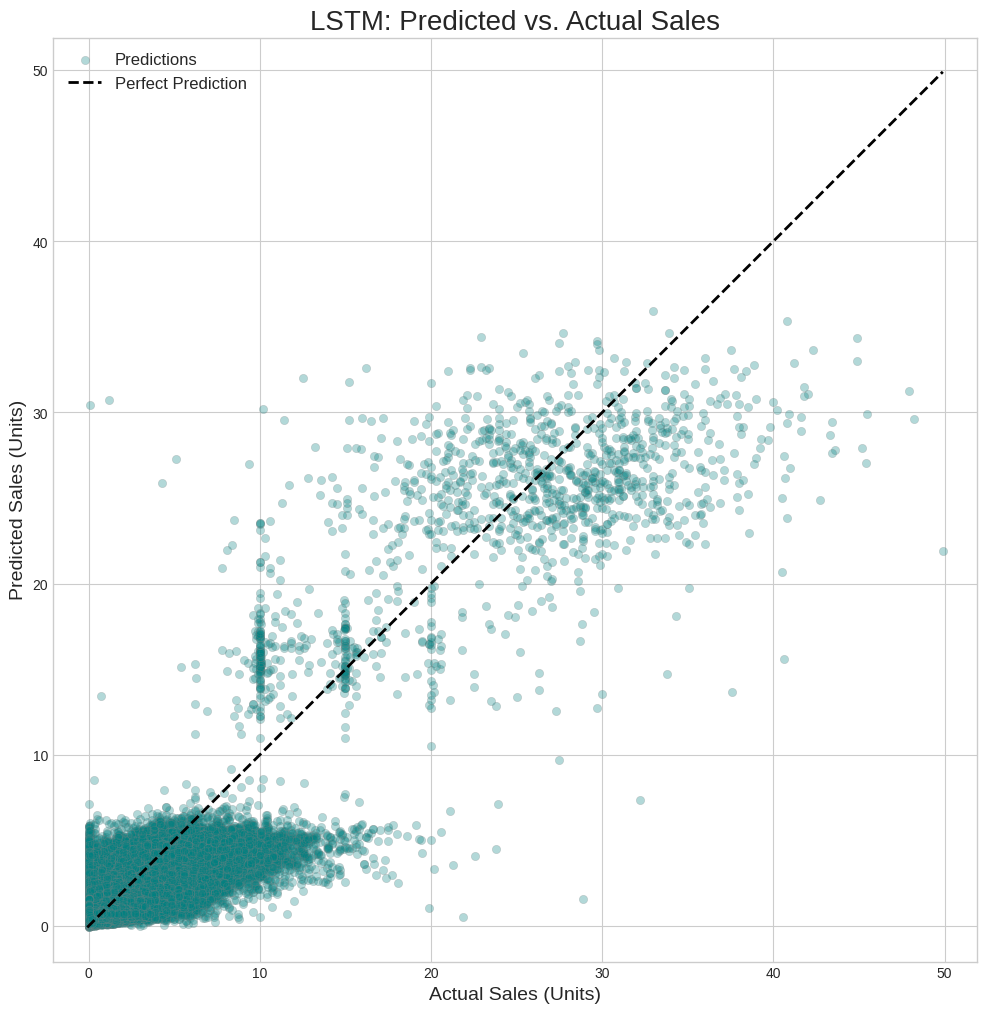

In [36]:
# ===================================================================
# CELL: LSTM - Predicted vs. Actual Plot (with DIAGONAL Line)
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Generating Predicted vs. Actual plot for the LSTM Model ---")

# This assumes 'lstm_analysis_df' is loaded and available from the previous step.

plt.figure(figsize=(12, 12)) # Use a square figure for a better aspect ratio

# --- Create the scatter plot with styling ---
# X-axis is the TRUE value, Y-axis is the PREDICTED value.
sns.scatterplot(
    x='y_true',
    y='y_pred',
    data=lstm_analysis_df,
    alpha=0.3,
    color='teal',   # Consistent color for LSTM
    edgecolor='gray',
    linewidth=0.5,
    label='Predictions'
)

# --- Create the DIAGONAL "Perfect Prediction" line ---
min_val = min(lstm_analysis_df['y_true'].min(), lstm_analysis_df['y_pred'].min())
max_val = max(lstm_analysis_df['y_true'].max(), lstm_analysis_df['y_pred'].max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='black',
    linestyle='--',
    linewidth=2,
    label='Perfect Prediction'
)

# --- Add titles and labels ---
plt.title('LSTM: Predicted vs. Actual Sales', fontsize=20)
plt.xlabel('Actual Sales (Units)', fontsize=14)
plt.ylabel('Predicted Sales (Units)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')

# --- CRITICAL: Enforce the square aspect ratio ---
# This ensures the 'Perfect Prediction' line is a true 45-degree diagonal.
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(min_val - 2, max_val + 2)
plt.ylim(min_val - 2, max_val + 2)

plt.show()

## Predictive Behavior

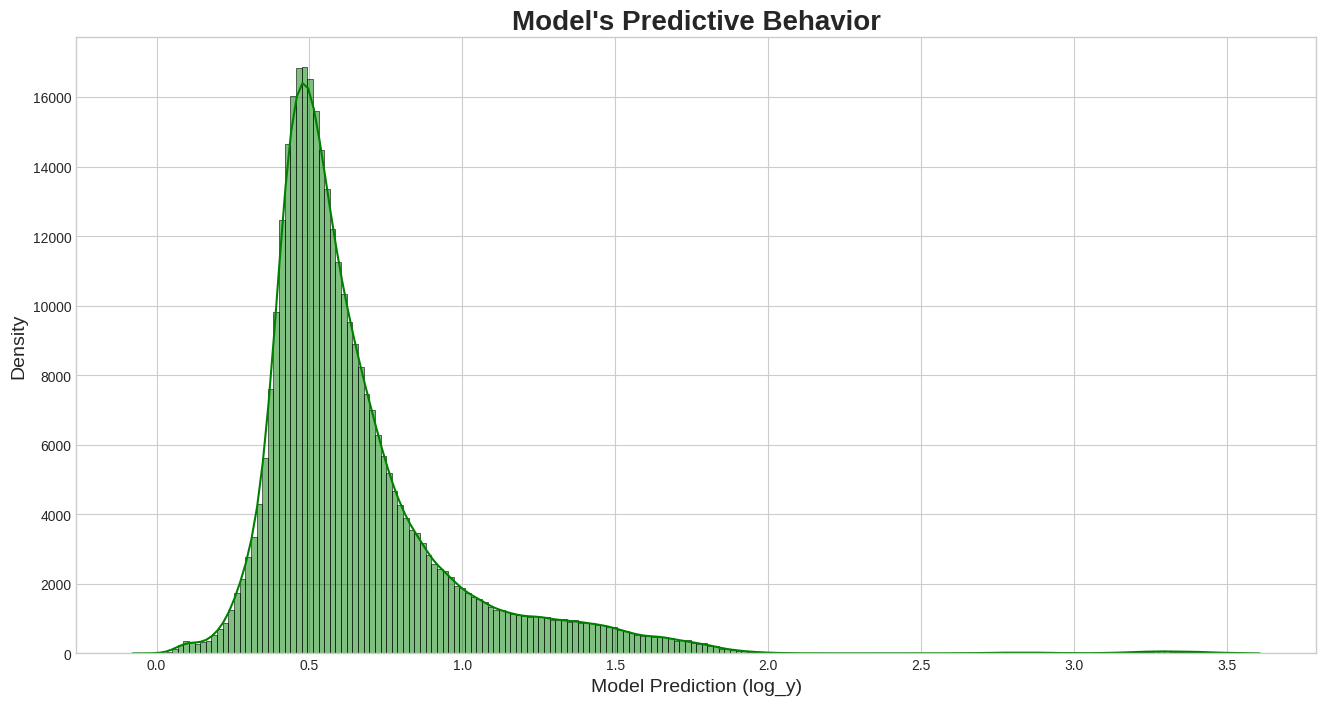

In [37]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))

# Create the histogram and density plot
# use the log-transformed predictions to see the model's underlying behavior
sns.histplot(final_predictions_log, kde=True, color='green', bins=200)

plt.title("Model's Predictive Behavior", fontsize=20, fontweight='bold')
plt.xlabel("Model Prediction (log_y)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()

## LSTM Error Over Time

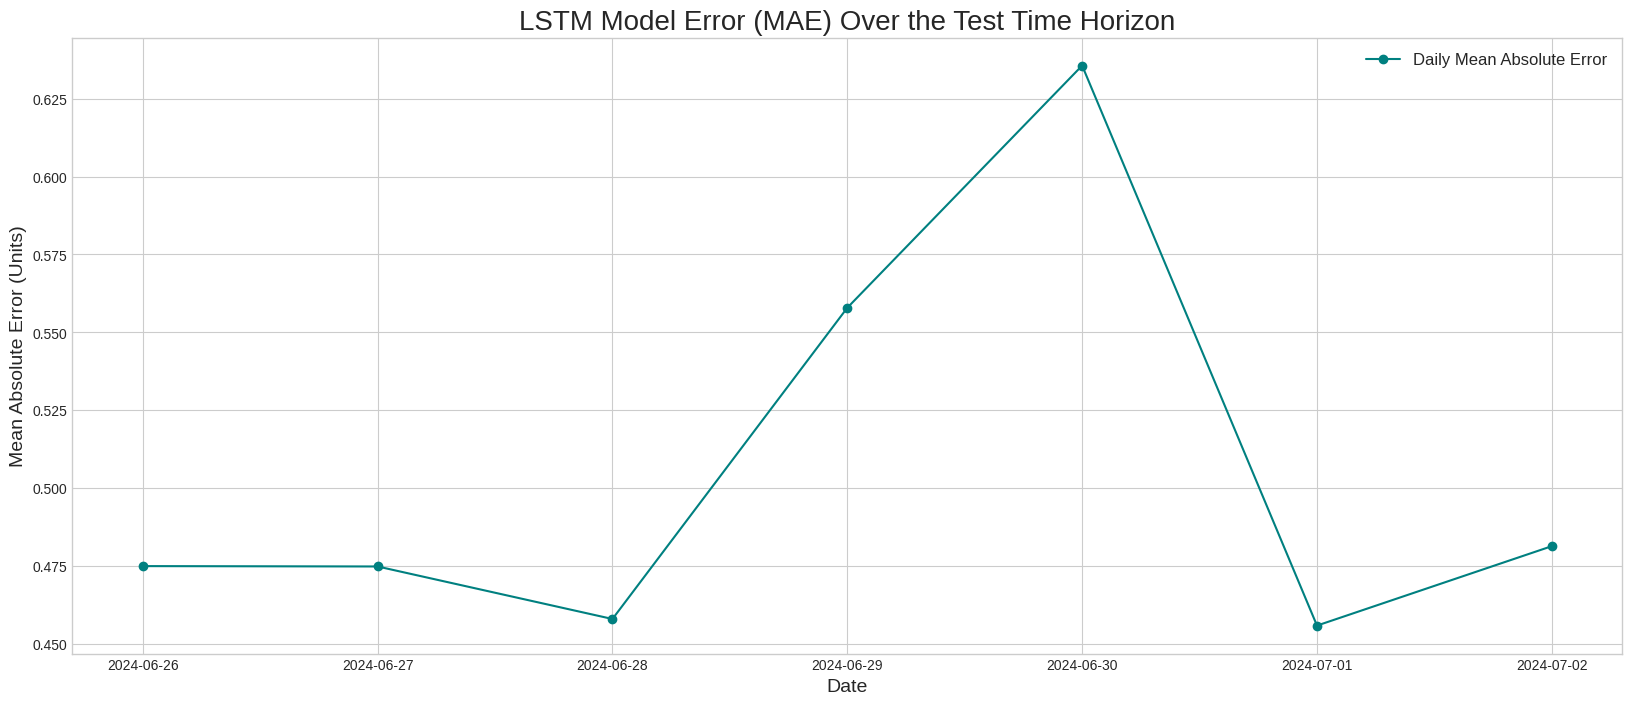

In [39]:
error_df = pd.DataFrame({
    'y_true': y_test_true_orig,
    'y_pred': final_predictions_orig
})
error_df['abs_error'] = (error_df['y_true'] - error_df['y_pred']).abs()

# Add the 'date' column and Calculate the Daily Mean Absolute Error ---
# Align the dates from the test_df_lstm, which corresponds to the sliced sequences
aligned_dates = test_df_lstm['date'].iloc[N_TIMESTEPS:].reset_index(drop=True)
error_df['date'] = aligned_dates

daily_mae = error_df.groupby('date')['abs_error'].mean()

plt.figure(figsize=(20, 8))

plt.plot(daily_mae.index, daily_mae.values, marker='o', linestyle='-', color='teal', label='Daily Mean Absolute Error')

plt.title("LSTM Model Error (MAE) Over the Test Time Horizon", fontsize=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Mean Absolute Error (Units)", fontsize=14)
plt.legend(fontsize=12)
plt.show()

# Combined Error Analysis

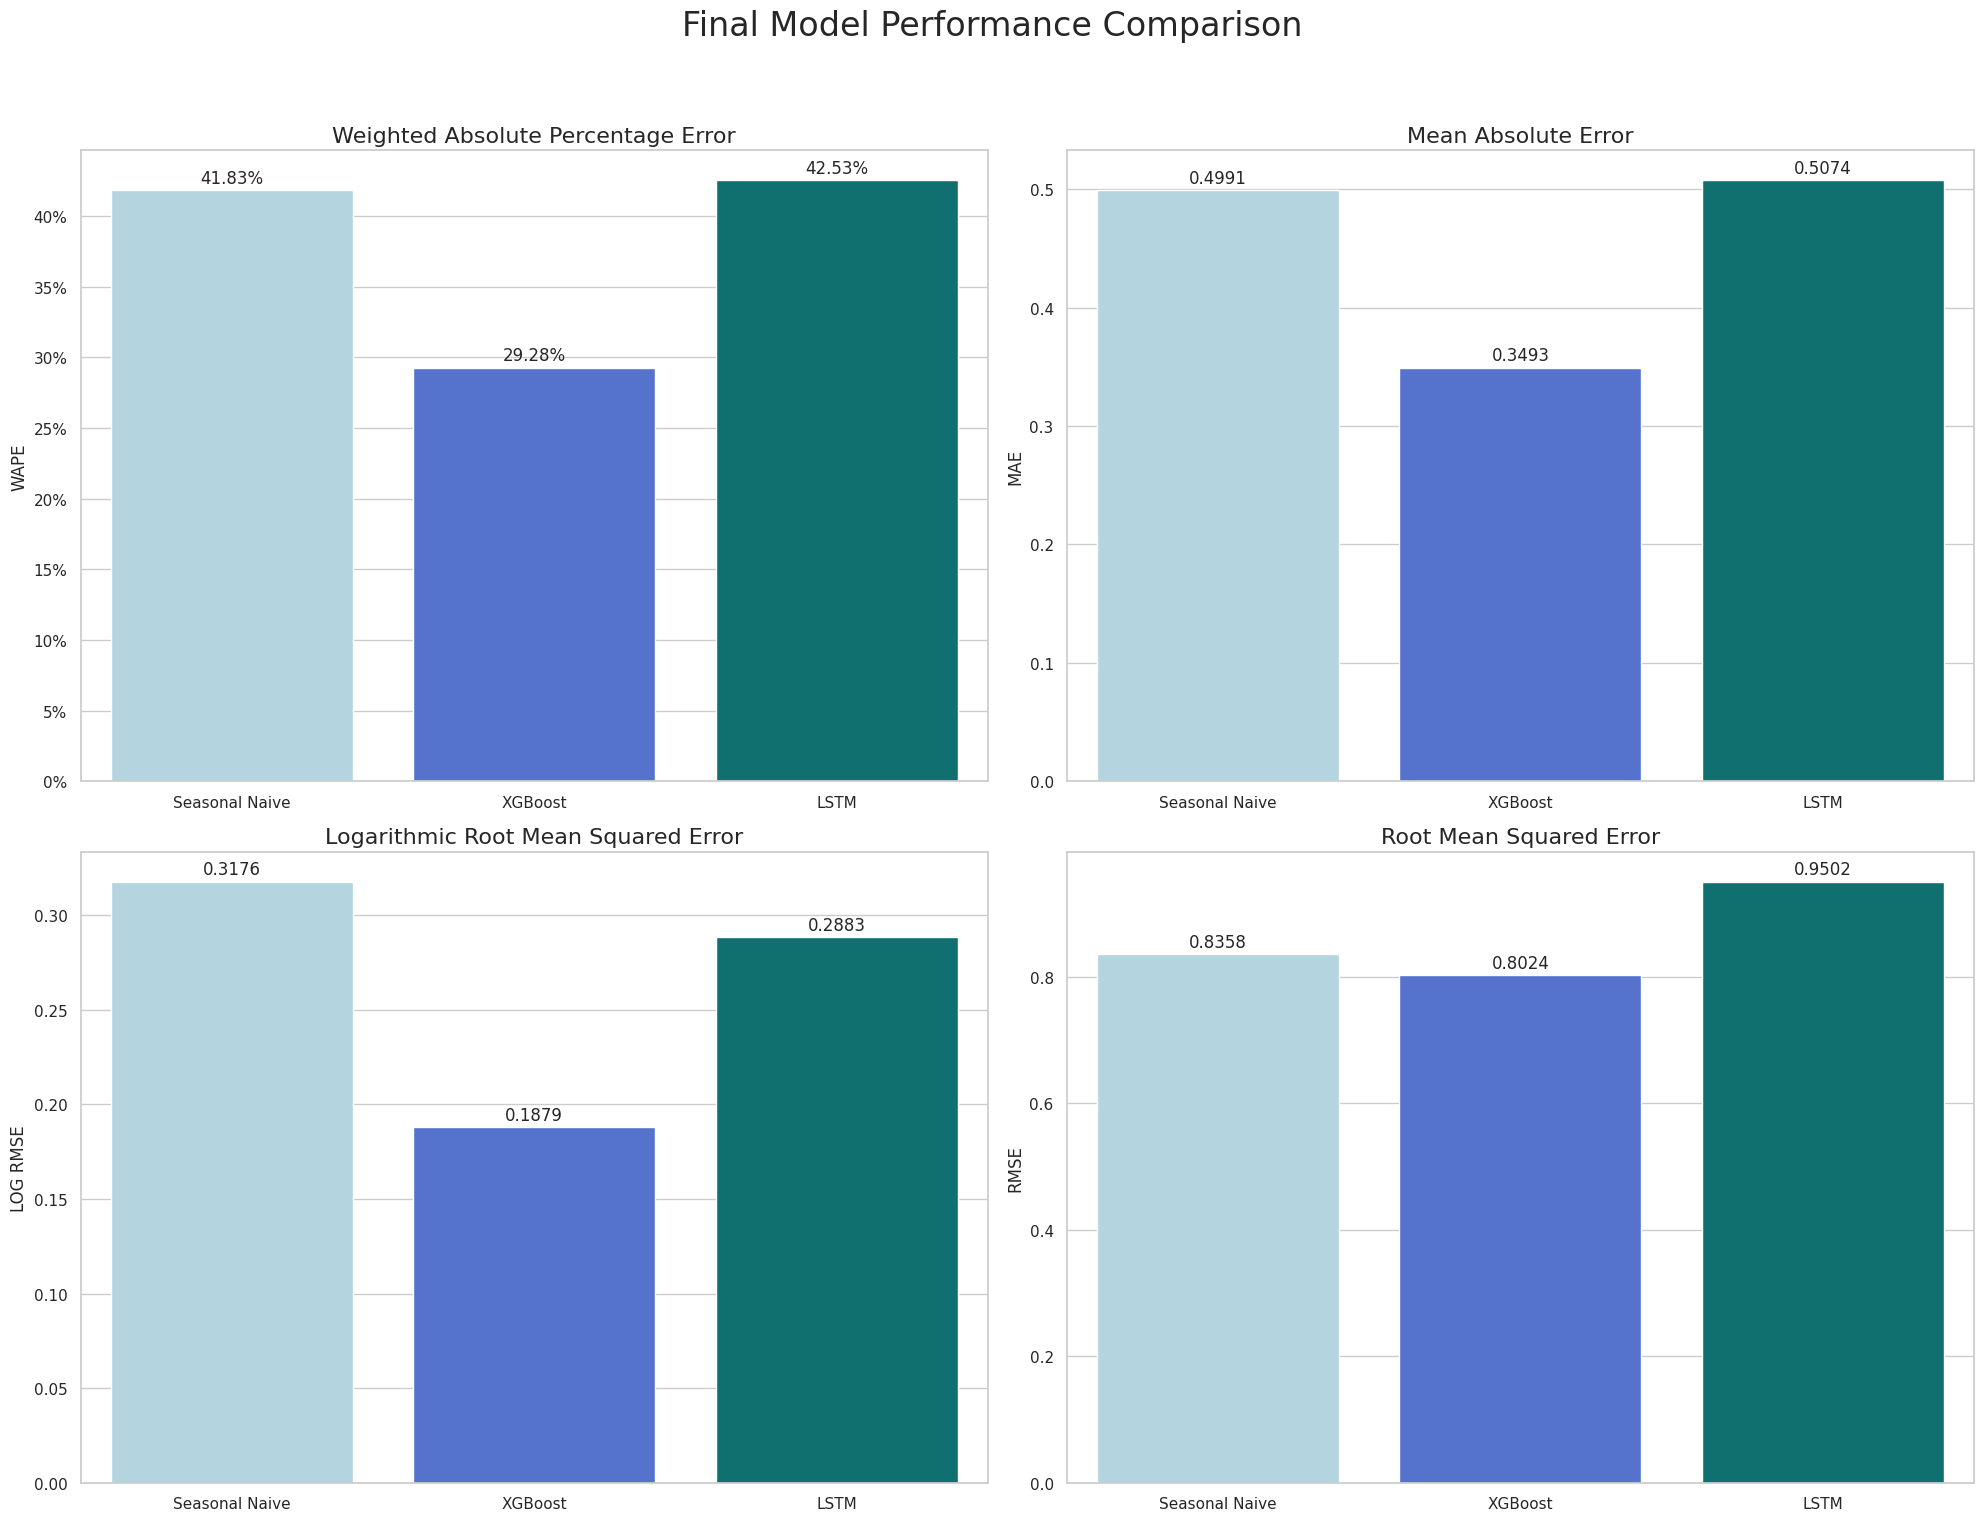

In [ ]:
# ===================================================================
# CELL: Final Model Performance Comparison (2x2 Bar Charts)
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Input the Final Results Data ---
# I have transcribed the data you provided into a structured dictionary.
final_results_data = {
    'Seasonal Naive': {
        'LOG RMSE': 0.317565,
        'WAPE': 0.4183, # Converted from 41.83%
        'MAE': 0.499071,
        'RMSE': 0.835819
    },
    'XGBoost': {
        'LOG RMSE': 0.187893,
        'WAPE': 0.2928, # Converted from 29.28%
        'MAE': 0.349346,
        'RMSE': 0.802428
    },
    'LSTM': {
        'LOG RMSE': 0.288323,
        'WAPE': 0.4253, # Converted from 42.53%
        'MAE': 0.507361,
        'RMSE': 0.950218
    }
}

# Create a DataFrame and set the model name as the index
results_df = pd.DataFrame(final_results_data).T
results_df.index.name = 'Model'

# --- Step 2: Define the Consistent Color Palette for the Models ---
# Using the colors from our previous visualizations
model_colors = {
    'Seasonal Naive': 'lightblue',
    'XGBoost': 'royalblue',
    'LSTM': 'teal'
}

# --- Step 3: Create the 2x2 Grid of Plots ---
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Final Model Performance Comparison', fontsize=24)

# --- Plot 1 (Top-Left): WAPE ---
ax1 = axes[0, 0]
sns.barplot(x=results_df.index, y=results_df['WAPE'], ax=ax1, palette=model_colors)
ax1.set_title('Weighted Absolute Percentage Error', fontsize=16)
ax1.set_ylabel('WAPE')
ax1.set_xlabel('')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# --- Plot 2 (Top-Right): MAE ---
ax2 = axes[0, 1]
sns.barplot(x=results_df.index, y=results_df['MAE'], ax=ax2, palette=model_colors)
ax2.set_title('Mean Absolute Error', fontsize=16)
ax2.set_ylabel('MAE')
ax2.set_xlabel('')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# --- Plot 3 (Bottom-Left): LOG RMSE ---
ax3 = axes[1, 0]
sns.barplot(x=results_df.index, y=results_df['LOG RMSE'], ax=ax3, palette=model_colors)
ax3.set_title('Logarithmic Root Mean Squared Error', fontsize=16)
ax3.set_ylabel('LOG RMSE')
ax3.set_xlabel('')
for p in ax3.patches:
    ax3.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# --- Plot 4 (Bottom-Right): Normal RMSE ---
ax4 = axes[1, 1]
sns.barplot(x=results_df.index, y=results_df['RMSE'], ax=ax4, palette=model_colors)
ax4.set_title('Root Mean Squared Error', fontsize=16)
ax4.set_ylabel('RMSE')
ax4.set_xlabel('')
for p in ax4.patches:
    ax4.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

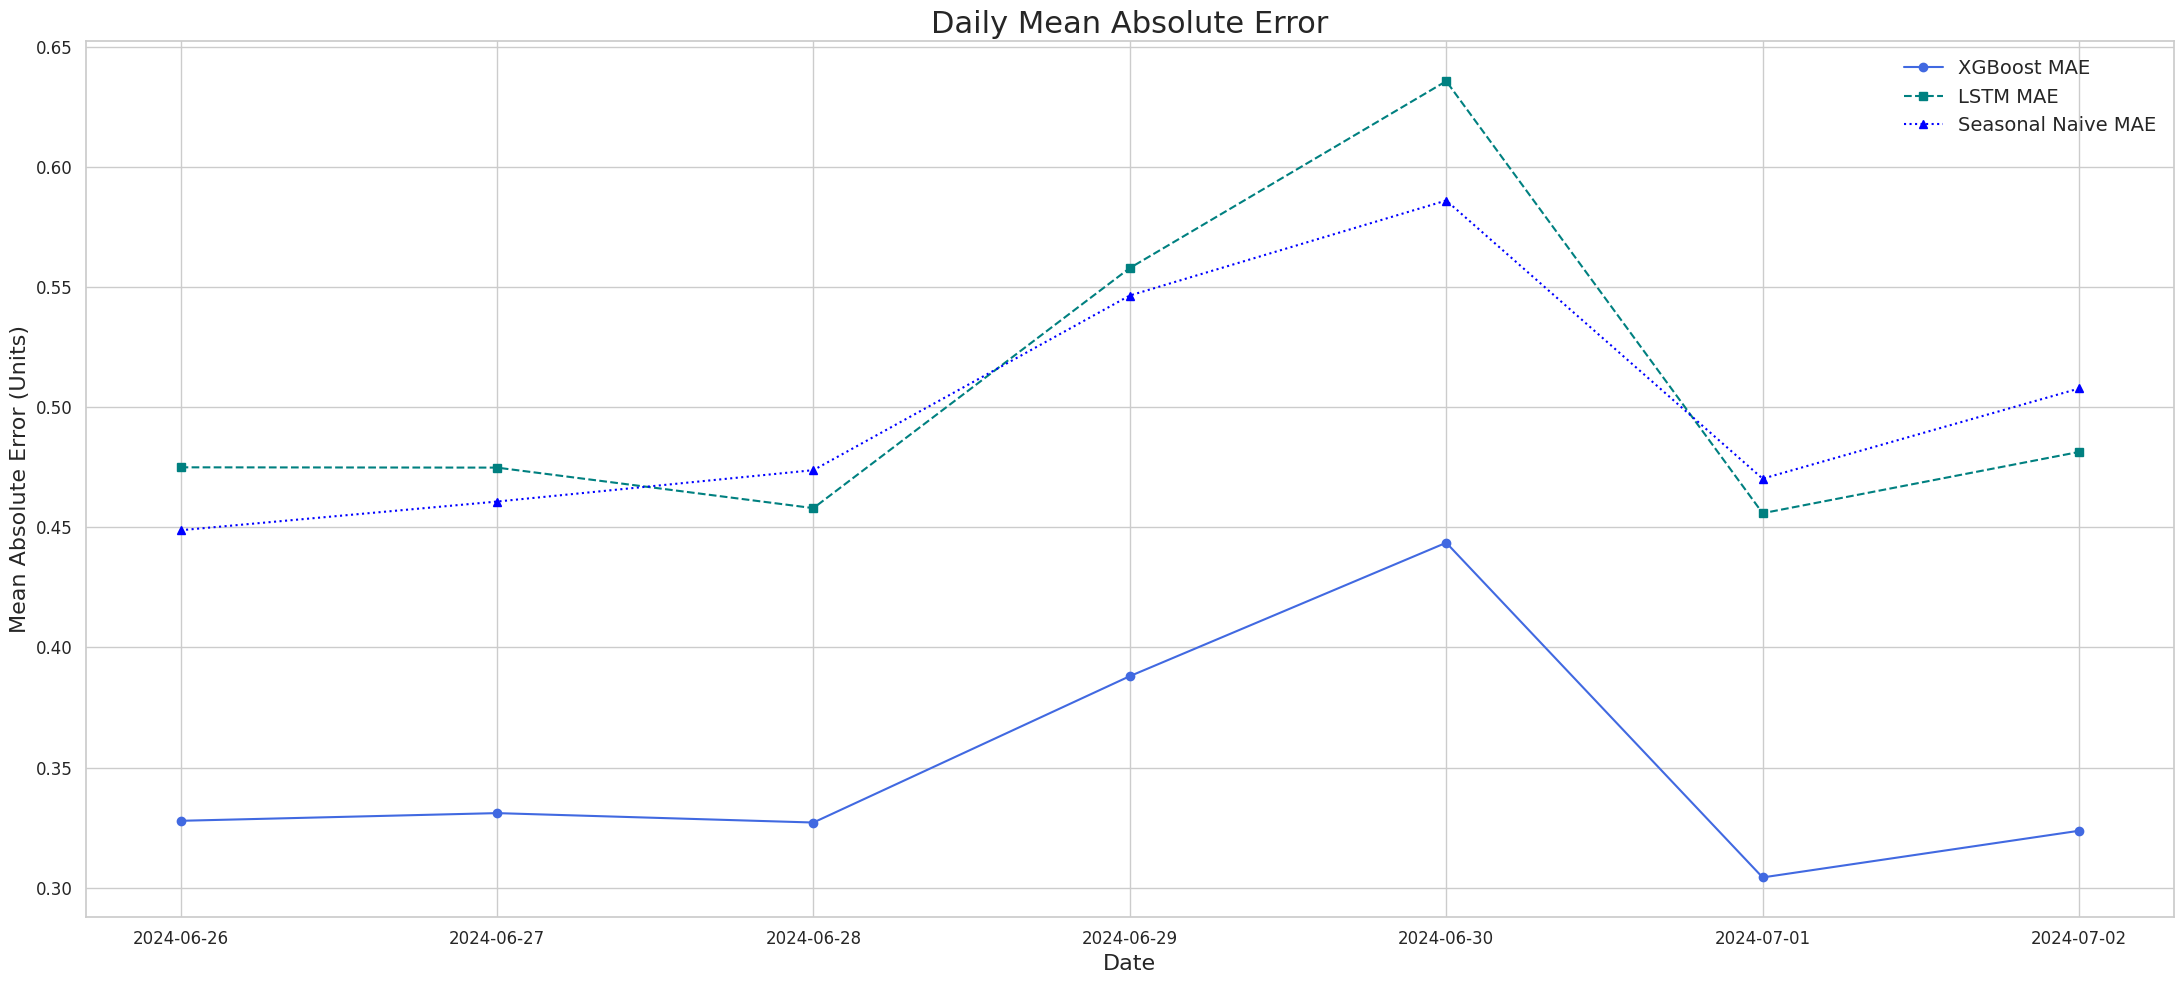

In [43]:
# ===================================================================
# CELL 2: Create the Final, Combined Error-Over-Time Plot
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(22, 10))

# --- Plot each model's error line if its data was loaded successfully ---

# Plot XGBoost
if xgb_analysis_df is not None:
    daily_mae_xgb = xgb_analysis_df.groupby('date')['abs_error'].mean()
    plt.plot(daily_mae_xgb.index, daily_mae_xgb.values, marker='o', linestyle='-', color='royalblue', label='XGBoost MAE')

# Plot LSTM
if lstm_analysis_df is not None:
    daily_mae_lstm = lstm_analysis_df.groupby('date')['abs_error'].mean()
    plt.plot(daily_mae_lstm.index, daily_mae_lstm.values, marker='s', linestyle='--', color='teal', label='LSTM MAE')

# Plot Seasonal Naive
if baseline_analysis_df is not None:
    daily_mae_baseline = baseline_analysis_df.groupby('date')['abs_error'].mean()
    plt.plot(daily_mae_baseline.index, daily_mae_baseline.values, marker='^', linestyle=':', color='blue', label='Seasonal Naive MAE')

# --- Add titles, labels, and legend for a professional finish ---
plt.title('Daily Mean Absolute Error', fontsize=22)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Mean Absolute Error (Units)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# The legend is crucial for telling the lines apart
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [48]:
daily_mae = (
    xgb_analysis_df.groupby("date")["abs_error"].mean().to_frame("mae_xgb")
    .join(lstm_analysis_df.groupby("date")["abs_error"].mean().to_frame("mae_lstm"))
    .join(baseline_analysis_df.groupby("date")["abs_error"].mean().to_frame("mae_snaive"))
    .reset_index()
)

daily_mae

,date,mae_xgb,mae_lstm,mae_snaive
0,2024-06-26,0.327815,0.474924,0.448743
1,2024-06-27,0.331017,0.474805,0.460676
2,2024-06-28,0.327102,0.457941,0.473751
3,2024-06-29,0.388016,0.557866,0.546428
4,2024-06-30,0.443542,0.635636,0.585965
5,2024-07-01,0.304250,0.455824,0.470200
6,2024-07-02,0.323680,0.481327,0.507733


In [49]:
# Top 2 worst days for XGBoost
problem_days = (
    daily_mae
    .nlargest(2, "mae_xgb")["date"]
    .tolist()
)

problem_days


[Timestamp('2024-06-30 00:00:00'), Timestamp('2024-06-29 00:00:00')]

In [54]:
test_df_final.columns

Index(['holiday_flag', 'precpt', 'avg_temperature', 'avg_humidity',
       'avg_wind_level', 'sku_store_id', 'date', 'y', 'stockout_ratio_d',
       'dow', 'discount_depth', 'log_y', 'log_y_lag_1d', 'log_y_lag_7d',
       'log_y_roll_mean_7d', 'log_y_roll_std_7d', 'stockout_ratio_lag1d',
       'stockout_ratio_r7d', 'promo_strategy_Non-Price Promo',
       'promo_strategy_Price Penetration', 'promo_strategy_Standard Discount',
       'product_id_target_encoded', 'store_id_target_encoded',
       'city_id_target_encoded', 'management_group_id_target_encoded',
       'first_category_id_target_encoded', 'second_category_id_target_encoded',
       'third_category_id_target_encoded', 'is_problem_day'],
      dtype='object')

In [57]:
test_df_final["is_problem_day"] = test_df_final["date"].isin(problem_days)

feature_cols = [
    "y",
    "discount_depth",
    "stockout_ratio_d",
    "holiday_flag",
    'promo_strategy_Non-Price Promo',
    'promo_strategy_Price Penetration',
    'promo_strategy_Standard Discount'
]

feature_summary = (
    test_df_final
    .groupby("is_problem_day")[feature_cols]
    .mean()
    .rename(index={False: "normal_days", True: "problem_days"})
)

feature_summary


,y,discount_depth,stockout_ratio_d,holiday_flag,promo_strategy_Non-Price Promo,promo_strategy_Price Penetration,promo_strategy_Standard Discount
is_problem_day,,,,,,,
normal_days,1.094337,0.07814,0.166059,0.0,0.011736,0.174352,0.31466
problem_days,1.439842,0.07885,0.181342,1.0,0.013900,0.185480,0.32403


In [63]:
# assuming train_df_final has columns: date, holiday_flag

# 1) collapse to day level
daily_holidays = (
    val_df_final
    .groupby("date")["holiday_flag"]
    .max()          # 1 if that day has any holiday rows
    .reset_index()
)

# 2) number of holiday days in the train set
n_holiday_days = daily_holidays["holiday_flag"].sum()

# 3) (optional) total days and share
total_days = len(daily_holidays)
share_holiday_days = n_holiday_days / total_days

print("Holiday days:", n_holiday_days)
print("Total days:", total_days)
print("Share of days that are holidays: {:.2%}".format(share_holiday_days))


Holiday days: 4
Total days: 15
Share of days that are holidays: 26.67%


# XAI

## Getting a Sample

In [ ]:
# ===================================================================
# CELL 1 (Corrected): Create a Prediction-Stratified Sample for BOTH LIME and SHAP
# ===================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

print("--- Creating a Prediction-Stratified Sample for a Fair XAI Comparison ---")

# --- Step 1: Define the Sample Size ---
SAMPLE_SIZE = 10000

if len(X_test) < SAMPLE_SIZE:
    print(f"Warning: Test set size ({len(X_test)}) is smaller than the desired sample size ({SAMPLE_SIZE}). Using the full test set.")
    SAMPLE_SIZE = len(X_test)

# --- Step 2: Generate Predictions and Create Strata ---
print("Generating predictions on the full test set to create stratification bins...")
full_test_predictions = champion_model_xgb.predict(X_test)

N_BINS = 10
prediction_bins = pd.qcut(full_test_predictions, q=N_BINS, labels=False, duplicates='drop')
print(f"Created {len(np.unique(prediction_bins))} bins to stratify on.")

# --- Step 3: Perform Stratified Sampling ---
print(f"Performing stratified sampling to get {SAMPLE_SIZE} instances...")
X_shap_input, _, _, _ = train_test_split(
    X_test,
    prediction_bins,
    train_size=SAMPLE_SIZE,
    random_state=42,
    stratify=prediction_bins
)

# Create an identical sample for LIME
X_lime_sample = X_shap_input.copy()

print(f"\n✅ Created identical samples for SHAP and LIME.")
print(f"   - Shape of 'X_shap_input': {X_shap_input.shape}")
print(f"   - Shape of 'X_lime_sample': {X_lime_sample.shape}")

--- Creating a Prediction-Stratified Sample for a Fair XAI Comparison ---
Generating predictions on the full test set to create stratification bins...
Created 10 bins to stratify on.
Performing stratified sampling to get 10000 instances...

✅ Created identical samples for SHAP and LIME.
   - Shape of 'X_shap_input': (10000, 25)
   - Shape of 'X_lime_sample': (10000, 25)


--- Verifying the quality of the prediction-stratified sample ---

--- Comparing summary statistics of 'log_y_lag_1d' ---
       Full Test Set   Sampled Set
count  350000.000000  10000.000000
mean        0.657452      0.655967
std         0.442261      0.438209
min         0.000000      0.000000
25%         0.405465      0.405465
50%         0.587787      0.587787
75%         0.832909      0.832909
max         3.895894      3.732896


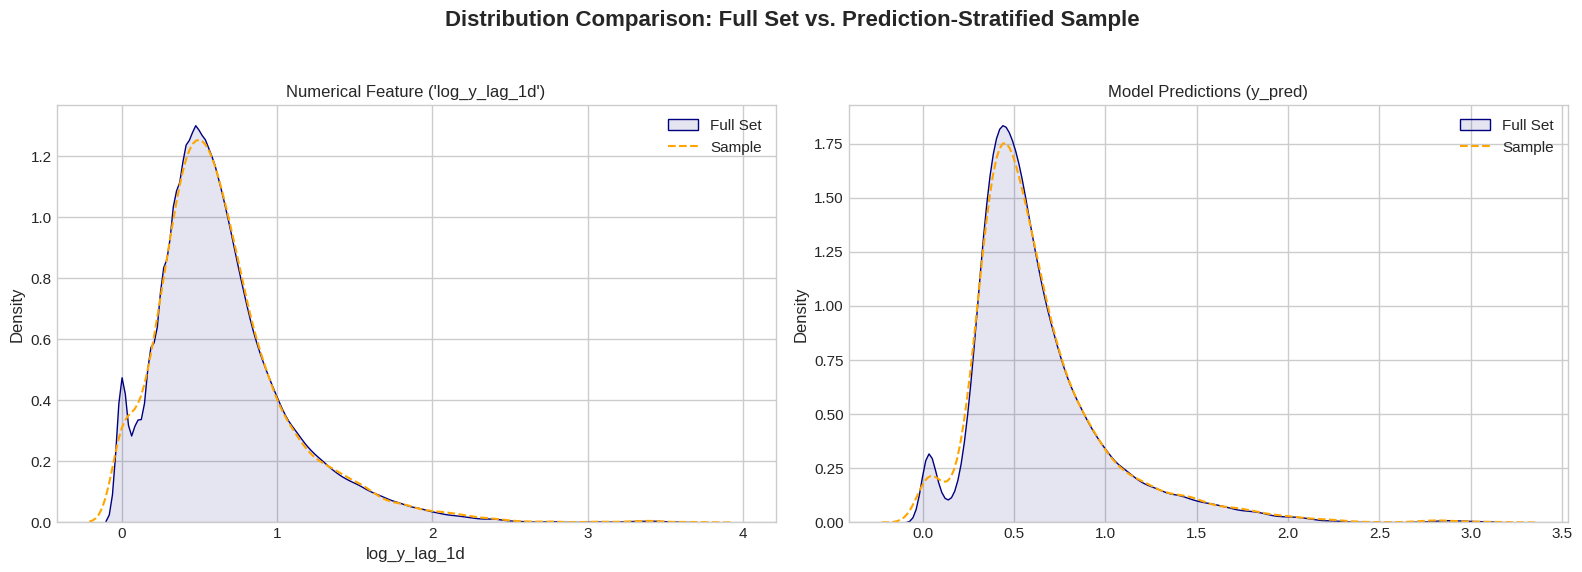

In [ ]:
# ===================================================================
# CELL 2 (New): Verify the Quality of the Stratified Sample
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Verifying the quality of the prediction-stratified sample ---")

# --- Compare Numerical Feature Distributions ---
key_numerical_feature = 'log_y_lag_1d'
print(f"\n--- Comparing summary statistics of '{key_numerical_feature}' ---")
numerical_comparison = pd.DataFrame({
    'Full Test Set': X_test[key_numerical_feature].describe(),
    'Sampled Set': X_shap_input[key_numerical_feature].describe()
})
print(numerical_comparison)

# --- Visual Verification ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Distribution Comparison: Full Set vs. Prediction-Stratified Sample', fontsize=16, fontweight='bold')

# Plot a numerical feature's density
sns.kdeplot(X_test[key_numerical_feature], ax=axes[0], label='Full Set', color='navy', fill=True, alpha=0.1)
sns.kdeplot(X_shap_input[key_numerical_feature], ax=axes[0], label='Sample', color='orange', linestyle='--')
axes[0].set_title(f"Numerical Feature ('{key_numerical_feature}')")
axes[0].legend()

# Plot the distribution of the predictions themselves
sample_predictions = champion_model_xgb.predict(X_shap_input)
sns.kdeplot(full_test_predictions, ax=axes[1], label='Full Set', color='navy', fill=True, alpha=0.1)
sns.kdeplot(sample_predictions, ax=axes[1], label='Sample', color='orange', linestyle='--')
axes[1].set_title("Model Predictions (y_pred)")
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for the suptitle
plt.show()

## SHAP

In [ ]:
#Initializing SHAP Explainer

explainer = None

try:
    # fix the model's base_score for TreeExplainer compatibility
    print("Attempting to fix 'base_score' to enable the fast TreeExplainer...")
    config = champion_model_xgb.get_booster().save_config()
    config_dict = json.loads(config)

    # Check if base_score is a string that needs fixing
    base_score_val = config_dict['learner']['learner_model_param']['base_score']
    if isinstance(base_score_val, str) and '[' in base_score_val:
        new_base_score = float(base_score_val.strip('[]'))
        config_dict['learner']['learner_model_param']['base_score'] = new_base_score
        corrected_config = json.dumps(config_dict)
        champion_model_xgb.get_booster().load_config(corrected_config)
        print(f"Successfully fixed 'base_score' from '{base_score_val}' to '{new_base_score}'.")
    else:
        print("'base_score' is already in the correct format.")

    # Initialize the TreeExplainer
    explainer = shap.TreeExplainer(champion_model_xgb)
    print("\nSHAP is using the fast, model-specific TreeExplainer.")

except Exception as e:
    print("\n🚨 CRITICAL ERROR: Could not initialize the fast TreeExplainer.")
    print(f"   The error was: {e}")
    print("\n   ACTION REQUIRED: The code will not fall back to the slow KernelExplainer.")
    print("   Please debug the issue above or, if you choose to proceed with a slow method,")
    print("   manually implement the KernelExplainer in a new cell.")

Attempting to fix 'base_score' to enable the fast TreeExplainer...
Successfully fixed 'base_score' from '[5.9463465E-1]' to '0.59463465'.

SHAP is using the fast, model-specific TreeExplainer.


In [ ]:
if 'champion_model_xgb' in locals() and champion_model_xgb is not None:
    print(f"Calculating SHAP values for the {len(X_shap_input)} samples")

    explainer = shap.Explainer(champion_model_xgb, X_shap_input)
    shap_values_object = explainer(X_shap_input)

    shap_values = shap_values_object.values

    print(f"\SHAP values calculated successfully. Shape: {shap_values.shape}")

else:
    print("🚨 ERROR: Champion model 'champion_model_xgb' not found.")

Calculating SHAP values for the 10000 samples


100%|===================| 9999/10000 [168:43<00:01]       

\SHAP values calculated successfully. Shape: (10000, 25)


In [ ]:
# Creating a df for the analysis
if 'shap_values' in locals() and 'X_shap_input' in locals():
    print("--- Creating 'shap_global_importance_df' from existing SHAP values ---")

    # Take the absolute of all SHAP values
    abs_shap_values = np.abs(shap_values)
    # Calculate the mean of the absolute values for each feature
    mean_abs_shap = np.mean(abs_shap_values, axis=0)

    # Create the 'global_importance_df' DataFrame
    shap_global_importance_df = pd.DataFrame({
        'Feature': X_shap_input.columns,
        'Mean Absolute SHAP': mean_abs_shap
    })

    # Sort the features by their importance
    shap_global_importance_df.sort_values(by='Mean Absolute SHAP', ascending=False, inplace=True)

    print("The 'shap_global_importance_df' DataFrame has been successfully created.")


else:
    print("'shap_values' or 'X_shap_input' not found in the current session.")


--- Creating 'shap_global_importance_df' from existing SHAP values ---


NameError: name 'global_importance_df' is not defined

### save the shap analysis

In [ ]:
# ===================================================================
# ADD-ON: Save the Complete SHAP Analysis to Google Drive
# ===================================================================
from google.colab import drive
import os
import numpy as np
import json

# This code assumes that 'shap_values', 'X_shap_input', and 'explainer'
# exist in your session from the previous cells.

print("\n" + "="*50)
print("--- SAVING SHAP ANALYSIS ARTIFACTS TO GOOGLE DRIVE ---")

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define a dedicated folder for your SHAP results
SHAP_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model/SHAP_Analysis"
os.makedirs(SHAP_DIR, exist_ok=True)

# 3. Define the paths for each file
SHAP_VALUES_PATH = os.path.join(SHAP_DIR, "shap_values.npy")
SHAP_INPUT_PATH = os.path.join(SHAP_DIR, "shap_input_data.csv")
SHAP_METADATA_PATH = os.path.join(SHAP_DIR, "shap_metadata.json")

# 4. Save each artifact using the best method for its type

#   a) Save the shap_values NumPy array using np.save (efficient binary format)
np.save(SHAP_VALUES_PATH, shap_values)
print(f"✅ SHAP values array saved to: {SHAP_VALUES_PATH}")

#   b) Save the X_shap_input DataFrame to a CSV
X_shap_input.to_csv(SHAP_INPUT_PATH, index=True) # index=True is crucial
print(f"✅ SHAP input data saved to: {SHAP_INPUT_PATH}")

#   c) Save the explainer's base value to a JSON for easy loading
shap_metadata = {'expected_value': explainer.expected_value}
with open(SHAP_METADATA_PATH, 'w') as f:
    json.dump(shap_metadata, f)
print(f"✅ SHAP metadata (base value) saved to: {SHAP_METADATA_PATH}")

print("\n\n🎉🎉🎉 ALL DONE. Your SHAP analysis is now permanently saved. 🎉🎉🎉")


--- SAVING SHAP ANALYSIS ARTIFACTS TO GOOGLE DRIVE ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ SHAP values array saved to: /content/drive/MyDrive/XGBoost_Champion_Model/SHAP_Analysis/shap_values.npy
✅ SHAP input data saved to: /content/drive/MyDrive/XGBoost_Champion_Model/SHAP_Analysis/shap_input_data.csv
✅ SHAP metadata (base value) saved to: /content/drive/MyDrive/XGBoost_Champion_Model/SHAP_Analysis/shap_metadata.json


🎉🎉🎉 ALL DONE. Your SHAP analysis is now permanently saved. 🎉🎉🎉


In [ ]:
# ===================================================================
# FUTURE WORKFLOW: Load All Saved SHAP Artifacts from Google Drive
# This is the ONLY cell you need to run in the future to do SHAP analysis.
# ===================================================================
import pandas as pd
import numpy as np
import json
import shap
from google.colab import drive
import os

print("--- Loading all saved SHAP artifacts from Google Drive ---")
drive.mount('/content/drive')

# --- 1. Define Paths ---
SHAP_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model/SHAP_Analysis"
SHAP_VALUES_PATH = os.path.join(SHAP_DIR, "shap_values.npy")
SHAP_INPUT_PATH = os.path.join(SHAP_DIR, "shap_input_data.csv")
SHAP_METADATA_PATH = os.path.join(SHAP_DIR, "shap_metadata.json")

# --- 2. Load the Artifacts into Memory ---
#    (Includes error checking to ensure files exist)

if not os.path.exists(SHAP_DIR):
    raise FileNotFoundError(f"SHAP directory not found at {SHAP_DIR}. Please run the saving script first.")

# Load the SHAP values array
shap_values = np.load(SHAP_VALUES_PATH)
print(f"✅ SHAP values loaded. Shape: {shap_values.shape}")

# Load the input data. index_col=0 is crucial.
# Make sure to parse dates if your index is a date.
X_shap_input = pd.read_csv(SHAP_INPUT_PATH, index_col=0, parse_dates=True)
print(f"✅ SHAP input data loaded. Shape: {X_shap_input.shape}")

# Load the base value
with open(SHAP_METADATA_PATH, 'r') as f:
    shap_metadata = json.load(f)
loaded_expected_value = shap_metadata['expected_value']
print(f"✅ SHAP base value loaded: {loaded_expected_value}")


# --- 3. You are now ready to create ANY visualization ---
print("\n🎉 All data loaded. You can now run any of your visualization cells instantly.")


# --- EXAMPLE: Re-creating the Global Bar Plot ---
print("\n--- Example: Generating Global Bar Plot ---")
shap.summary_plot(shap_values, X_shap_input, plot_type="bar", show=True)


# --- EXAMPLE: Re-creating a Local Waterfall Plot ---
print("\n--- Example: Generating Local Waterfall Plot for instance #0 ---")
shap_explanation = shap.Explanation(
    values=shap_values[0],
    base_values=loaded_expected_value,
    data=X_shap_input.iloc[0],
    feature_names=X_shap_input.columns.tolist()
)
shap.waterfall_plot(shap_explanation, show=True)

## continue the shap analysis

Generating Global Feature Importance Plots

Bar Plot - Global Importance:


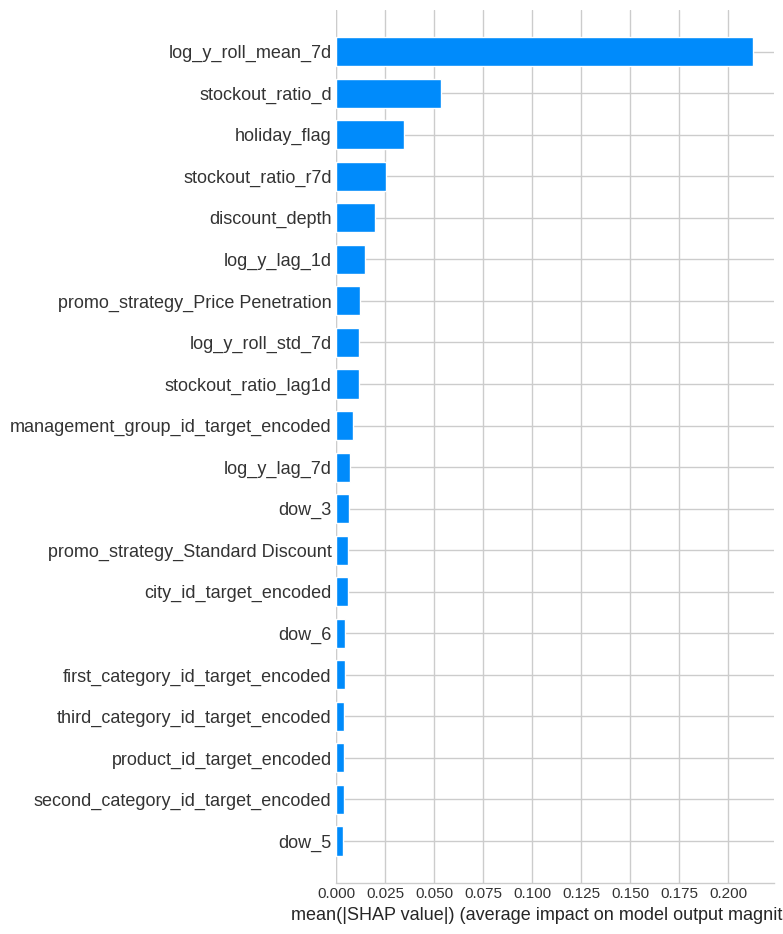


Beeswarm Plot - Importance and Impact:


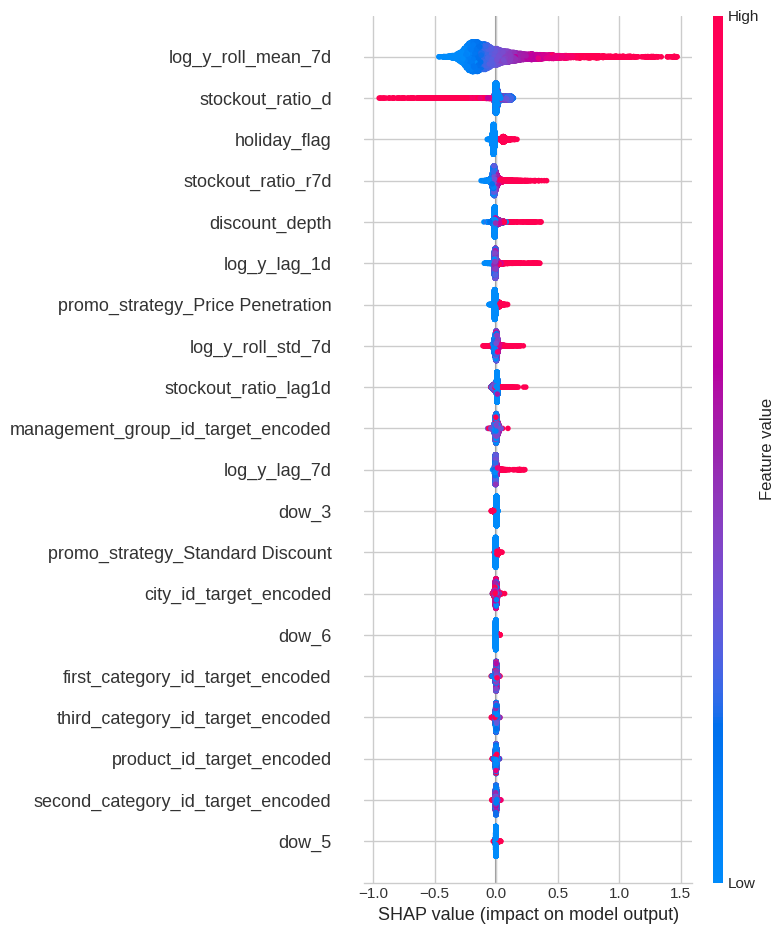

In [ ]:
if 'shap_values' in locals():
    print("Generating Global Feature Importance Plots")

    print("\nBar Plot - Global Importance:")
    shap.summary_plot(shap_values, X_shap_input, plot_type="bar", show=True)

    print("\nBeeswarm Plot - Importance and Impact:")
    shap.summary_plot(shap_values, X_shap_input, plot_type="dot", show=True)
else:
    print("shap_values not found.")

Identified the worst prediction in the sample at index: 214941 (position #7377)
   - Actual Value (log_y): 1.2238
   - Predicted Value (log_y): 0.1536
   - Absolute Error: 1.0702

Generating Local Explanation for this Worst Prediction


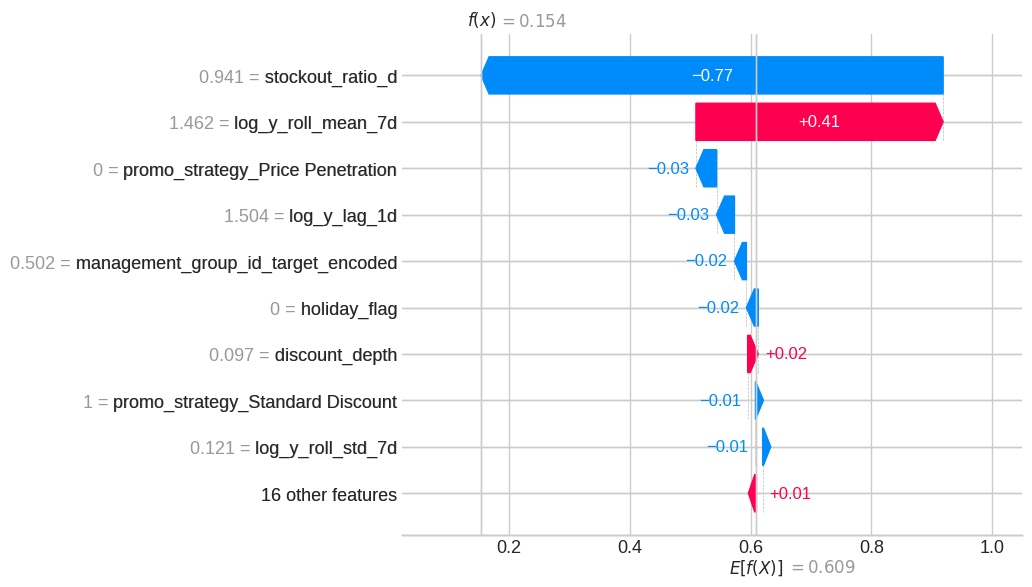

In [ ]:
if 'explainer' in locals() and 'shap_values' in locals():

    # Find the worst prediction in your SHAP sample

    # First, get the model's predictions for the same data used for SHAP
    predictions_on_shap_sample = explainer.model.predict(X_shap_input)

    # Get the corresponding true values
    true_values_for_shap_sample = y_test.loc[X_shap_input.index]

    # Calculate the absolute error for each instance in the sample
    abs_errors = np.abs(true_values_for_shap_sample - predictions_on_shap_sample)

    # Find the index of the instance with the LARGEST absolute error
    worst_prediction_index = abs_errors.idxmax()

    # Get the integer position of this index in the sample dataframe
    instance_iloc = X_shap_input.index.get_loc(worst_prediction_index)

    print(f"Identified the worst prediction in the sample at index: {worst_prediction_index} (position #{instance_iloc})")
    print(f"   - Actual Value (log_y): {true_values_for_shap_sample.loc[worst_prediction_index]:.4f}")
    print(f"   - Predicted Value (log_y): {predictions_on_shap_sample[instance_iloc]:.4f}")
    print(f"   - Absolute Error: {abs_errors.loc[worst_prediction_index]:.4f}")


    # Generate the Local Explanation for this specific instance
    print(f"\nGenerating Local Explanation for this Worst Prediction")

    # Create a SHAP Explanation object for modern plotting
    shap_explanation = shap.Explanation(
        values=shap_values[instance_iloc],
        base_values=explainer.expected_value,
        data=X_shap_input.iloc[instance_iloc],
        feature_names=X_shap_input.columns.tolist()
    )

    # The waterfall plot will now explain why the model made this specific large error
    shap.waterfall_plot(shap_explanation, show=True)

else:
    print("explainer or shap_values not found. Please run previous cells first.")

## LIME

In [ ]:
if 'X_lime_sample' in locals():
    print("Initializing LIME Explainer")

    # Create the LIME Explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=X_train.columns.tolist(),
        mode='regression',
        random_state=42
    )

    # Create an empty array to store the absolute weights for each feature from each explanation.
    all_abs_weights = np.zeros((len(X_lime_sample), len(X_train.columns)))

    print(f"\nGenerating LIME explanations for the {len(X_lime_sample)} samples...")
    print("This may take a while.")

    # Loop through each instance in the sample and get its explanation
    for i in tqdm(range(len(X_lime_sample)), desc="Generating LIME Explanations"):
        instance_to_explain = X_lime_sample.iloc[i]

        explanation = lime_explainer.explain_instance(
            instance_to_explain.values,
            champion_model_xgb.predict,
            num_features=len(X_train.columns)
        )

        # Map the explanation results to the correct feature indices and store the absolute weight
        weight_map = dict(explanation.as_map()[1])
        for feature_idx, weight in weight_map.items():
            all_abs_weights[i, feature_idx] = abs(weight)

    print("\nLIME explanation weights calculated successfully.")
    print("   The results are now stored in the 'all_abs_weights' variable and ready for analysis.")
else:
    print("`X_lime_sample` not found. Please run the setup cell first.")

Initializing LIME Explainer

Generating LIME explanations for the 10000 samples...
This may take a while.


Generating LIME Explanations:   0%|          | 0/10000 [00:00<?, ?it/s]


LIME explanation weights calculated successfully.
   The results are now stored in the 'all_abs_weights' variable and ready for analysis.


In [ ]:
if 'all_abs_weights' in locals():
    print("--- Calculating Final Global LIME Importance from the stored weights ---")

    # --- This part is very fast ---
    # Calculate the mean of the absolute weights for each feature (column)
    mean_abs_weights = np.mean(all_abs_weights, axis=0)

    # Create a clean DataFrame for display and further analysis
    global_lime_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Mean Absolute LIME Weight': mean_abs_weights
    }).sort_values(by='Mean Absolute LIME Weight', ascending=False)


    print("\nLIME Global Feature Importance (Top 20)")
    print(global_lime_importances.head(20).to_string(index=False))

    print("\nLIME global importance ranking is ready.")
else:
    print("`all_abs_weights` not found. Please run the slow calculation cell (Cell 1) first.")

--- Calculating Final Global LIME Importance from the stored weights ---

LIME Global Feature Importance (Top 20)
                          Feature  Mean Absolute LIME Weight
               log_y_roll_mean_7d                   0.286930
                     holiday_flag                   0.079601
                 stockout_ratio_d                   0.051489
 promo_strategy_Price Penetration                   0.040992
   promo_strategy_Non-Price Promo                   0.037142
               stockout_ratio_r7d                   0.035900
                            dow_3                   0.028309
                   discount_depth                   0.024137
                            dow_6                   0.021442
 promo_strategy_Standard Discount                   0.018790
                log_y_roll_std_7d                   0.018296
             stockout_ratio_lag1d                   0.016929
                            dow_2                   0.012496
                            dow_

--- Generating Professional LIME Local Explanation Plot ---

Explaining prediction for instance: 214941


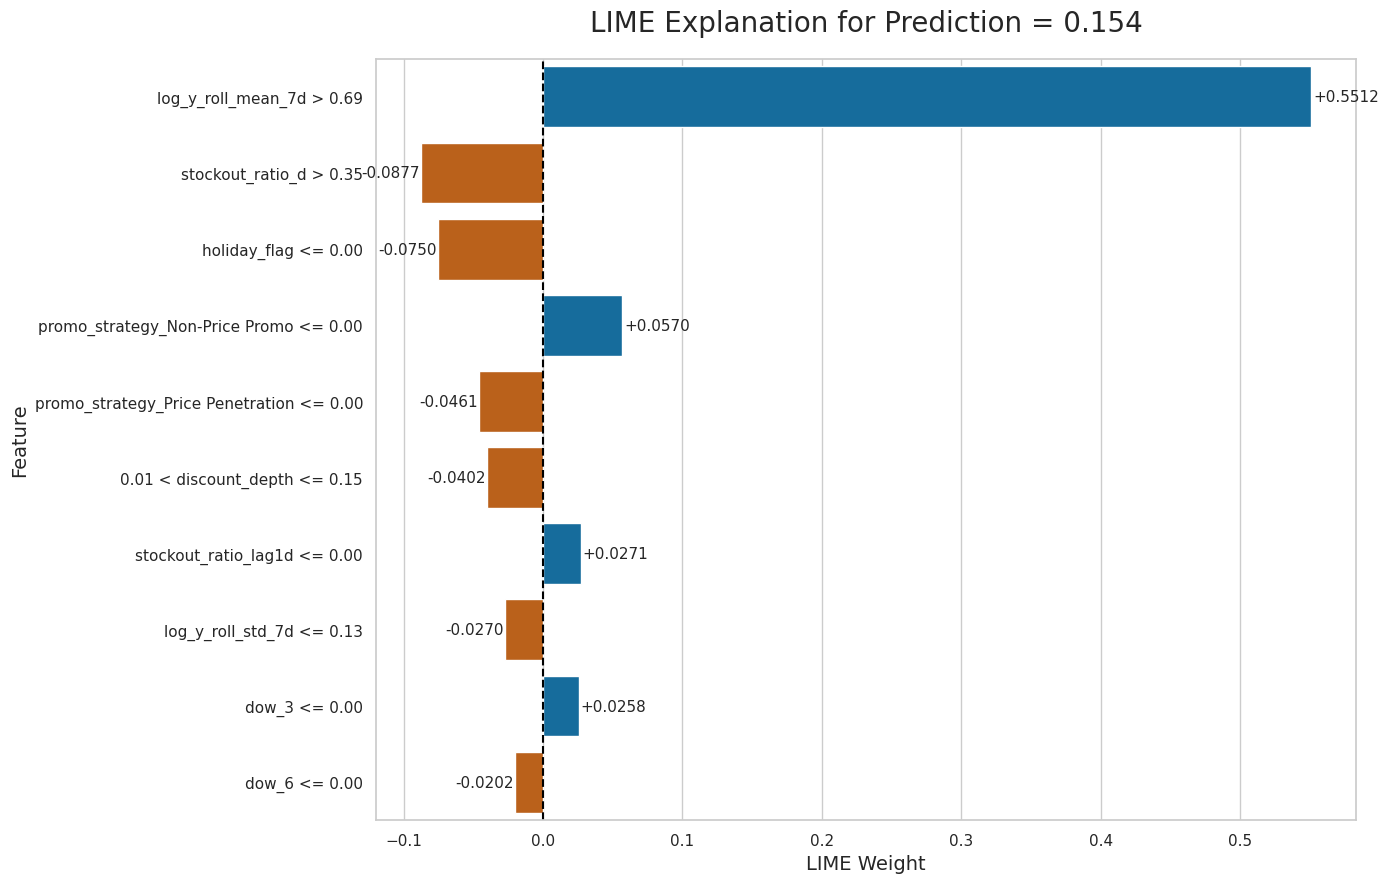

In [ ]:
# ===================================================================
# CELL: Professional LIME Local Explanation Plot
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import textwrap

# This check ensures the necessary objects exist.
if 'lime_explainer' in locals() and 'X_shap_input' in locals():
    print("--- Generating Professional LIME Local Explanation Plot ---")

    # --- Step 1: Identify the instance to explain ---
    # We use the same instance as your SHAP analysis for a direct comparison.
    instance_index_to_explain = 214941
    instance_to_explain = X_shap_input.loc[instance_index_to_explain]
    model_prediction = 0.1536 # The known prediction for this instance

    print(f"\nExplaining prediction for instance: {instance_index_to_explain}")

    # --- Step 2: Generate the LIME explanation object ---
    explanation = lime_explainer.explain_instance(
        instance_to_explain.values,
        champion_model_xgb.predict,
        num_features=10
    )

    # --- Step 3: Extract the data from the explanation ---
    # We get the feature-weight pairs and convert them to a pandas DataFrame.
    explanation_list = explanation.as_list()
    lime_df = pd.DataFrame(explanation_list, columns=['feature', 'weight'])

    # Create a column to distinguish positive vs. negative contributions
    lime_df['positive'] = lime_df['weight'] > 0
    # Sort by the absolute weight to show the most impactful features at the top
    lime_df = lime_df.reindex(lime_df.weight.abs().sort_values(ascending=False).index)

    # --- Step 4: Create the professional plot with seaborn ---
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(14, 9))

    # Define a professional, non-clashing color palette
    palette = {True: "#0072B2", False: "#D55E00"} # Blue for positive, Orange/Red for negative

    # Create the horizontal bar plot
    sns.barplot(
        x='weight',
        y='feature',
        data=lime_df,
        hue='positive', # Use the 'positive' column to color the bars
        palette=palette,
        dodge=False,
        ax=ax,
        legend=False
    )

    # --- Step 5: Add professional titles and annotations ---
    ax.set_title(
        f"LIME Explanation for Prediction = {model_prediction:.3f}",
        fontsize=20,
        pad=20
    )
    ax.set_xlabel("LIME Weight", fontsize=14)
    ax.set_ylabel("Feature", fontsize=14)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)

    # Add value labels to the end of each bar for clarity
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.001 * (-1 if width < 0 else 1), # Position text slightly outside the bar
                p.get_y() + p.get_height() / 2.,
                f'{width:+.4f}',
                ha='left' if width > 0 else 'right',
                va='center',
                fontsize=11)

    plt.tight_layout()
    plt.show()

else:
    print("🚨 ERROR: `lime_explainer` or other necessary objects not found.")

### Save the Results

In [ ]:
# ===================================================================
# CELL: Save the EXISTING LIME Results to Google Drive (Fast)
# Run this cell once to save the 'all_abs_weights' variable from memory.
# ===================================================================
import numpy as np
from google.colab import drive
import os

# First, check if the variable we want to save actually exists in memory.
if 'all_abs_weights' in locals():
    print("--- Found the 'all_abs_weights' variable in the current session. Saving it now... ---")

    # 1. Mount your Google Drive
    drive.mount('/content/drive')

    # 2. Define the directory and path for the saved file
    LIME_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model/LIME_Analysis"
    os.makedirs(LIME_DIR, exist_ok=True)
    LIME_WEIGHTS_PATH = os.path.join(LIME_DIR, "all_abs_weights.npy")

    # 3. Save the existing 'all_abs_weights' NumPy array to the file
    np.save(LIME_WEIGHTS_PATH, all_abs_weights)

    print(f"\n✅ The 'all_abs_weights' array has been successfully and permanently saved to: {LIME_WEIGHTS_PATH}")
    print("You will not need to run the long calculation cell again.")

else:
    print("🚨 CRITICAL ERROR: The 'all_abs_weights' variable was not found in the current session.")
    print("   This means the long LIME calculation cell either did not run or did not complete successfully.")
    print("   If you are sure it ran, please check for typos in the variable name.")

--- Found the 'all_abs_weights' variable in the current session. Saving it now... ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ The 'all_abs_weights' array has been successfully and permanently saved to: /content/drive/MyDrive/XGBoost_Champion_Model/LIME_Analysis/all_abs_weights.npy
You will not need to run the long calculation cell again.


In [ ]:
# ===================================================================
# CELL: Load the Saved LIME Explanation Weights from Google Drive
# This is your new starting point for LIME analysis in any session.
# ===================================================================
import numpy as np
from google.colab import drive
import os

print("--- Loading the saved LIME weights from Google Drive ---")

# --- Step 1: Mount your Google Drive ---
# A pop-up will appear asking for permission.
drive.mount('/content/drive')

# --- Step 2: Define the EXACT Path to your saved file ---
LIME_WEIGHTS_PATH = "/content/drive/MyDrive/XGBoost_Champion_Model/LIME_Analysis/all_abs_weights.npy"

# --- Step 3: Check if the file exists and load it ---
# This check prevents errors and tells you if the saving step was not completed.
if not os.path.exists(LIME_WEIGHTS_PATH):
    raise FileNotFoundError(
        f"LIME weights file not found at {LIME_WEIGHTS_PATH}. "
        "Please ensure you have run the one-time saving script successfully."
    )

# Load the NumPy array from the file. This is a very fast operation.
all_abs_weights = np.load(LIME_WEIGHTS_PATH)

print(f"\n✅ LIME raw weights ('all_abs_weights') loaded successfully from Drive.")
print(f"   The shape of the loaded array is: {all_abs_weights.shape}")
print("   You can now run your fast analysis cell to generate the global importance table.")

# Sparsity & Fidelity Analysis

## Number of Active Features

In [ ]:
# A tiny number to check against to avoid floating-point issues
threshold = 1e-9

# Measure Sparsity for SHAP
if 'shap_global_importance_df' in locals():
    # 'global_importance_df' is the DataFrame with 'Feature' and 'Mean Absolute SHAP'
    active_features_shap = (shap_global_importance_df['Mean Absolute SHAP'] > threshold).sum()
    total_features = len(shap_global_importance_df)
    print(f"\nSHAP Sparsity:")
    print(f"   - SHAP identified {active_features_shap} active features out of {total_features}.")
    print(f"   - This means {total_features - active_features_shap} features had a mean absolute SHAP value of zero.")
else:
    print("\nWARNING: 'global_importance_df' for SHAP not found. Cannot calculate SHAP sparsity.")


# Measure Sparsity for LIME
if 'global_lime_importances' in locals():
    # 'global_lime_importances' is the DataFrame with 'Feature' and 'Mean Absolute LIME Weight'
    active_features_lime = (global_lime_importances['Mean Absolute LIME Weight'] > threshold).sum()
    total_features = len(global_lime_importances)
    print(f"\nLIME Sparsity:")
    print(f"   - LIME identified {active_features_lime} active features out of {total_features}.")
    print(f"   - This means {total_features - active_features_lime} features had an average weight of zero.")
else:
    print("\nWARNING: 'global_lime_importances' not found. Cannot calculate LIME sparsity.")



LIME Sparsity:
   - LIME identified 25 active features out of 25.
   - This means 0 features had an average weight of zero.


## MoRF SHAP

MoRF Retraining Analysis:   0%|          | 0/25 [00:00<?, ?it/s]

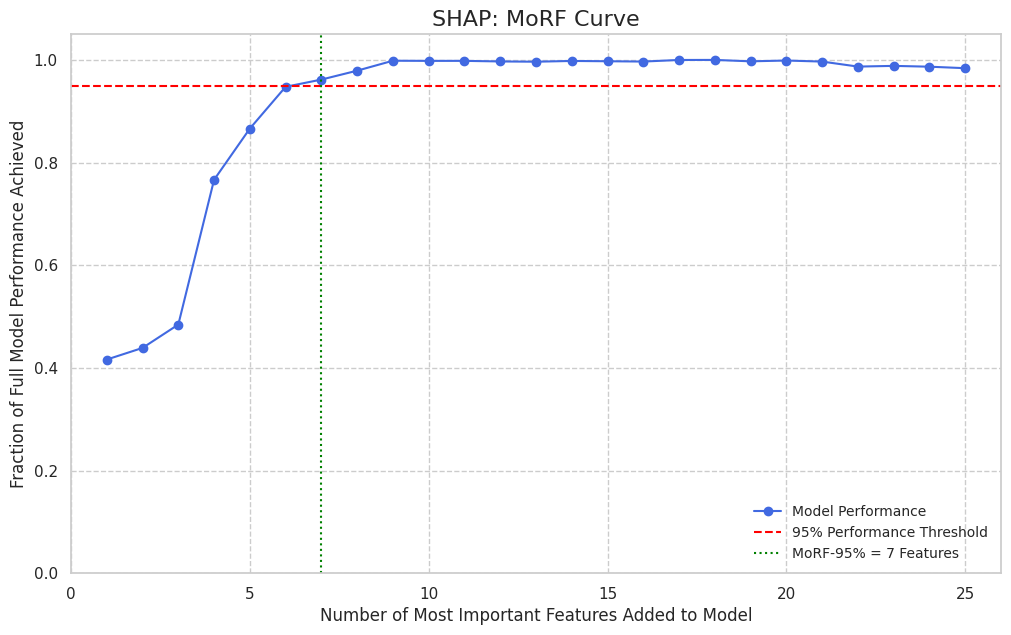

MoRF-95% Threshold: 7 features are required to achieve 95% of the full model's performance.


In [ ]:
if 'shap_global_importance_df' in locals():

    # Get Feature Order and Model Parameters
    feature_importance_order = shap_global_importance_df['Feature'].tolist()

    model_params = best_params_xgb.copy()
    model_params['random_state'] = 42
    model_params['n_jobs'] = -1
    n_estimators = champion_model_xgb.best_iteration

    # Iteratively add features, retrain, and evaluate ---
    morf_results = []
    for k in tqdm(range(1, len(feature_importance_order) + 1), desc="MoRF Retraining Analysis"):
        top_k_features = feature_importance_order[:k]
        X_train_k = X_full_train[top_k_features]
        X_test_k = X_test[top_k_features]
        model_k = xgb.XGBRegressor(n_estimators=n_estimators, **model_params)
        model_k.fit(X_train_k, y_full_train, verbose=False)
        y_pred_k_log = model_k.predict(X_test_k)
        current_rmse = np.sqrt(mean_squared_error(y_test, y_pred_k_log))
        morf_results.append({'features_added': k, 'rmse': current_rmse})

    morf_df = pd.DataFrame(morf_results)

    #  Calculate the Performance Achieved
    full_model_rmse = morf_df['rmse'].min()
    morf_df['performance_achieved'] = full_model_rmse / morf_df['rmse']

    # Calculate the MoRF-95% Threshold
    try:
        morf_95_row = morf_df[morf_df['performance_achieved'] >= 0.95].iloc[0]
        morf_95_shap_true = int(morf_95_row['features_added'])
    except IndexError:
        morf_95_shap_true = len(feature_importance_order)
        print("Warning: Model performance never reached 95% of the full model's baseline.")

    # Generate the True MoRF Curve

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 7))
    plt.plot(morf_df['features_added'], morf_df['performance_achieved'], marker='o', linestyle='-', color='royalblue', label='Model Performance')
    plt.axhline(y=0.95, color='red', linestyle='--', label='95% Performance Threshold')
    plt.axvline(x=morf_95_shap_true, color='green', linestyle=':', label=f'MoRF-95% = {morf_95_shap_true} Features')
    plt.xlabel("Number of Most Important Features Added to Model", fontsize=12)
    plt.ylabel("Fraction of Full Model Performance Achieved", fontsize=12)
    plt.title("SHAP: MoRF Curve", fontsize=16)
    plt.xlim(0, len(feature_importance_order) + 1)
    plt.ylim(0, 1.05)
    plt.legend(fontsize=10)
    plt.grid(True, which='both', linestyle='--')
    plt.show()

    # --- Step 5: Final Quantitative Summary ---

    print(f"MoRF-95% Threshold: {morf_95_shap_true} features are required to achieve 95% of the full model's performance.")

else:
    # Use your correct variable name in the error message
    print("🚨 ERROR: `shap_global_importance_df` not found. Please run the SHAP global importance calculation cell first.")

### save shap morf

In [ ]:
# ===================================================================
# CELL: MoRF Sparsity Analysis AND SAVE THE RESULTS
# ===================================================================
# ... (all your existing code for the MoRF analysis is above this line) ...
# It ends with the creation of the plot and the final print statement.

# Your existing print statement:
print(f"MoRF-95% Threshold: {morf_95_shap_true} features are required...")


# ===================================================================
# ADD THIS NEW BLOCK AT THE VERY END OF THE CELL
# ===================================================================
from google.colab import drive
import os

print("\n--- Saving the MoRF analysis results to Google Drive ---")

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define a dedicated folder for this analysis
SPARSITY_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model/Sparsity_Analysis"
os.makedirs(SPARSITY_DIR, exist_ok=True)

# 3. Define the path for the results file
MORF_RESULTS_PATH = os.path.join(SPARSITY_DIR, "morf_shap_results.csv")

# 4. Save the 'morf_df' DataFrame to a CSV file.
#    We save the index because it contains the number of features.
morf_df.to_csv(MORF_RESULTS_PATH, index=False)

print(f"\n✅ MoRF analysis DataFrame has been permanently saved to: {MORF_RESULTS_PATH}")
# ===================================================================

MoRF-95% Threshold: 7 features are required...

--- Saving the MoRF analysis results to Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ MoRF analysis DataFrame has been permanently saved to: /content/drive/MyDrive/XGBoost_Champion_Model/Sparsity_Analysis/morf_shap_results.csv


In [ ]:
# ===================================================================
# FUTURE WORKFLOW: Load Saved MoRF Results and Generate Plot
# This is the ONLY cell you need to run in the future for this analysis.
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os

print("--- Loading the saved MoRF analysis results from Google Drive ---")

# --- Step 1: Mount Drive and Load the Data ---
drive.mount('/content/drive')
MORF_RESULTS_PATH = "/content/drive/MyDrive/XGBoost_Champion_Model/Sparsity_Analysis/morf_shap_results.csv"

if not os.path.exists(MORF_RESULTS_PATH):
    raise FileNotFoundError(f"MoRF results file not found at {MORF_RESULTS_PATH}. Please run the one-time saving script first.")

# Load the saved DataFrame
morf_df = pd.read_csv(MORF_RESULTS_PATH)
print("✅ MoRF analysis DataFrame loaded successfully.")

# --- Step 2: Re-run the FAST Analysis and Plotting Logic ---
# This part runs in seconds using the loaded 'morf_df'.

# Re-calculate the MoRF-95% Threshold
try:
    morf_95_row = morf_df[morf_df['performance_achieved'] >= 0.95].iloc[0]
    morf_95_shap_true = int(morf_95_row['features_added'])
except IndexError:
    morf_95_shap_true = len(morf_df) # Total number of features is the length of the df
    print("Warning: Model performance never reached 95% of the full model's baseline.")

# Re-generate the MoRF Curve
print("\n--- Generating the True MoRF Contribution Curve from loaded data ---")
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))
plt.plot(morf_df['features_added'], morf_df['performance_achieved'], marker='o', linestyle='-', color='royalblue', label='Model Performance')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Performance Threshold')
plt.axvline(x=morf_95_shap_true, color='green', linestyle=':', label=f'MoRF-95% = {morf_95_shap_true} Features')
plt.xlabel("Number of Most Important Features Added to Model", fontsize=12)
plt.ylabel("Fraction of Full Model Performance Achieved", fontsize=12)
plt.title("SHAP: MoRF Curve (Loaded from Saved Results)", fontsize=16)
plt.xlim(0, len(morf_df) + 1)
plt.ylim(0, 1.05)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--')
plt.show()

# Re-print the Final Quantitative Summary
print("\n--- True MoRF Analysis Summary (SHAP) ---")
print(f"MoRF-95% Threshold: {morf_95_shap_true} features are required to achieve 95% of the full model's performance.")

## LIME MoRF

LIME MoRF Retraining:   0%|          | 0/25 [00:00<?, ?it/s]

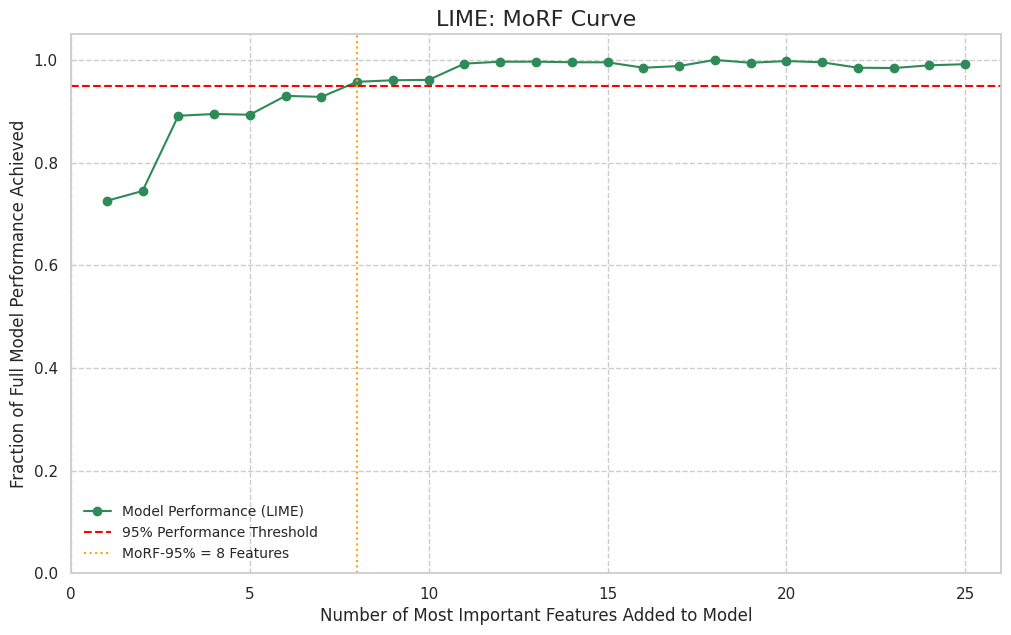

In [ ]:
if 'global_lime_importances' in locals():

    # Get Feature Order from LIME and Model Parameters
    # We use the feature ranking calculated from LIME.
    feature_importance_order = global_lime_importances['Feature'].tolist()

    # Use the same model parameters for a fair comparison
    model_params = best_params_xgb.copy()
    model_params['random_state'] = 42
    model_params['n_jobs'] = -1
    n_estimators = champion_model_xgb.best_iteration

    # Iteratively add features, retrain, and evaluate ---
    morf_results_lime = []
    for k in tqdm(range(1, len(feature_importance_order) + 1), desc="LIME MoRF Retraining"):
        top_k_features = feature_importance_order[:k]
        X_train_k = X_full_train[top_k_features]
        X_test_k = X_test[top_k_features]
        model_k = xgb.XGBRegressor(n_estimators=n_estimators, **model_params)
        model_k.fit(X_train_k, y_full_train, verbose=False)
        y_pred_k_log = model_k.predict(X_test_k)
        current_rmse = np.sqrt(mean_squared_error(y_test, y_pred_k_log))
        morf_results_lime.append({'features_added': k, 'rmse': current_rmse})

    morf_df_lime = pd.DataFrame(morf_results_lime)

    # Calculate the Performance Achieved
    full_model_rmse = morf_df_lime['rmse'].min()
    morf_df_lime['performance_achieved'] = full_model_rmse / morf_df_lime['rmse']

    # Calculate the MoRF-95% Threshold
    try:
        morf_95_row = morf_df_lime[morf_df_lime['performance_achieved'] >= 0.95].iloc[0]
        morf_95_lime_true = int(morf_95_row['features_added'])
    except IndexError:
        morf_95_lime_true = len(feature_importance_order)
        print("Warning: Model performance never reached 95% of the full model's baseline.")

    # Step 5: Generate the True MoRF Curve for LIME
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 7))
    # Use a different color (green) to distinguish from SHAP's blue plot
    plt.plot(morf_df_lime['features_added'], morf_df_lime['performance_achieved'], marker='o', linestyle='-', color='seagreen', label='Model Performance (LIME)')
    plt.axhline(y=0.95, color='red', linestyle='--', label='95% Performance Threshold')
    plt.axvline(x=morf_95_lime_true, color='orange', linestyle=':', label=f'MoRF-95% = {morf_95_lime_true} Features')
    plt.xlabel("Number of Most Important Features Added to Model", fontsize=12)
    plt.ylabel("Fraction of Full Model Performance Achieved", fontsize=12)
    plt.title("LIME: MoRF Curve", fontsize=16)
    plt.xlim(0, len(feature_importance_order) + 1)
    plt.ylim(0, 1.05)
    plt.legend(fontsize=10)
    plt.grid(True, which='both', linestyle='--')
    plt.show()
else:

    print("🚨 ERROR: `global_lime_importances` not found. Please run the LIME global importance calculation cell first.")

### SAVE LIME MORF

In [ ]:
#Save the LIME MoRF results to Google Drive ---
print("\n--- Saving the LIME MoRF analysis results to Google Drive ---")
drive.mount('/content/drive')
SPARSITY_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model/Sparsity_Analysis"
os.makedirs(SPARSITY_DIR, exist_ok=True)
MORF_LIME_RESULTS_PATH = os.path.join(SPARSITY_DIR, "morf_lime_results.csv")
morf_df_lime.to_csv(MORF_LIME_RESULTS_PATH, index=False)
print(f"\n✅ LIME MoRF analysis DataFrame has been permanently saved to: {MORF_LIME_RESULTS_PATH}")




--- Saving the LIME MoRF analysis results to Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ LIME MoRF analysis DataFrame has been permanently saved to: /content/drive/MyDrive/XGBoost_Champion_Model/Sparsity_Analysis/morf_lime_results.csv


In [ ]:
# ===================================================================
# FUTURE WORKFLOW: Load Saved LIME MoRF Results and Generate Plot
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os

print("--- Loading the saved LIME MoRF analysis results from Google Drive ---")

# --- Step 1: Mount Drive and Load the Data ---
drive.mount('/content/drive')
MORF_LIME_RESULTS_PATH = "/content/drive/MyDrive/XGBoost_Champion_Model/Sparsity_Analysis/morf_lime_results.csv"

if not os.path.exists(MORF_LIME_RESULTS_PATH):
    raise FileNotFoundError(f"LIME MoRF results file not found at {MORF_LIME_RESULTS_PATH}.")

morf_df_lime = pd.read_csv(MORF_LIME_RESULTS_PATH)
print("✅ LIME MoRF analysis DataFrame loaded successfully.")

# --- Step 2: Re-run the FAST Analysis and Plotting Logic ---
# (This part is identical to the fast part of the cell above)
try:
    morf_95_row = morf_df_lime[morf_df_lime['performance_achieved'] >= 0.95].iloc[0]
    morf_95_lime_true = int(morf_95_row['features_added'])
except IndexError:
    morf_95_lime_true = len(morf_df_lime)

print("\n--- Generating the True MoRF Contribution Curve (LIME) ---")
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))
plt.plot(morf_df_lime['features_added'], morf_df_lime['performance_achieved'], marker='o', linestyle='-', color='seagreen', label='Model Performance (LIME)')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Performance Threshold')
plt.axvline(x=morf_95_lime_true, color='orange', linestyle=':', label=f'MoRF-95% = {morf_95_lime_true} Features')
plt.xlabel("Number of Most Important Features Added to Model (LIME Order)", fontsize=12)
plt.ylabel("Fraction of Full Model Performance Achieved", fontsize=12)
plt.title("LIME: MoRF Sparsity Curve (Loaded from Saved Results)", fontsize=16, fontweight='bold')
plt.xlim(0, len(morf_df_lime) + 1)
plt.ylim(0, 1.05)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--')
plt.show()

print(f"\nMoRF-95% Threshold (LIME): {morf_95_lime_true} features are required.")

## LeRF SHAP

Baseline LOG RMSE with all features: 0.1879


SHAP LeRF Masking:   0%|          | 0/25 [00:00<?, ?it/s]

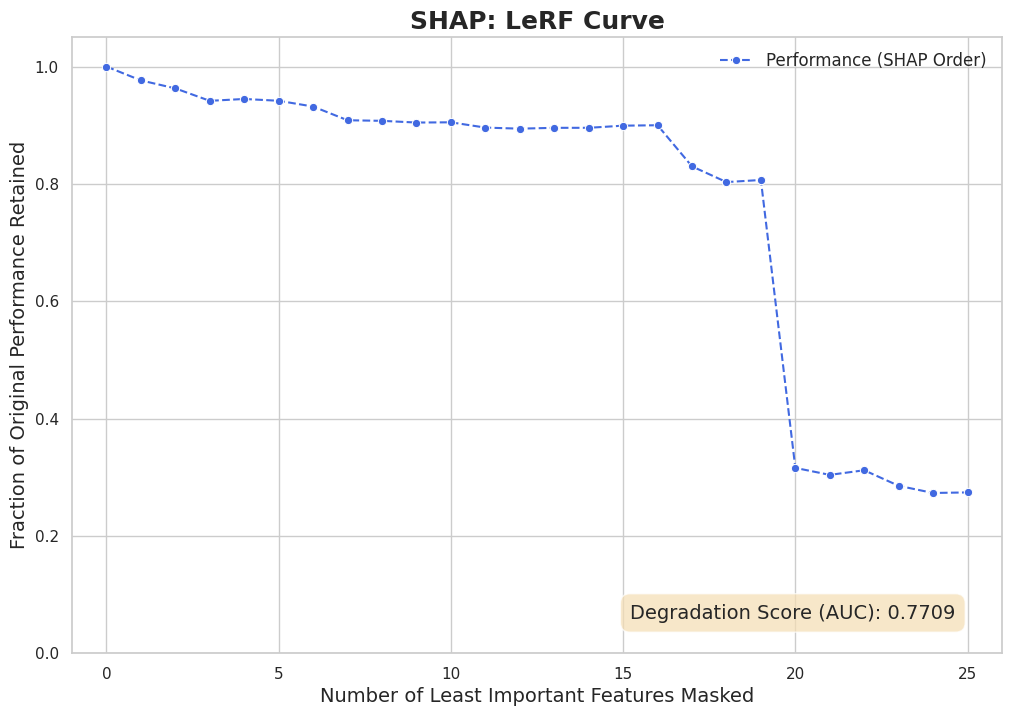


--- XAI Fidelity Analysis Summary (SHAP) ---
Degradation Score (AUC): 0.7709 (Higher score indicates higher fidelity)


In [ ]:
if 'shap_global_importance_df' in locals():

    # Get Baseline and Feature Order
    feature_importance_order = shap_global_importance_df['Feature'].tolist()

    y_pred_baseline_log = champion_model_xgb.predict(X_test)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline_log))
    print(f"Baseline LOG RMSE with all features: {baseline_rmse:.4f}")


    lerf_results_shap = []
    feature_removal_order = feature_importance_order[::-1] # Start with least important
    X_test_iterative = X_test.copy()

    lerf_results_shap.append({'features_masked': 0, 'rmse': baseline_rmse})

    for i, feature_to_mask in enumerate(tqdm(feature_removal_order, desc="SHAP LeRF Masking")):
        X_test_iterative[feature_to_mask] = 0
        y_pred_iterative_log = champion_model_xgb.predict(X_test_iterative)
        current_rmse = np.sqrt(mean_squared_error(y_test, y_pred_iterative_log))
        lerf_results_shap.append({'features_masked': i + 1, 'rmse': current_rmse})

    lerf_df_shap = pd.DataFrame(lerf_results_shap)
    lerf_df_shap['performance_retained'] = baseline_rmse / lerf_df_shap['rmse']

    # Calculate the Degradation Score
    lerf_x_normalized = lerf_df_shap['features_masked'] / len(feature_importance_order)
    lerf_y_performance = lerf_df_shap['performance_retained']
    degradation_score_shap = np.trapz(y=lerf_y_performance, x=lerf_x_normalized)

    # Generate the LeRF Degradation Curve
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=lerf_df_shap, x='features_masked', y='performance_retained', marker='o', linestyle='--', color='royalblue', label='Performance (SHAP Order)')
    plt.text(0.95, 0.05, f'Degradation Score (AUC): {degradation_score_shap:.4f}', transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=14, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
    plt.xlabel("Number of Least Important Features Masked", fontsize=14)
    plt.ylabel("Fraction of Original Performance Retained", fontsize=14)
    plt.title("SHAP: LeRF Curve", fontsize=18, fontweight='bold')
    plt.xlim(-1, len(feature_importance_order) + 1)
    plt.ylim(0, 1.05)
    plt.legend(fontsize=12)
    plt.show()


    print("\n--- XAI Fidelity Analysis Summary (SHAP) ---")
    print(f"Degradation Score (AUC): {degradation_score_shap:.4f} (Higher score indicates higher fidelity)")

else:
    # Use the correct variable name in the error message
    print("🚨 ERROR: `shap_global_importance_df` not found. Please run the cell that calculates this first.")

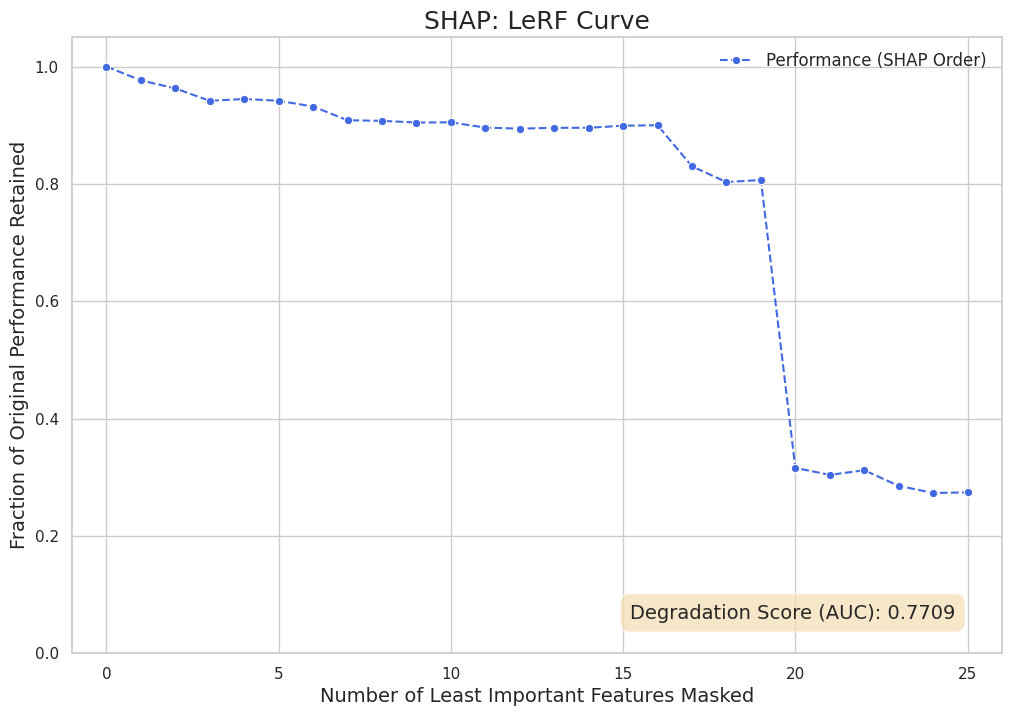

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.lineplot(data=lerf_df_shap, x='features_masked', y='performance_retained', marker='o', linestyle='--', color='royalblue', label='Performance (SHAP Order)')
plt.text(0.95, 0.05, f'Degradation Score (AUC): {degradation_score_shap:.4f}', transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=14, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
plt.xlabel("Number of Least Important Features Masked", fontsize=14)
plt.ylabel("Fraction of Original Performance Retained", fontsize=14)
plt.title("SHAP: LeRF Curve", fontsize=18)
plt.xlim(-1, len(feature_importance_order) + 1)
plt.ylim(0, 1.05)
plt.legend(fontsize=12)
plt.show()

## LERF LIME

LIME LeRF Masking:   0%|          | 0/25 [00:00<?, ?it/s]

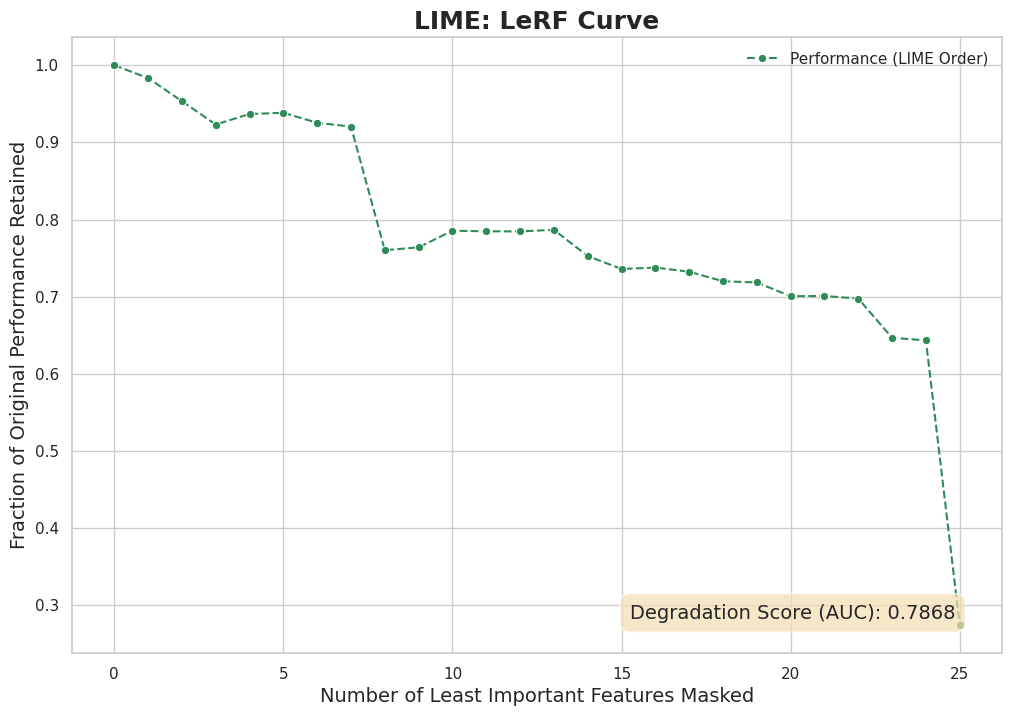

Degradation Score (AUC): 0.7868


In [ ]:
if 'global_lime_importances' in locals():

    feature_importance_order = global_lime_importances['Feature'].tolist()

    lerf_results_lime = []
    feature_removal_order = feature_importance_order[::-1]
    X_test_iterative = X_test.copy()
    lerf_results_lime.append({'features_masked': 0, 'rmse': baseline_rmse})

    for i, feature_to_mask in enumerate(tqdm(feature_removal_order, desc="LIME LeRF Masking")):
        X_test_iterative[feature_to_mask] = 0
        y_pred_iterative_log = champion_model_xgb.predict(X_test_iterative)
        current_rmse = np.sqrt(mean_squared_error(y_test, y_pred_iterative_log))
        lerf_results_lime.append({'features_masked': i + 1, 'rmse': current_rmse})

    lerf_df_lime = pd.DataFrame(lerf_results_lime)
    lerf_df_lime['performance_retained'] = baseline_rmse / lerf_df_lime['rmse']

    # Calculate the Degradation Score
    lerf_x_normalized = lerf_df_lime['features_masked'] / len(feature_importance_order)
    lerf_y_performance = lerf_df_lime['performance_retained']
    degradation_score_lime = np.trapz(y=lerf_y_performance, x=lerf_x_normalized)


    plt.figure(figsize=(12, 8))
    sns.lineplot(data=lerf_df_lime, x='features_masked', y='performance_retained', marker='o', linestyle='--', color='seagreen', label='Performance (LIME Order)')
    plt.text(0.95, 0.05, f'Degradation Score (AUC): {degradation_score_lime:.4f}', transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=14, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
    plt.title("LIME: LeRF Curve", fontsize=18, fontweight='bold')
    plt.xlabel("Number of Least Important Features Masked", fontsize=14)
    plt.ylabel("Fraction of Original Performance Retained", fontsize=14)
    plt.legend()
    plt.show()
    print(f"Degradation Score (AUC): {degradation_score_lime:.4f}")

else:
    print("🚨 ERROR: `global_lime_importances` not found.")

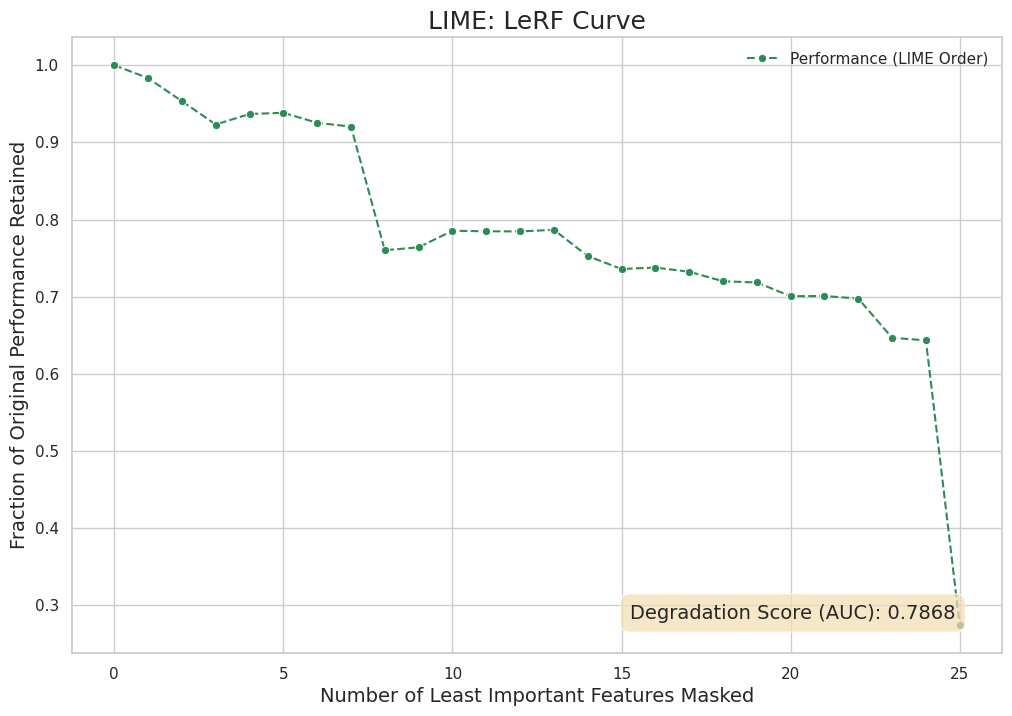

In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=lerf_df_lime, x='features_masked', y='performance_retained', marker='o', linestyle='--', color='seagreen', label='Performance (LIME Order)')
plt.text(0.95, 0.05, f'Degradation Score (AUC): {degradation_score_lime:.4f}', transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=14, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
plt.title("LIME: LeRF Curve", fontsize=18)
plt.xlabel("Number of Least Important Features Masked", fontsize=14)
plt.ylabel("Fraction of Original Performance Retained", fontsize=14)
plt.legend()
plt.show()

In [ ]:
# ===================================================================
# CELL 1: Save the COMPLETED Fidelity Analysis Results (Fast)
# Run this cell once AFTER the SHAP and LIME LeRF cells have finished.
# ===================================================================
import os
import pandas as pd

# This cell assumes your Google Drive is already mounted.

print("--- Saving the Fidelity (LeRF) analysis results to Google Drive ---")

# First, check if the variables we want to save actually exist.
if 'lerf_df_shap' in locals() and 'lerf_df_lime' in locals():

    # 1. Define the directory for these results
    FIDELITY_DIR = "/content/drive/MyDrive/XGBoost_Champion_Model/Fidelity_Analysis"
    os.makedirs(FIDELITY_DIR, exist_ok=True)

    # 2. Define the paths for each results file
    LERF_SHAP_PATH = os.path.join(FIDELITY_DIR, "lerf_shap_results.csv")
    LERF_LIME_PATH = os.path.join(FIDELITY_DIR, "lerf_lime_results.csv")

    # 3. Save each DataFrame to a CSV file.
    #    index=False is correct because the default integer index is not meaningful.
    lerf_df_shap.to_csv(LERF_SHAP_PATH, index=False)
    lerf_df_lime.to_csv(LERF_LIME_PATH, index=False)

    print(f"\n✅ SHAP fidelity results permanently saved to: {LERF_SHAP_PATH}")
    print(f"✅ LIME fidelity results permanently saved to: {LERF_LIME_PATH}")
    print("\nYou will not need to run the long calculation cells again.")

else:
    print("🚨 ERROR: `lerf_df_shap` or `lerf_df_lime` not found in the current session.")
    print("   Please ensure the long calculation cells have completed successfully before running this.")

--- Saving the Fidelity (LeRF) analysis results to Google Drive ---

✅ SHAP fidelity results permanently saved to: /content/drive/MyDrive/XGBoost_Champion_Model/Fidelity_Analysis/lerf_shap_results.csv
✅ LIME fidelity results permanently saved to: /content/drive/MyDrive/XGBoost_Champion_Model/Fidelity_Analysis/lerf_lime_results.csv

You will not need to run the long calculation cells again.


In [ ]:
# ===================================================================
# CELL 3: Generate the Comparative Fidelity Plot from Loaded Data
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if 'lerf_df_shap' in locals() and 'lerf_df_lime' in locals():
    print("\n--- Generating the Comparative LeRF Degradation Curve from loaded data ---")

    # --- Re-calculate the fast AUC scores from the loaded data ---
    num_features = len(lerf_df_shap) - 1
    degradation_score_shap = np.trapz(y=lerf_df_shap['performance_retained'], x=lerf_df_shap['features_masked'] / num_features)
    degradation_score_lime = np.trapz(y=lerf_df_lime['performance_retained'], x=lerf_df_lime['features_masked'] / num_features)

    # --- Create the plot ---
    plt.figure(figsize=(14, 9))
    sns.set_theme(style="whitegrid")

    plt.plot(lerf_df_shap['features_masked'], lerf_df_shap['performance_retained'], marker='o', linestyle='--', color='royalblue', label=f'SHAP (AUC = {degradation_score_shap:.3f})')
    plt.plot(lerf_df_lime['features_masked'], lerf_df_lime['performance_retained'], marker='s', linestyle=':', color='seagreen', label=f'LIME (AUC = {degradation_score_lime:.3f})')

    plt.xlabel("Number of Least Important Features Masked", fontsize=14)
    plt.ylabel("Fraction of Original Performance Retained", fontsize=14)
    plt.title("Comparative Fidelity: SHAP vs. LIME LeRF Degradation", fontsize=18, fontweight='bold')
    plt.xlim(-1, num_features + 1)
    plt.ylim(0, 1.05)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--')
    plt.show()

else:
    print("🚨 ERROR: 'lerf_df_shap' or 'lerf_df_lime' not found. Please run the loading cell (Part B) first.")